In [1]:
import urllib.request
import json
import re
import matplotlib.pyplot as plt
from matplotlib import style
from datetime import datetime, date, time

In [2]:
def writefile(namefile,result):
    file = open(namefile, "w", encoding = "utf-8")
    file.write(result)
    file.close()

In [3]:
def file(name):
    f = open(name, 'r', encoding = 'utf-8')
    fr = f.read()
    f.close()
    return fr

In [4]:
def clean1(string):
    regTag = re.compile('<.*?>', flags=re.U | re.DOTALL)
    clean_t = regTag.sub(' ', string)
    clean_t = re.sub('-&gt;','->',clean_t)
    return clean_t

In [5]:
def clean2(string):
    clean_t = re.sub(r'Телефон',r'Телефон ',string)
    clean_t = re.sub(r'(\([0-9]{3}\)) ',r'\1',clean_t)
    clean_t = re.sub(r' (\([0-9]{3}\))',r'\1',clean_t)
    clean_t = re.sub(r' (\([0-9]{3}\)) ',r'\1',clean_t)
    clean_t = re.sub('\[.*?\|(.*?)\]',r'\1',clean_t)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    clean_t = emoji_pattern.sub(r'', clean_t)
    clean_t = re.sub('\\u2728', '', clean_t)
    clean_t = re.sub('#',' ',clean_t)
    return clean_t

In [6]:
def posts():
    ids = []
    texts = []
    for k in range (2):
        #print(k)
        if k == 0:
            offset_num = str(0)
        else:
            offset_num = str(k) + '00'
        req = urllib.request.Request('https://api.vk.com/method/wall.get?owner_id=-64607113&count=100&offset='+offset_num)
        response = urllib.request.urlopen(req)
        result = response.read().decode('utf-8')
        data = json.loads(result)
        #print(data)
        for i in range (1,101):
            #print(i)
            if data["response"][i]["post_type"] == "post":
                text = data["response"][i]["text"]
            if data["response"][i]["post_type"] == "copy":
                if not "copy_text" in data["response"][i]:
                    text = ""
                else:
                    text = data["response"][i]["copy_text"]
            post_id = data["response"][i]["id"]
            texts.append(text)
            ids.append(post_id)
            #print(text, post_id)
    return ids, texts

In [7]:
def dictpost():
    ids, texts = posts()
    d = dict(zip(ids, texts))
    return d

In [8]:
def filepost():#функция скачивающая посты в файл
    dictposts = dictpost()
    comm = ''
    for num_id in dictposts:
        string = clean1(dictposts[num_id])
        if comm == '':
            comm = string
        else:
            comm = comm + '\n' + string
    #print(comm)
    writefile('posts.txt',comm)

In [9]:
filepost()#posts.txt - файл с постами

In [10]:
def comments():
    comms = {}
    ids, texts = posts()
    ids_user = {}
    for id_num in ids:
        comm_uni = []
        users = []
        #print(id_num)
        for k in range (2):
            #print(k)
            if k == 0:
                offset_num = str(0)
            else:
                offset_num = str(k) + '00'
            req = urllib.request.Request('https://api.vk.com/method/wall.getComments?owner_id=-64607113'+'&post_id='+str(id_num)+'&count=100&offset='+offset_num)
            response = urllib.request.urlopen(req)
            result = response.read().decode('utf-8')
            #print(result)
            data = json.loads(result)
            i = 1
            while i < len(data["response"]):
                #print(i)
                if not "text" in data["response"][i]:
                    comm = ''
                    id_user = ''
                else:
                    comm = data["response"][i]["text"]
                    id_user = data["response"][i]["from_id"]
                comm_uni.append(comm)
                users.append(id_user)
                i += 1
        #print(comm_uni)
        comms[id_num] = comm_uni
        ids_user[id_num] = users
    comms = json.dumps(comms, ensure_ascii=False)
    ids_user = json.dumps(ids_user, ensure_ascii=False)
    return comms, ids_user

In [11]:
comms, ids_user = comments()
writefile('comms.txt',str(comms))#словарь: ключи - id постов, значения - комментарии к ним
writefile('ids_user.txt',str(ids_user))#словарь: ключи - id постов, значения - id userа, написавшего комментарий

In [12]:
def filecomments():
    dictcomms = file('comms.txt')
    dictcomms = json.loads(dictcomms)   
    final = ''
    for num_id in dictcomms:
        allcomm = ''
        #print(type(dictcomms))
        for every in dictcomms[num_id]:
            #print(dictcomms[num_id])
            string = clean1(every)
            if allcomm == '':
                allcomm = string
            else:
                allcomm = allcomm + '\n' + string
        if final == '':
            final = str(num_id) + '\n' +allcomm
        else:
            final = final + '\n\n\n\n' + str(num_id) + '\n' + allcomm
    writefile('comments.txt',final)

In [13]:
filecomments()

In [14]:
def number(string):
    g = clean1(string)
    g2 = clean2(g)
    #print(g2)
    strm = g2.split(' ')
    #print(strm)
    return strm

In [15]:
def numpost():
    lengths = []
    dictposts = dictpost()#словарь: ключи - ids поста, значения - пост
    #print(dictposts)
    for num_id in dictposts:#каждый пост просматривает
        if dictposts[num_id] == '':# если ничего не написано в посту
            strm = []# тогда массив из 0 элементов
        else:# если что-то написано
            strm_0 = number(dictposts[num_id])#разделяет на слова
            #print(strm_0)
            strm = []
            for x in strm_0:# чтобы не было пустых строк
                x = x.strip(' .,()[];:?!«»{}-/')
                if x.startswith('http'):
                    x = ''
                if x != '':
                    strm.append(x)#добавляет в массив непустые слова
            #print(strm)
        length = len(strm)
        lengths.append(length)
    #print(lengths)
    return lengths

In [16]:
numpost()

[36,
 10,
 85,
 0,
 39,
 18,
 78,
 0,
 66,
 30,
 0,
 0,
 0,
 44,
 66,
 70,
 8,
 22,
 0,
 53,
 49,
 145,
 27,
 25,
 145,
 55,
 0,
 0,
 33,
 0,
 14,
 19,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 127,
 33,
 19,
 15,
 11,
 10,
 15,
 26,
 18,
 18,
 18,
 18,
 42,
 18,
 18,
 18,
 18,
 18,
 18,
 44,
 18,
 18,
 57,
 44,
 37,
 42,
 41,
 42,
 43,
 42,
 43,
 31,
 32,
 31,
 31,
 40,
 57,
 46,
 19,
 28,
 29,
 29,
 30,
 29,
 30,
 31,
 32,
 31,
 31,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 18,
 17,
 17,
 17,
 31,
 41,
 54,
 0,
 0,
 0,
 0,
 37,
 32,
 32,
 31,
 32,
 30,
 35,
 34,
 31,
 32,
 31,
 32,
 45,
 0,
 57,
 16,
 19,
 32,
 32,
 31,
 32,
 30,
 31,
 35,
 34,
 32,
 31,
 32,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 61,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 8,
 29,
 29,
 32,
 29,
 32,
 32,
 32,
 31,
 33,
 31,
 30,
 46,
 12,
 46,
 19,
 29,
 29,
 32,
 32,
 29,
 32,
 32,
 31,
 33,
 31,
 14,
 15,
 15,
 0,
 15,
 15,
 15,
 15,
 16,
 16,
 29,
 16,
 16,
 24,
 30,
 28,
 35]

In [17]:
def numcomm():
    lengths = []
    dictcomms = json.loads(file('comms.txt'))
    av = []
    num_us = {}
    for num_id in dictcomms:
        numb = []
        if dictcomms[num_id] == []:
            numb = []
        else:
            for p in dictcomms[num_id]:
                if p == '':
                    strm = []
                else:
                    strm_0 = number(p)
                    strm = []
                    for x in strm_0:
                        x = x.strip(' .,()[];:?!«»{}-/')
                        if x.startswith('http'):
                            x = ''
                        if x != '':
                            strm.append(x)
                length = len(strm)
                numb.append(length)
            num_us[num_id] = numb
            #print (numb)
        summ = 0
        for y in numb:
            summ = summ + y
        if summ == 0:
            average = 0
        else:
            average = round(summ / len(numb))
        av.append(average)
    #print(av)
    return av, num_us

In [18]:
av, num_us = numcomm()
av = json.dumps(av, ensure_ascii=False)#массив из средних длин комментарие к каждому посту
num_us = json.dumps(num_us, ensure_ascii=False)#словарь: ключ - id поста, значение - массив из длин комментарие к этому посту
writefile('num_us.txt',str(num_us))

In [19]:
def graph1():
    av, num_us = numcomm()
    post = numpost()
    dictlen = dict(zip(post, av))
    #print(dictlen)
    x = []
    y = []
    for key in sorted(dictlen):
        x.append(key)
        y.append(dictlen[key])
    #print(x)
    #print(y)
    style.use('ggplot')
    plt.plot(x, y, 'purple')
    plt.title('Зависимость длины комментария от длины поста')
    plt.ylabel('Средняя длина комментариев')
    plt.xlabel('Длина поста')
    plt.savefig('relation.png')
    plt.show()
    plt.close()

In [20]:
graph1()

In [21]:
def people():
    ids_user = json.loads(file('ids_user.txt'))
    num_us = json.loads(file('num_us.txt'))
    mass1 = []# id чувака
    mass2 = []# длина его комментария
    for x in ids_user:
        for i in ids_user[x]:
            mass1.append(i)
    for y in num_us:
        for h in num_us[y]:
            mass2.append(h)
    return mass1, mass2

In [22]:
mass1, mass2 = people()
#print(mass1)
#print(mass2)
#print(len(mass1))
#print(len(mass2))
mass1 = json.dumps(mass1, ensure_ascii=False)
mass2 = json.dumps(mass2, ensure_ascii=False)
writefile('id_people.txt',str(mass1))#id userа, который написал коммент
writefile('length.txt',str(mass2))#длина его комментария

In [23]:
def calculate_age(born):
    today = date.today()
    try: 
        birthday = born.replace(year=today.year)
    except ValueError:
        birthday = born.replace(year=today.year, day=born.day-1)
    if birthday > today:
        return today.year - born.year - 1
    else:
        return today.year - born.year

In [24]:
def what_city(id_city):
    req = urllib.request.Request('https://api.vk.com/method/database.getCitiesById?city_ids='+str(id_city))
    response = urllib.request.urlopen(req)
    result = response.read().decode('utf-8')
    data = json.loads(result)
    city = data["response"][0]['name']
    return city

In [25]:
def id_people():
    mass1 = file('id_people.txt')
    data = json.loads(mass1)
    return(data)# делает массив из id людей, которые написали комментарии

In [26]:
def user_know(id_us):
    req = urllib.request.Request('https://api.vk.com/method/users.get?user_ids=' + str(id_us) + '&fields=bdate,city')
    response = urllib.request.urlopen(req)
    result = response.read().decode('utf-8')
    data = json.loads(result)
    return data

In [27]:
def info():
    mass = id_people()
    inf = []
    #k = 1
    for i in mass:
        #print(i)
        #print(str(k) + '--' + str(i))
        data = user_know(i)
        inf.append(data["response"][0])
        #k += 1
        #if k == 2000:
        #    break
    #print(inf)
    inf = json.dumps(inf, ensure_ascii=False)
    writefile('inf.txt',str(inf))

In [28]:
info()

In [29]:
def ages_cities():
    inf = file('inf.txt')
    data = json.loads(inf)
    ages = []
    cities = []
    for x in data:
        #print(x)
        if 'bdate' in x:
            birth = x['bdate']
            if len(birth) > 5: # проверяю, правильно ли записана дата
                day, month, year = [int(x) for x in birth.split(".")]
                born = date(year, month, day)
                age = calculate_age(born)
            else:
                age = 0
        else:# это муссор: 0 обозначаю тех, кого не указан год рождения(только день и месяц) или вообще ничего не указано
            age = 0#noage
        ages.append(age)# int
        if 'city' in x:
            city = x['city']
        else:
            city = 0
        cities.append(city)
    return ages, cities

In [30]:
ages, cities = ages_cities()
print(ages)
print(cities)

[14, 32, 0, 0, 23, 0, 0, 0, 15, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 0, 26, 0, 0, 18, 0, 0, 0, 0, 0, 0, 0, 26, 26, 19, 0, 0, 0, 15, 18, 0, 0, 0, 0, 17, 0, 0, 13, 0, 44, 0, 0, 0, 0, 0, 0, 0, 0, 27, 0, 27, 0, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 17, 0, 29, 0, 0, 0, 37, 17, 16, 0, 25, 16, 16, 0, 0, 0, 0, 0, 0, 16, 115, 18, 115, 18, 115, 18, 115, 15, 18, 0, 0, 0, 0, 0, 16, 0, 0, 15, 0, 15, 15, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 15, 23, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 15, 15, 22, 22, 0, 23, 0, 15, 0, 0, 0, 17, 0, 0, 0, 0, 17, 0, 0, 0, 17, 0, 0, 0, 15, 0, 0, 0, 28, 23, 21, 24, 0, 0, 0, 0, 20, 0, 0, 0, 0, 28, 31, 20, 36, 0, 0, 0, 0, 0, 31, 0, 0, 26, 29, 0, 0, 19, 22, 0, 0, 0, 116, 26, 0, 26, 24, 0, 26, 0, 28, 0, 0, 22, 0, 15, 0, 0, 22, 23, 0, 0, 14, 0, 31, 0, 17, 0, 0, 26, 0, 26, 26, 0, 26, 0, 26, 0, 44, 26, 16, 26, 0, 38, 43, 0, 0, 27, 21, 18, 13, 0, 0, 23, 0, 0, 0, 28, 0, 0, 0, 25, 0, 25, 0, 0, 0, 34, 0, 0, 13, 0, 0, 0, 0, 0, 0, 14, 23,

In [31]:
def allinfo():
    all_inf = {}
    ages, cities = ages_cities()
    id_man = file('id_people.txt')
    id_man = json.loads(id_man)
    lengths = file('length.txt')
    lengths = json.loads(lengths)
    i = 0
    #id_man = id_man[:1999:]#! УДАЛИТЬ!!!!!
    #lengths = lengths[:1999:]#! УДАЛИТЬ!!!!!
    print(len(id_man),len(lengths),len(ages),len(cities))
    #print(id_man)
    #print(lengths)
    #print(ages)
    #print(cities)
    for one in id_man:
        all_inf[i] = [id_man[i],lengths[i],ages[i], cities[i]]
        i += 1
    #print(all_inf)    
    return all_inf

In [32]:
all_inf = allinfo()
all_inf = json.dumps(all_inf, ensure_ascii=False)
writefile('all_inf.txt',str(all_inf))# собираю всю инфу про users

22041 22041 22041 22041


In [33]:
def aver(lst):
    s = 0
    for i in lst:
        s += i
    return round(s / len(lst))

In [34]:
def graf_age():
    all_inf = file('all_inf.txt')
    all_inf = json.loads(all_inf)
    dict_age = {}# словарь: ключи - возраст, значения массив из длин комментариев
    for p in all_inf:
        #print(all_inf[p])
        if all_inf[p][2] not in dict_age:
            dict_age[all_inf[p][2]] = [all_inf[p][1]]
        else:
            dict_age[all_inf[p][2]].append(all_inf[p][1])
    #print(dict_age)
    for z in dict_age:
        dict_age[z] = aver(dict_age[z])# средняя длина комментариев
    #print(dict_age)
    dict_age2 = {}
    for k in sorted(dict_age.keys()):# в порядке возрастание модифицирует dict_age
        if k != 0 and k < 100:
            dict_age2[k] = dict_age[k]
    #print(dict_age2)
    ages = []
    length = []
    for key in dict_age2:
        ages.append(key)
        length.append(dict_age2[key])
    print(ages,length)
    plt.bar(ages, length)
    plt.title('Зависимость длины комментария от возраста')
    plt.ylabel('Средняя длина комментариев')
    plt.xlabel('Возраст')
    plt.savefig('relation2.png')
    plt.show()
    plt.close()

In [35]:
graf_age()

[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 64, 66, 67, 69, 71, 74, 75, 76, 79, 82, 84, 92, 94, 96, 97] [5, 8, 8, 10, 8, 13, 10, 10, 13, 12, 13, 16, 13, 12, 15, 19, 12, 14, 10, 12, 18, 17, 13, 16, 11, 17, 13, 22, 22, 7, 9, 16, 12, 7, 12, 7, 13, 13, 6, 6, 33, 0, 37, 10, 9, 7, 11, 9, 13, 5, 1, 12, 7, 5, 4, 14, 1, 7, 12, 2, 4, 17, 16]


In [36]:
def graf_city_age():
    all_inf = file('all_inf.txt')
    all_inf = json.loads(all_inf)
    dict_city_age = {}# словарь: ключи - id города, значение - () из длины и возраста
    for p in all_inf:
        #print(all_inf[p])
        if all_inf[p][3] not in dict_city_age:
            dict_city_age[all_inf[p][3]] = [(all_inf[p][1],all_inf[p][2])]
        else:
            dict_city_age[all_inf[p][3]].append((all_inf[p][1],all_inf[p][2]))
    #print(dict_city_age)
    for city in dict_city_age:
        diction = {}
        for h in dict_city_age[city]:
            if h[1] not in diction:#h[1] - возраст
                diction[h[1]] = [h[0]]
            else:
                diction[h[1]].append(h[0])
        #print(city, diction)
        for z in diction:
            diction[z] = aver(diction[z])
        #print(diction)
        dict_age2 = {}
        for k in sorted(diction.keys()):
            if k != 0 and k < 100:
                dict_age2[k] = diction[k]
        #print(dict_age2)
        ages = []
        length = []
        for key in dict_age2:
            ages.append(key)
            length.append(dict_age2[key])
        #print(ages)
        #print(length)
        print(city,ages,length)
        if city == 0:
            plt.bar(ages, length)
            plt.title('Другие города (пользователь скрыл информацию о городе)')
            plt.ylabel('Средняя длина комментариев')
            plt.xlabel('Возраст')
            plt.savefig('different_cities.png')
            plt.show()
            plt.close()
        else:
            if len(ages) == 0:
                continue
            else:
                city = what_city(city)
                plt.bar(ages, length)
                plt.title(str(city))
                plt.ylabel('Средняя длина комментариев')
                plt.xlabel('Возраст')
                plt.savefig(str(city) +'.png')
                plt.show()
                plt.close()

1 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 43, 44, 45, 49, 59, 61, 69, 92, 96] [2, 7, 7, 11, 7, 11, 10, 7, 14, 11, 17, 25, 14, 9, 24, 18, 19, 26, 13, 4, 18, 9, 10, 8, 8, 4, 29, 14, 22, 9, 18, 27, 9, 1, 2, 17]


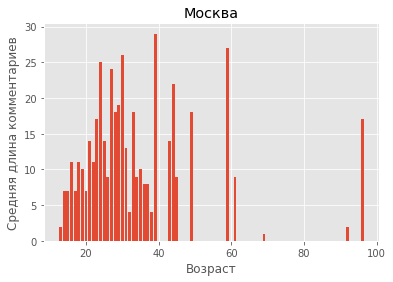

2 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 39, 41, 42, 43, 44, 45, 50, 54, 56, 59, 71] [7, 4, 5, 12, 9, 7, 9, 7, 13, 9, 10, 14, 12, 10, 16, 33, 11, 11, 10, 7, 14, 12, 4, 4, 14, 6, 10, 7, 25, 8, 1, 6, 4, 7]


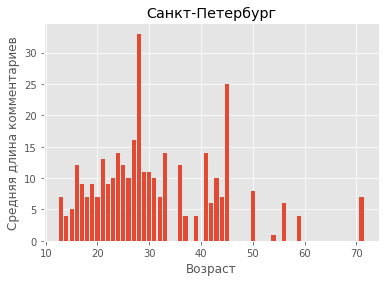

1125366 [20] [12]


282 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29] [5, 12, 2, 4, 7, 10, 51, 5, 21, 2, 3, 13, 2, 4, 11, 39]


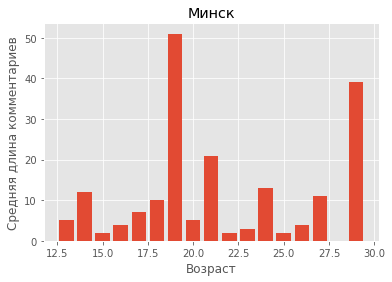

0 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 46, 50, 53, 56, 57, 64, 66, 69, 76, 97] [7, 6, 5, 9, 8, 11, 7, 12, 9, 15, 9, 10, 18, 18, 7, 13, 13, 6, 6, 14, 29, 19, 21, 4, 0, 18, 4, 41, 4, 18, 9, 27, 33, 22, 8, 13, 5, 22, 14, 16]


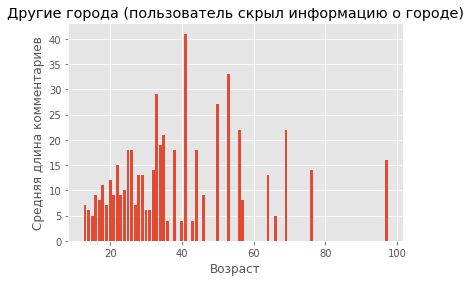

1710959 [14, 21, 35] [1, 10, 16]


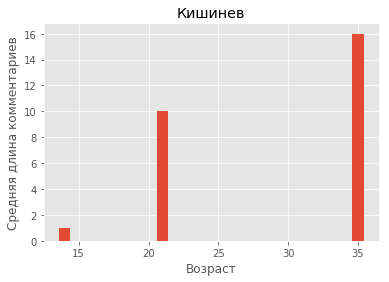

953 [] []
72 [13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 41] [3, 0, 21, 10, 9, 6, 2, 5, 9, 9, 7, 44, 5, 17, 35, 6, 14, 5, 4, 0, 17]


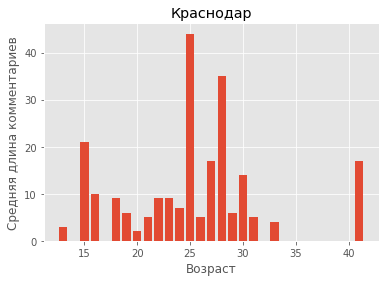

13079 [18] [6]


625 [15] [12]


62 [16, 20, 24, 33, 36] [5, 1, 5, 14, 40]


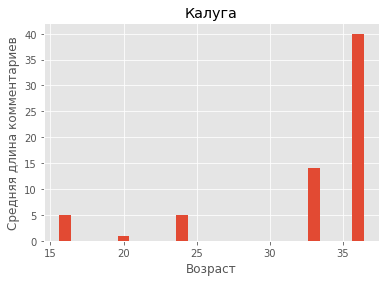

119 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 41, 47, 69, 82] [2, 2, 21, 2, 5, 5, 10, 6, 1, 3, 5, 16, 7, 13, 22, 10, 3, 17, 8, 11, 18, 10, 13, 7]


87 [14, 20, 21, 23, 24, 25, 26, 29] [7, 5, 0, 20, 24, 32, 5, 10]


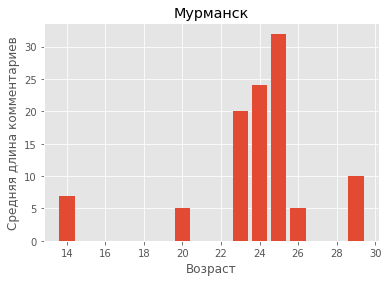

138 [15, 19, 28, 30] [6, 25, 12, 19]


60 [14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 30, 31, 32, 33, 35, 41, 42, 43] [3, 6, 67, 3, 2, 9, 6, 8, 16, 31, 20, 26, 5, 36, 9, 7, 7, 7, 4, 2, 6]


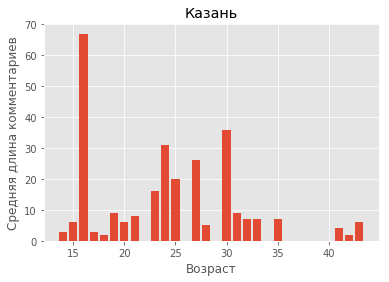

1568 [] []
143 [14, 16, 21, 26, 32, 33, 34, 46, 52] [10, 3, 2, 17, 2, 27, 14, 11, 8]


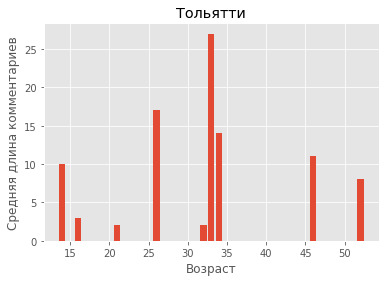

153 [15, 17, 19, 20, 21, 23, 24, 26, 27, 32] [10, 2, 4, 31, 2, 1, 13, 6, 40, 7]


69 [19, 20] [24, 9]


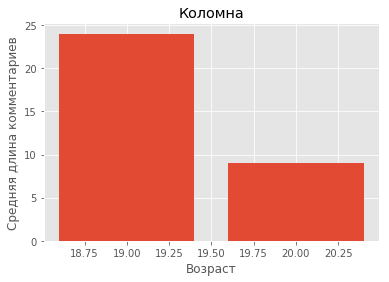

223 [13, 16, 23] [6, 4, 5]


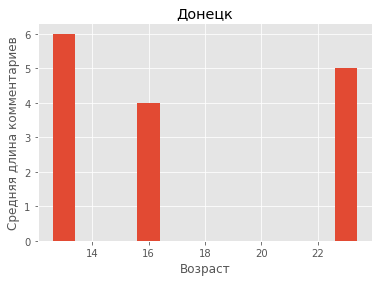

3243 [15, 17] [3, 1]


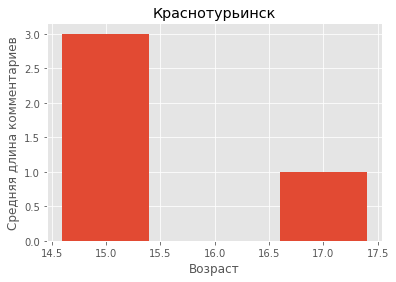

106 [13, 15, 17, 19, 28, 30, 31, 32, 40, 44] [4, 35, 10, 3, 12, 16, 12, 8, 23, 8]


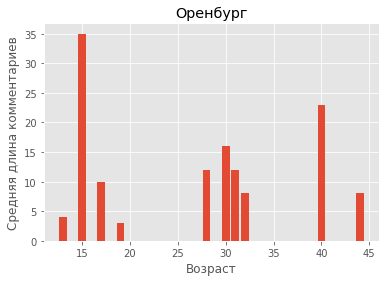

61 [14, 20, 21, 22, 26, 28, 29, 30, 31] [6, 1, 30, 12, 17, 11, 6, 4, 1]


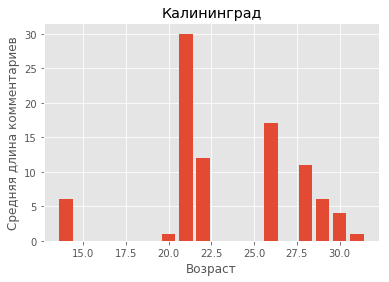

73 [14, 15, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 32, 51] [2, 7, 17, 4, 20, 12, 15, 19, 0, 4, 8, 6, 6, 6]


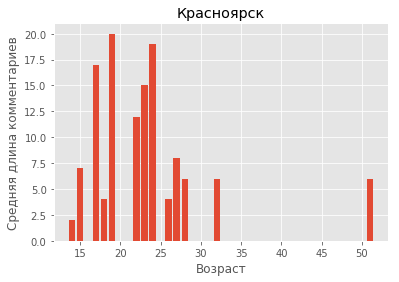

1870 [28] [0]


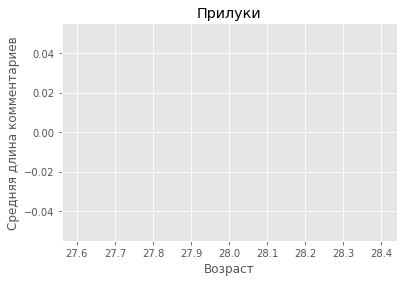

144 [15, 17, 20, 21, 27, 29, 35] [19, 4, 34, 36, 6, 18, 37]


49 [14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 34, 37, 38, 41, 43, 58] [4, 8, 7, 2, 6, 94, 19, 13, 9, 64, 23, 8, 13, 33, 13, 12, 113, 11, 4, 11, 9, 2]


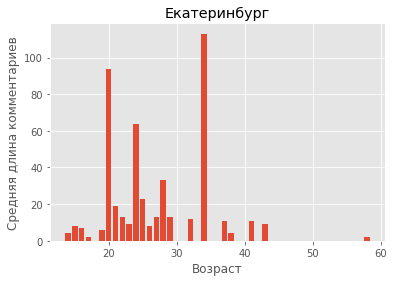

6193 [26, 44] [8, 8]


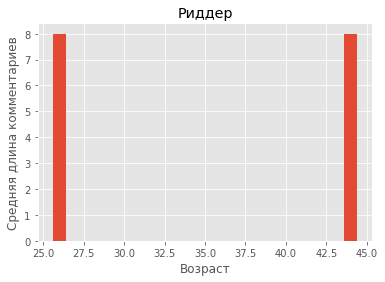

125 [14, 15, 16, 17, 19, 20, 21, 25, 26, 27, 28] [2, 5, 57, 6, 10, 73, 12, 3, 43, 8, 39]


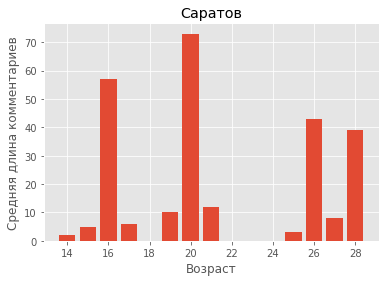

149 [14, 15, 18, 19, 20, 21, 24, 30, 31] [5, 0, 36, 6, 25, 69, 2, 9, 19]


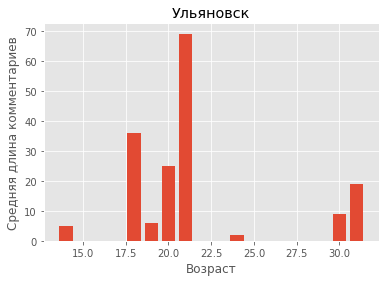

10 [13, 15, 16, 17, 20, 22, 23, 24, 25, 26] [2, 3, 2, 5, 4, 14, 16, 8, 6, 8]


115 [16] [2]


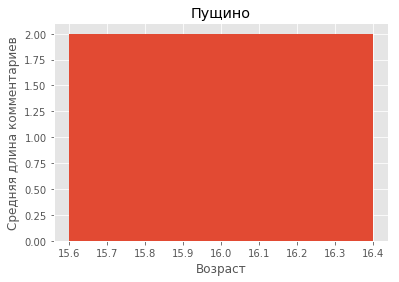

114 [14, 22, 23, 25] [12, 10, 60, 3]


95 [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 35, 39, 41, 56] [13, 2, 4, 18, 24, 8, 21, 9, 1, 9, 5, 6, 2, 24, 4, 8, 7, 5, 6, 34, 10]


924 [] []
122 [13, 14, 17, 18, 21, 22, 23, 24, 27, 31, 33] [0, 4, 3, 10, 2, 10, 5, 6, 33, 16, 3]


26 [14, 15, 16, 20, 24, 25, 28, 30, 31] [7, 7, 18, 2, 5, 5, 6, 18, 14]


649 [18, 20, 22, 29] [2, 4, 9, 10]


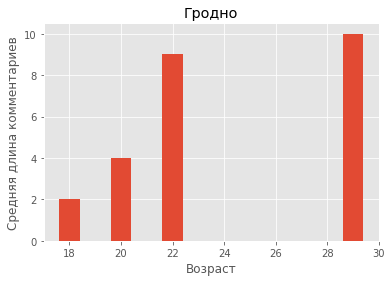

872 [23] [8]


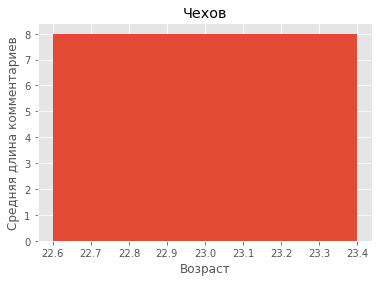

56 [14, 16, 17, 19, 20, 21, 27, 29, 30, 40, 56] [7, 3, 8, 23, 2, 8, 5, 10, 35, 2, 4]


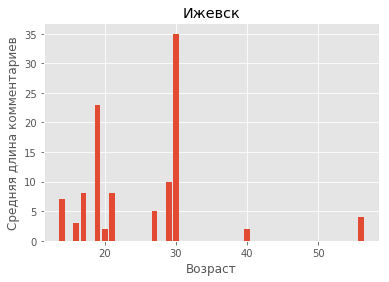

134 [15, 17, 22, 24, 27, 28, 33, 38] [6, 38, 6, 16, 11, 26, 14, 8]


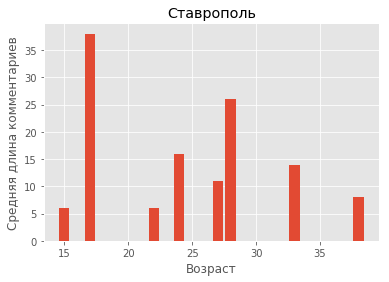

66 [13, 15, 16, 17, 19, 21, 23, 28, 31, 32, 35, 37] [2, 7, 3, 3, 10, 12, 0, 119, 26, 5, 3, 0]


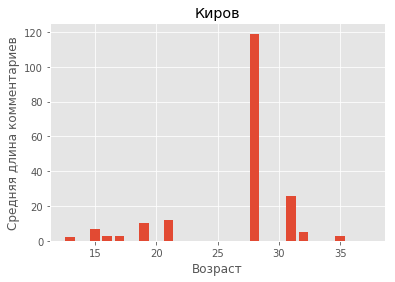

691 [] []
392 [20, 21, 23, 25, 28] [8, 4, 17, 4, 7]


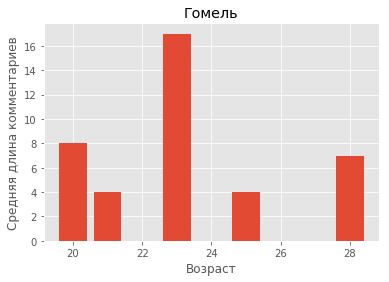

6547 [] []
6913 [26] [17]


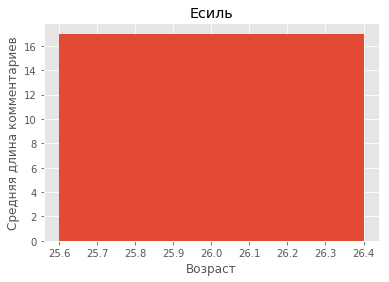

25 [17, 18, 20, 21, 22, 23, 26, 27] [4, 0, 7, 0, 48, 12, 6, 29]


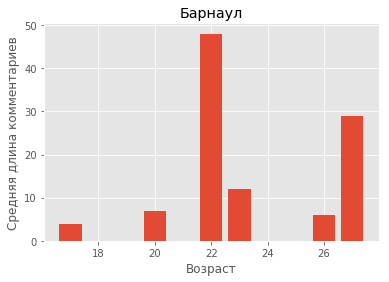

5266940 [] []
40 [18, 26] [4, 24]


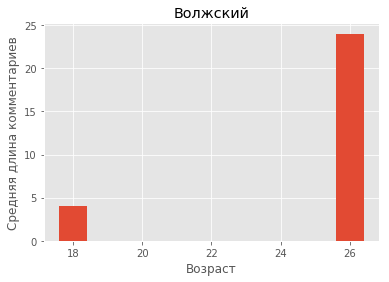

14 [14, 19, 23, 24, 26] [5, 4, 16, 9, 9]


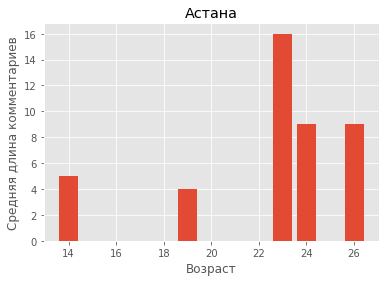

807 [18, 29] [14, 14]


16706 [] []
104 [13, 14, 15, 16, 17, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 40] [1, 4, 8, 1, 6, 14, 4, 2, 9, 6, 39, 4, 10, 4, 78, 3, 5, 18]


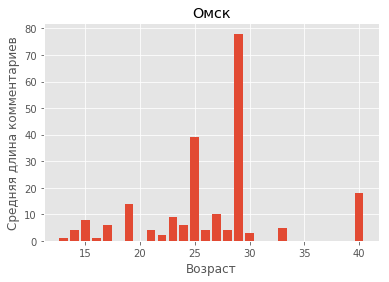

455 [] []
722 [28, 31, 35] [5, 0, 4]


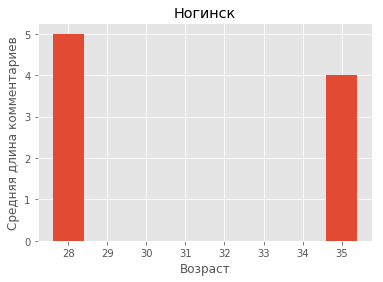

1006 [] []
522 [17, 24] [8, 3]


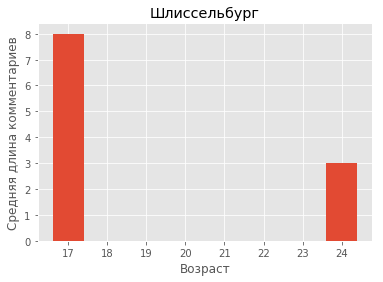

168 [15] [5]


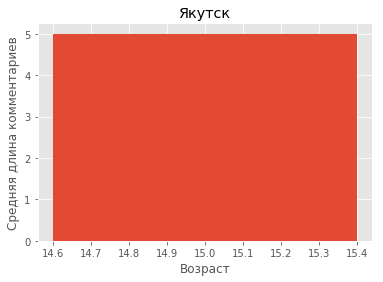

1809 [13, 17, 18] [3, 35, 9]


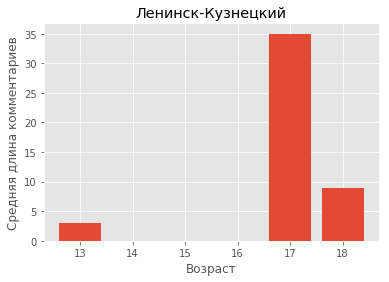

1707883 [] []
9014 [25] [15]


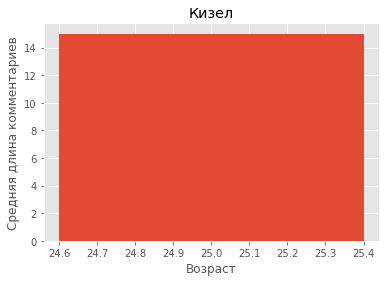

552 [21, 23, 59] [8, 1, 2]


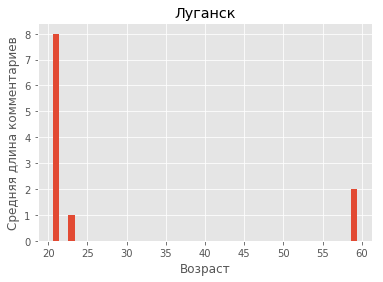

314 [13, 14, 15, 16, 17, 21, 27] [2, 2, 4, 1, 0, 0, 4]


108 [] []
8698 [23] [6]


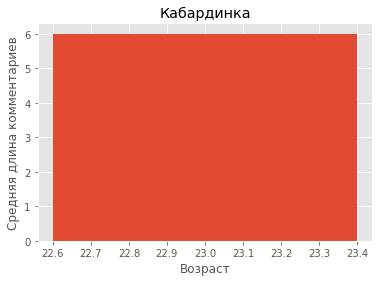

2131 [] []
17229 [] []
1715161 [17] [8]


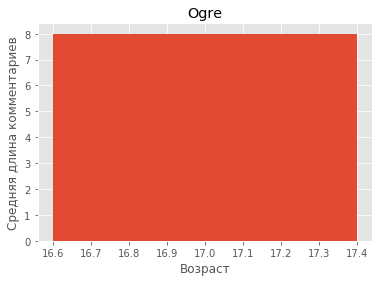

1386 [19, 21, 48] [0, 2, 13]


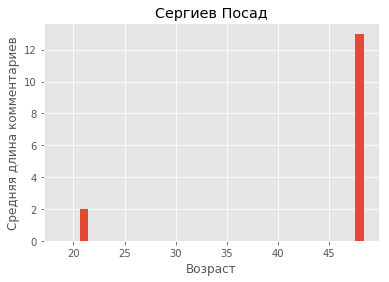

146 [15, 20, 21, 22, 23, 25, 26, 27, 30, 33, 34, 35] [7, 0, 21, 4, 3, 21, 2, 4, 8, 9, 29, 15]


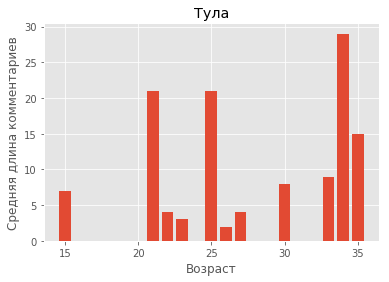

123 [14, 15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 31, 32] [2, 8, 2, 26, 7, 16, 8, 8, 25, 24, 18, 31, 44, 3, 3]


12157 [] []
169 [13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 32, 33, 35, 43, 58] [2, 5, 5, 14, 3, 24, 5, 9, 15, 2, 4, 20, 11, 5, 4, 10, 19, 6, 6, 12]


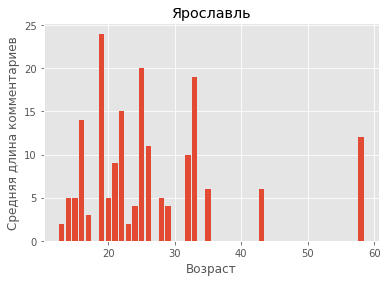

93 [21, 23] [42, 2]


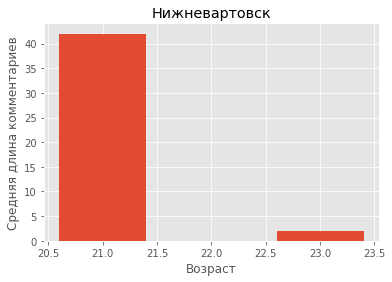

110 [13, 15, 16, 17, 18, 21, 25, 28, 29, 84] [2, 20, 6, 5, 6, 6, 11, 3, 11, 12]


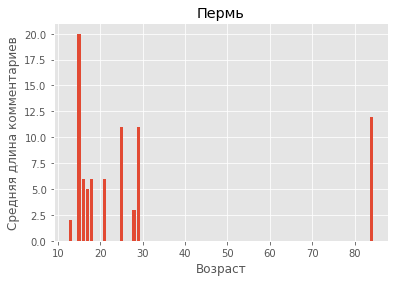

1128228 [] []
468 [26, 27] [5, 5]


96 [14, 17, 18, 42] [3, 6, 20, 9]


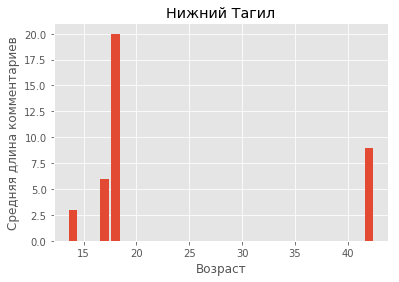

151 [13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31] [1, 3, 5, 7, 4, 9, 5, 4, 4, 3, 6, 13, 22, 3, 1, 11]


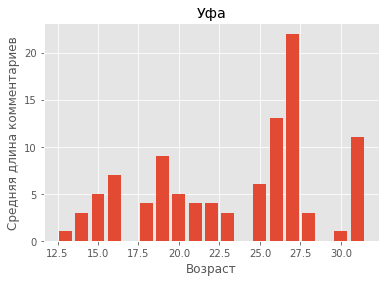

1032 [25, 34] [6, 5]


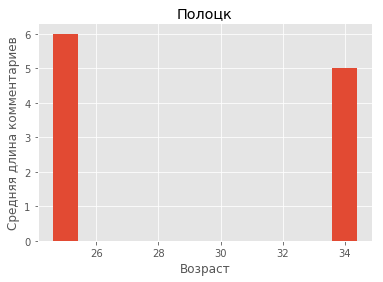

196 [] []
18065 [] []
1517767 [22] [4]


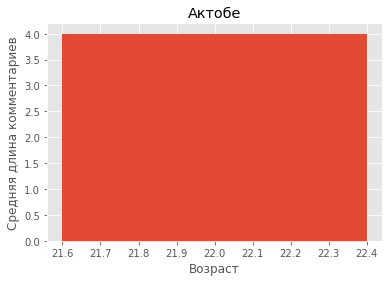

80 [20, 22, 79] [7, 9, 1]


20299 [16] [6]


467 [15] [6]


159 [24] [11]


413 [14, 22] [5, 7]


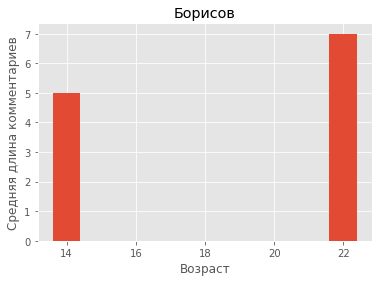

99 [13, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36] [4, 5, 11, 7, 44, 2, 5, 0, 1, 18, 6, 23, 12, 26, 8, 3, 9, 50, 8]


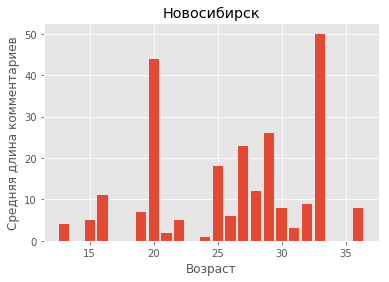

264 [14, 23] [3, 9]


57 [18, 21, 22, 27, 45] [4, 1, 29, 20, 14]


1161144 [17] [2]


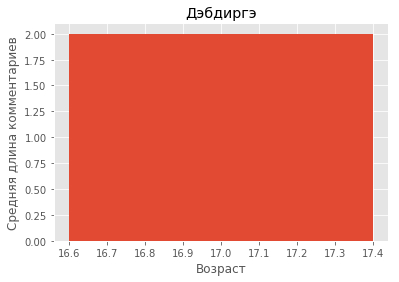

136 [14, 16, 18, 30, 36] [4, 4, 14, 23, 32]


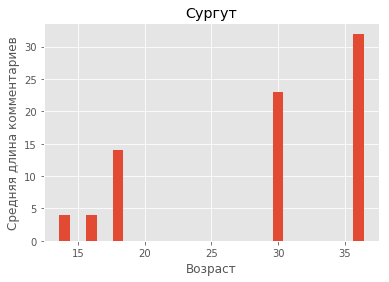

2118 [24] [8]


183 [14, 18, 19, 21, 22, 23, 25, 26, 30] [29, 21, 2, 18, 1, 8, 7, 1, 5]


42 [13, 14, 15, 16, 19, 21, 23, 25, 27, 29, 30, 37, 44] [4, 4, 1, 17, 3, 10, 2, 18, 16, 18, 18, 14, 47]


22 [15, 18, 20, 22, 28, 33, 44] [6, 5, 6, 7, 7, 0, 15]


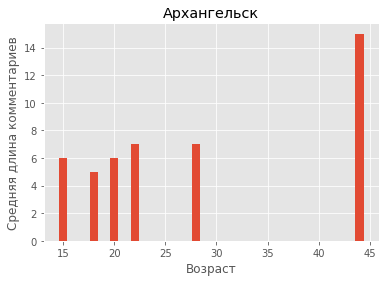

243 [15, 20, 41] [52, 7, 2]


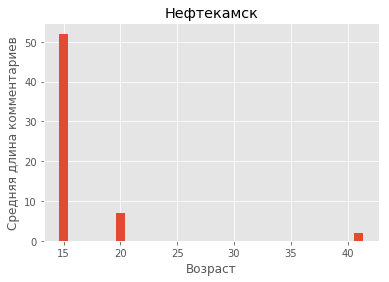

1142498 [] []
33 [14, 15, 16, 18, 19, 20, 26, 28, 30] [3, 3, 1, 23, 3, 1, 3, 28, 14]


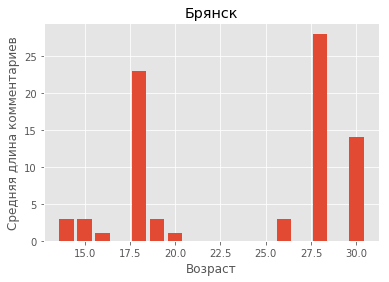

9930 [20, 21, 29, 54] [5, 23, 16, 0]


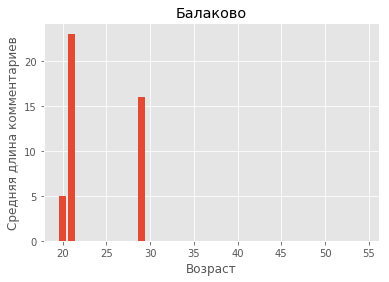

147 [14, 15, 16, 18, 20, 21, 22, 23, 24, 26, 27, 29, 33] [9, 3, 4, 4, 5, 9, 3, 4, 64, 15, 12, 9, 9]


2391 [] []
132 [18, 27] [10, 3]


3992 [15, 36] [1, 28]


158 [14, 15, 16, 18, 20, 21, 22, 24, 25, 26, 27, 28, 32, 33, 39, 40, 42] [4, 7, 7, 8, 6, 36, 12, 6, 4, 30, 9, 4, 5, 15, 2, 3, 14]


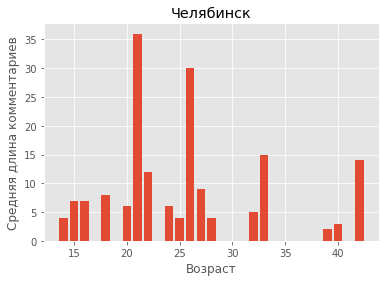

8105 [27] [10]


34 [20] [1]


20 [24, 33] [7, 26]


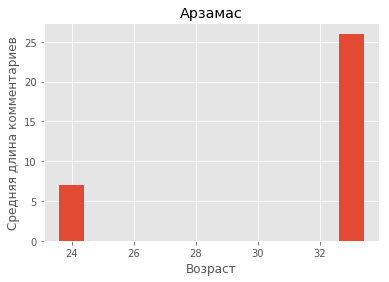

88 [14, 16, 19, 24, 26, 28, 29] [7, 4, 4, 3, 0, 7, 6]


1178 [13] [12]


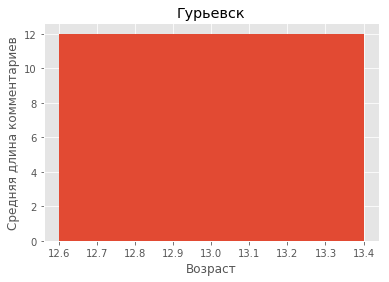

133 [14, 15, 17, 18, 24, 26, 27, 37] [6, 8, 2, 7, 4, 12, 11, 6]


709 [20, 94] [19, 4]


1084989 [15] [6]


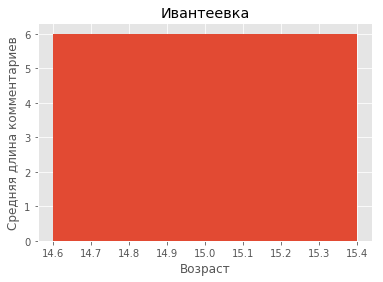

2001 [40, 52] [60, 2]


51 [13, 17, 21, 25] [2, 7, 22, 13]


1489 [18, 23] [10, 12]


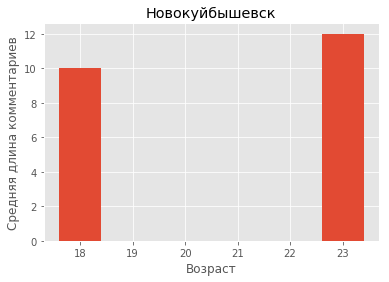

7279 [15, 25] [11, 13]


1057089 [24] [3]


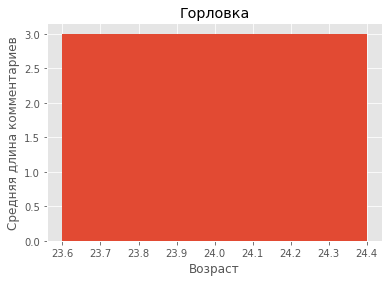

185 [15, 22, 23, 27, 33] [2, 13, 20, 12, 37]


730 [] []
75 [13, 14, 15, 16, 18, 19, 23, 25, 27, 31] [3, 4, 5, 3, 8, 5, 33, 16, 12, 1]


11701 [26] [11]


1713816 [] []
64 [14, 16, 18, 25, 26, 28, 29] [3, 0, 2, 5, 14, 20, 14]


627 [16, 19, 20, 23] [2, 2, 7, 8]


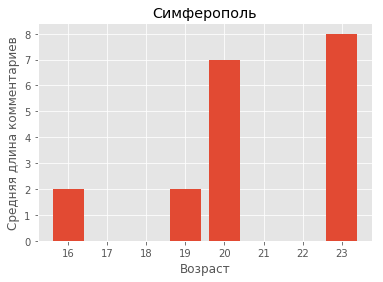

1704157 [] []
135 [14, 16, 18, 20, 21, 22, 26, 30] [10, 4, 5, 3, 17, 6, 1, 12]


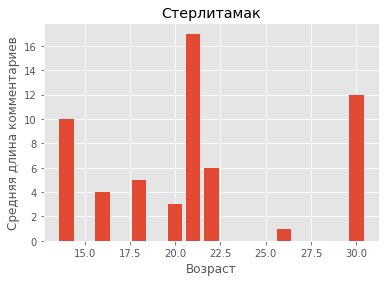

21050 [] []
1463 [20, 26, 29, 31] [2, 19, 4, 3]


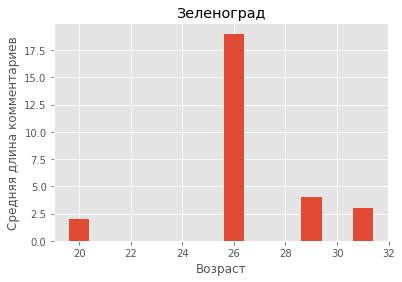

97 [13, 14, 16, 18, 21, 22, 24, 28, 39] [5, 2, 2, 3, 7, 6, 4, 12, 25]


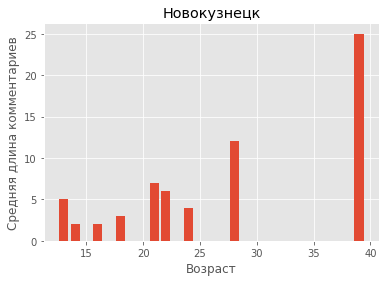

82 [13, 14, 15, 19, 23, 28, 48] [17, 6, 6, 9, 15, 7, 1]


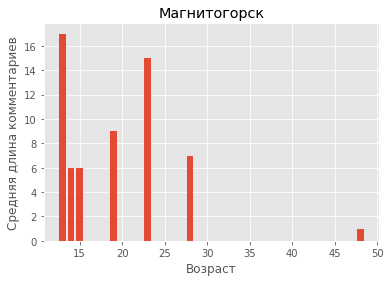

107 [13, 21, 25, 27] [1, 73, 9, 6]


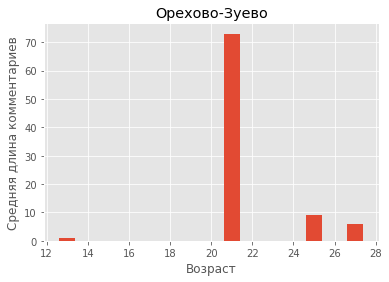

74 [15, 21, 23, 24, 33] [2, 1, 4, 6, 18]


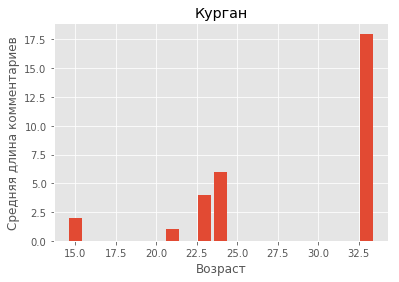

1469 [15, 26, 28, 42] [7, 28, 2, 4]


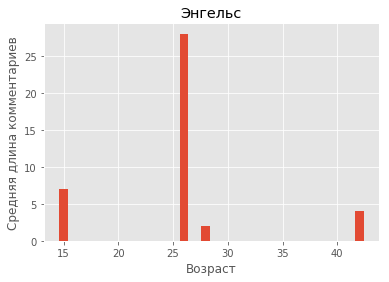

152 [] []
270 [17, 18, 19, 20, 27, 43] [4, 4, 6, 26, 24, 10]


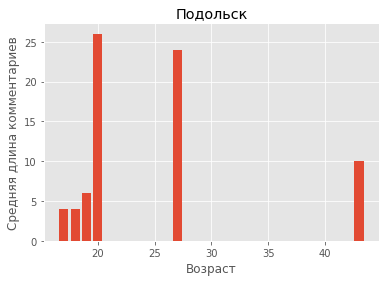

44 [20, 27] [3, 7]


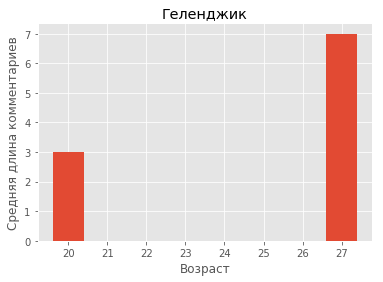

967 [] []
35 [16, 19, 20, 23, 26, 27, 29, 30, 31, 38, 55] [5, 2, 20, 18, 3, 9, 6, 2, 5, 22, 37]


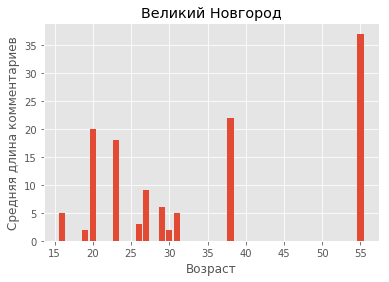

141 [14, 15, 19, 22, 32, 35] [19, 3, 3, 4, 40, 6]


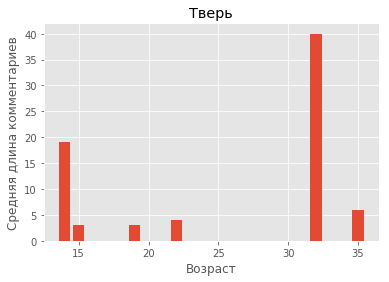

1951986 [] []
103 [32] [0]


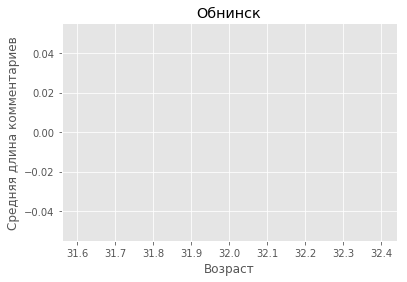

204 [22, 26] [0, 9]


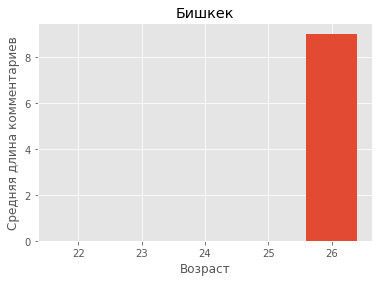

157 [14, 16, 18] [2, 3, 1]


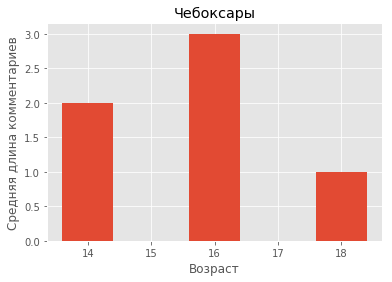

109 [13, 14, 15, 19, 20, 21, 22, 26, 27, 28, 33] [7, 3, 2, 3, 6, 75, 9, 1, 12, 22, 11]


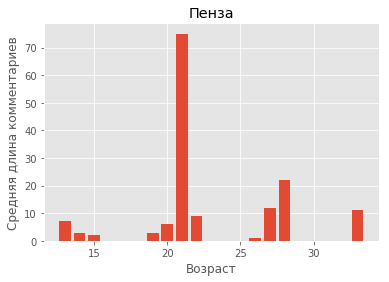

3579 [17] [10]


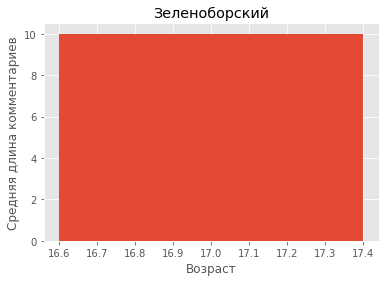

155 [19, 22, 26, 47] [5, 8, 18, 12]


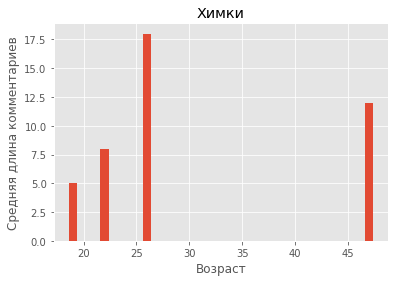

6923 [19, 20] [1, 8]


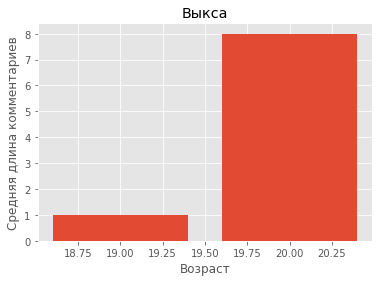

281 [15, 20, 27, 28] [2, 2, 19, 4]


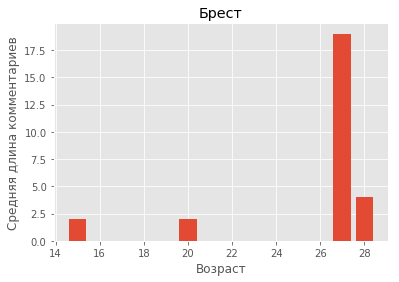

71 [16, 21, 22, 32, 36] [2, 28, 3, 3, 24]


3858 [14, 23] [5, 11]


37 [14, 15, 16, 19, 20, 21, 22] [4, 0, 2, 7, 1, 3, 2]


652 [] []
1966 [14, 21] [5, 4]


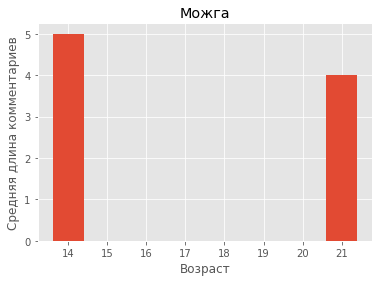

991 [26] [3]


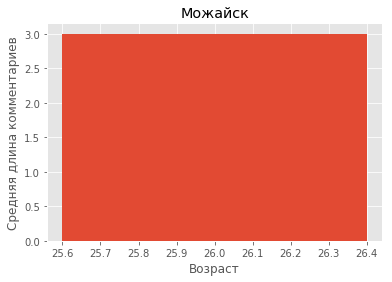

139 [15, 24, 26, 30, 31] [1, 6, 3, 22, 15]


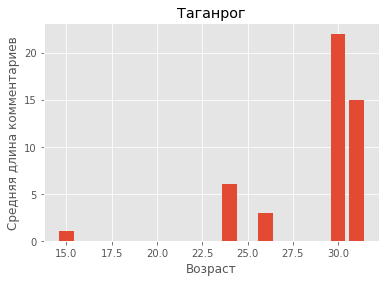

2106 [15] [3]


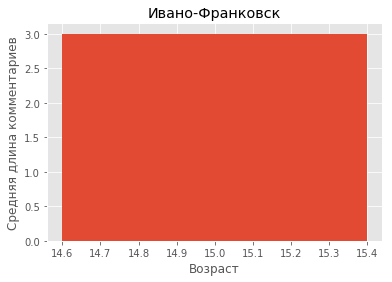

1953391 [21] [8]


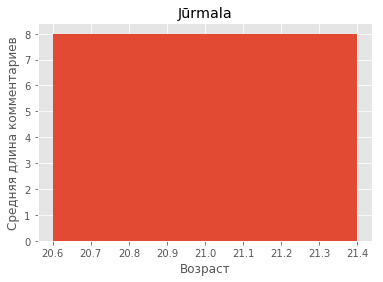

3837115 [15] [18]


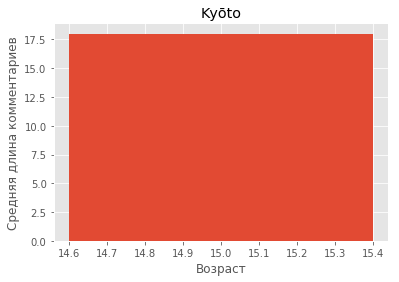

5331 [16, 17, 19, 26, 27] [2, 2, 4, 21, 0]


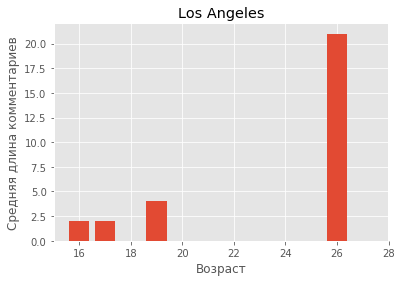

5689 [16, 23] [41, 12]


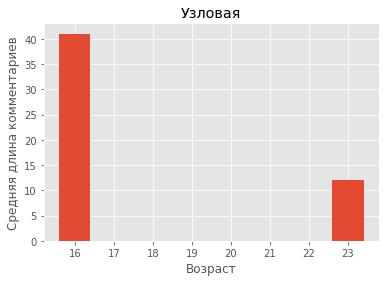

124 [14, 17, 19, 20, 24, 25, 29] [6, 5, 23, 0, 15, 26, 4]


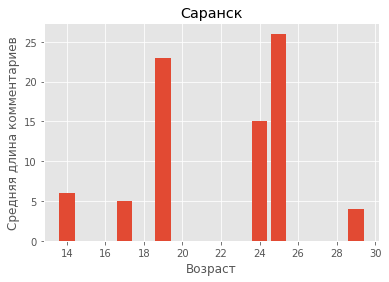

964 [] []
5375783 [] []
628 [15] [5]


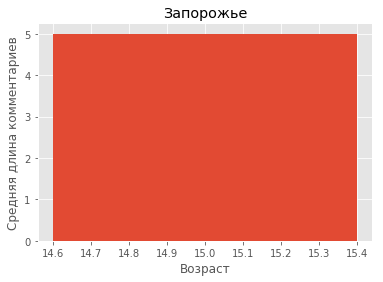

244 [13, 15, 17, 21, 29, 30] [7, 3, 8, 1, 8, 8]


6594 [] []
112 [14, 16, 17, 23, 30, 45, 56, 74] [13, 2, 2, 5, 4, 9, 6, 5]


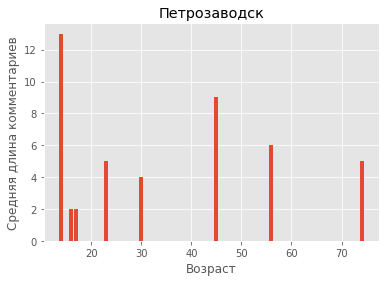

1475 [] []
27 [15] [6]


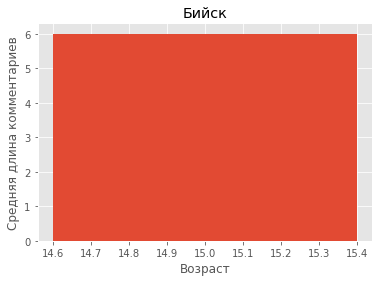

295 [14, 15, 27] [2, 4, 5]


1702304 [] []
1932468 [31] [2]


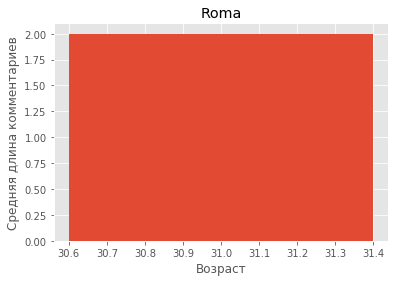

848 [15] [40]


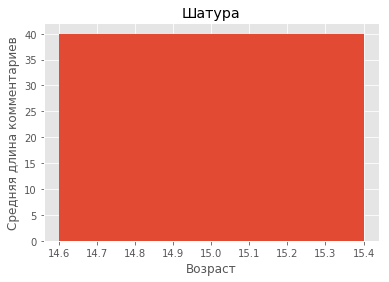

1311 [14, 23] [7, 6]


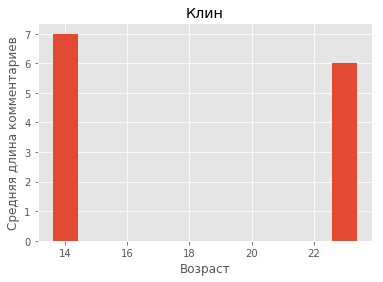

20157 [14] [4]


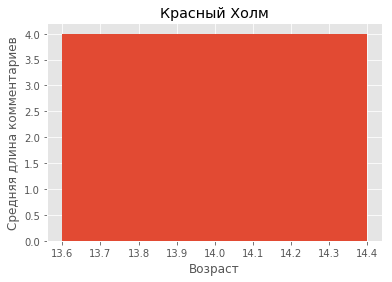

21244 [32] [5]


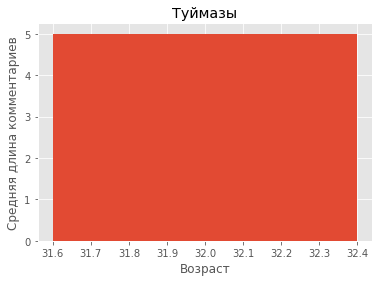

12988 [] []
1573 [19, 30] [4, 1]


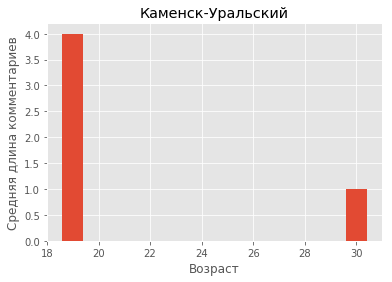

706 [15, 17, 23, 34] [8, 18, 3, 14]


23 [16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27] [2, 3, 4, 1, 23, 6, 13, 6, 2, 12, 13]


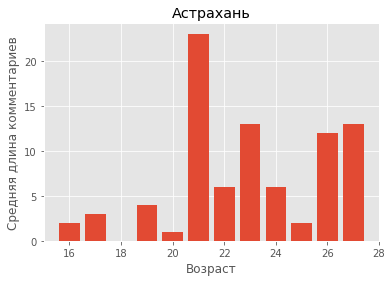

899 [16, 20, 26] [12, 6, 7]


98 [15, 16, 19, 22, 23, 28, 33] [2, 5, 4, 5, 12, 1, 36]


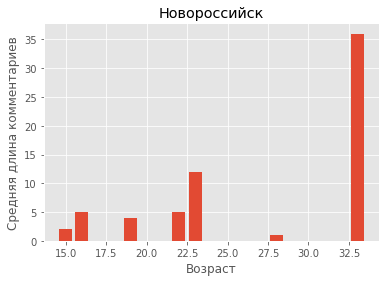

8171 [14, 19] [29, 7]


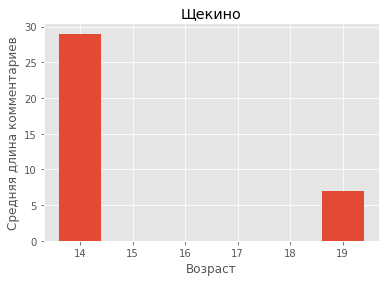

1712003 [14, 16] [1, 4]


17 [18, 22, 31] [3, 4, 3]


11 [21, 23, 29, 31] [1, 1, 5, 1]


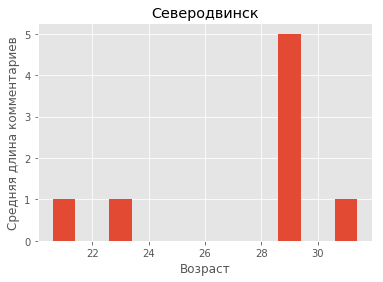

2747 [15] [1]


52 [] []
8 [22, 25, 27, 28, 31, 40] [5, 27, 3, 11, 4, 15]


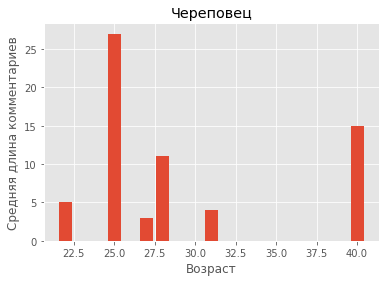

11722 [] []
376 [] []
1113 [15, 27] [6, 1]


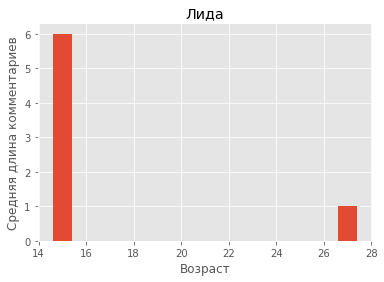

1519 [17, 33] [4, 15]


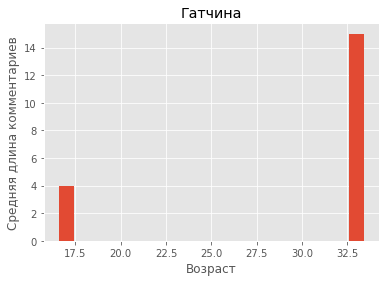

177 [41] [11]


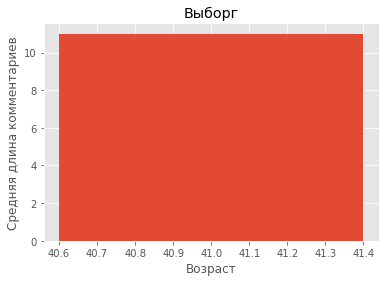

830 [15] [2]


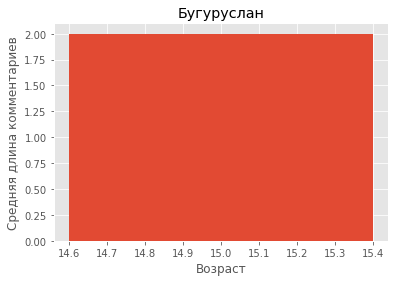

472 [] []
311 [14] [9]


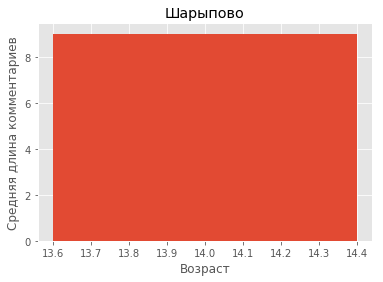

340 [25] [20]


53 [15, 35] [2, 3]


1050378 [] []
7159 [47] [12]


8267 [] []
1147872 [] []
2040 [] []
378 [16, 25] [5, 1]


78 [13, 14, 15, 21, 22, 23, 24, 25, 26, 28, 29, 34] [18, 7, 4, 0, 7, 15, 17, 9, 3, 16, 19, 4]


1100204 [] []
59 [14, 15, 16, 18, 21, 22, 24, 25, 27, 32, 33, 37, 38] [10, 8, 3, 44, 62, 13, 16, 22, 5, 24, 3, 1, 46]


3404 [] []
1017 [19] [3]


1937764 [14, 15, 16] [1, 3, 2]


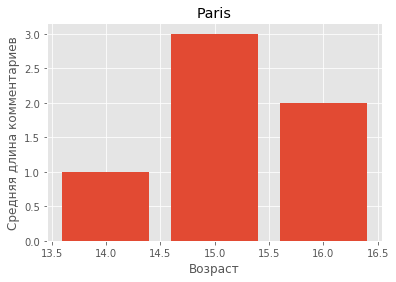

1709165 [16] [1]


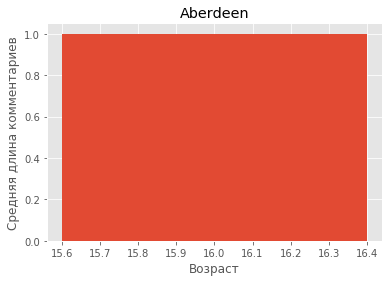

1901501 [20] [1]


460 [] []
1702139 [] []
321 [22] [18]


1701761 [] []
2544 [15, 19] [20, 7]


1602105 [] []
197 [27, 37] [22, 21]


1704959 [] []
91 [] []
8162 [] []
9836 [] []
140 [13, 16, 17, 18, 20, 22, 23, 24, 28, 30, 36] [1, 6, 2, 8, 3, 2, 11, 0, 12, 0, 24]


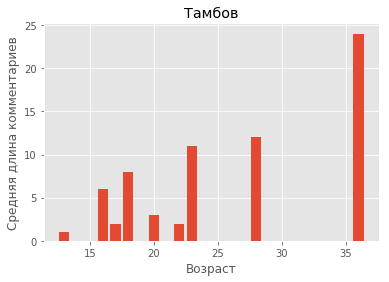

1055710 [] []
3425 [14] [2]


148 [20, 23, 24, 29] [3, 22, 5, 3]


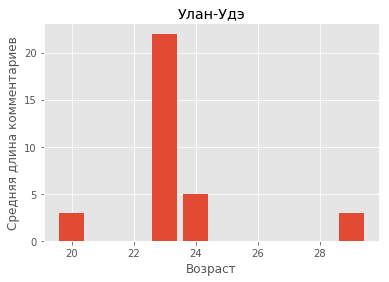

55 [15, 16, 18, 27, 28, 30] [11, 3, 7, 13, 15, 3]


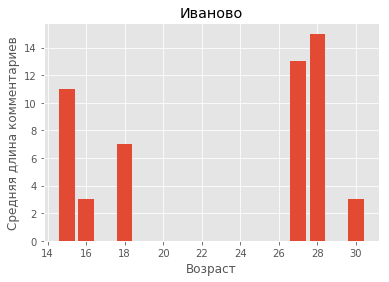

1545 [] []
1908812 [14] [0]


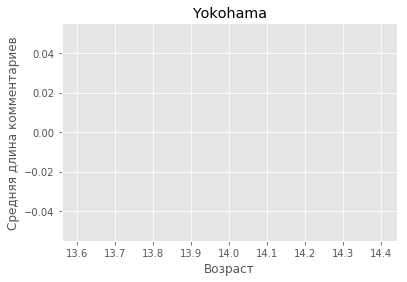

2615 [] []
1083 [] []
1192 [] []
1965294 [26, 27] [0, 0]


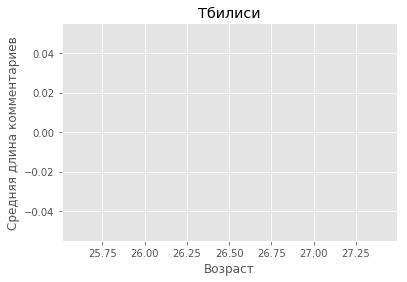

30 [17, 26] [4, 12]


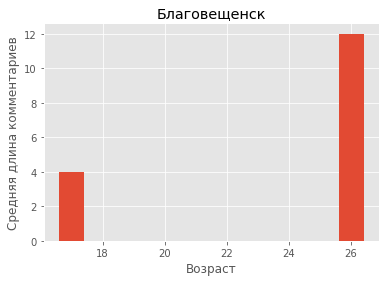

704 [] []
1016530 [] []
1011858 [15] [1]


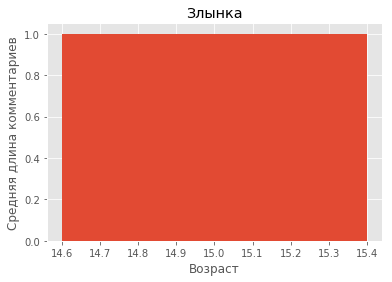

941 [19, 30, 33] [23, 8, 6]


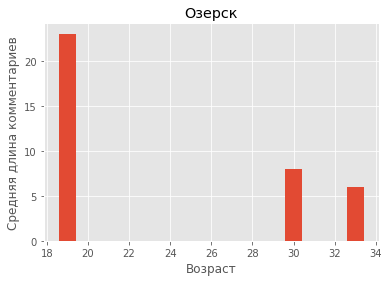

13181 [18] [1]


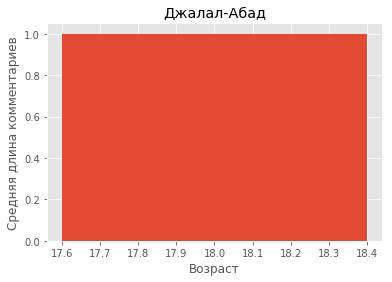

164 [14, 18, 20, 21, 24, 27, 36] [27, 2, 10, 2, 0, 3, 7]


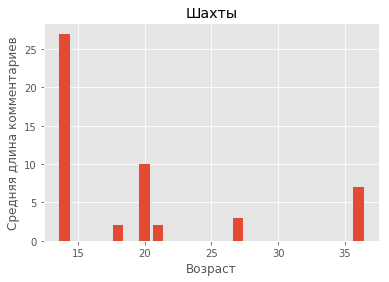

31 [] []
130 [17, 20, 21, 22, 26, 27, 30, 34] [7, 6, 39, 6, 10, 13, 4, 2]


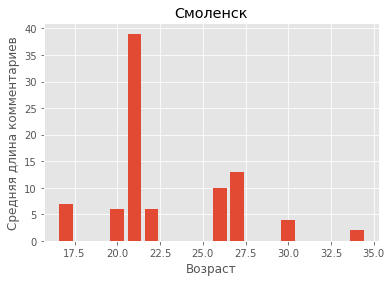

14876 [] []
2262 [] []
1901378 [] []
1813 [] []
1100 [15, 20, 32] [2, 1, 0]


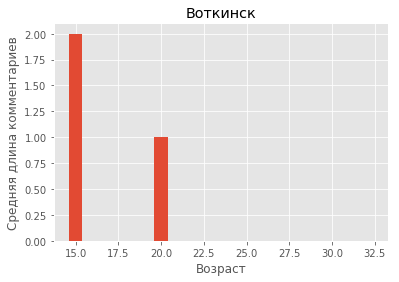

562 [28] [10]


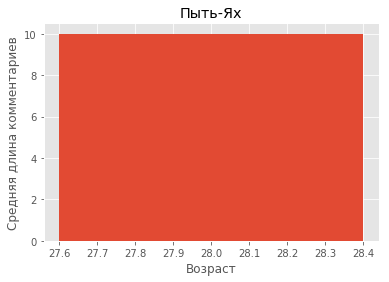

13629 [] []
1902562 [] []
2277 [] []
3156 [50] [10]


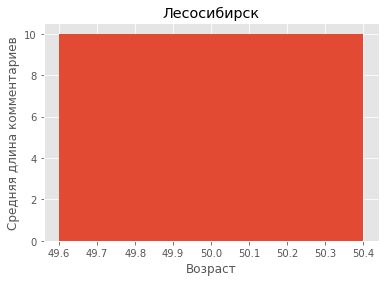

728 [19] [24]


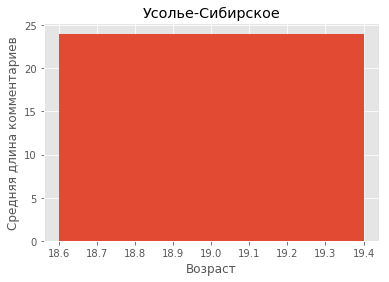

952 [25] [9]


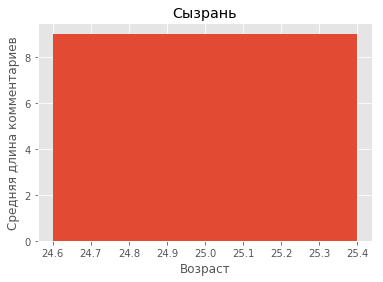

163 [14] [6]


536 [20, 23, 35] [9, 3, 7]


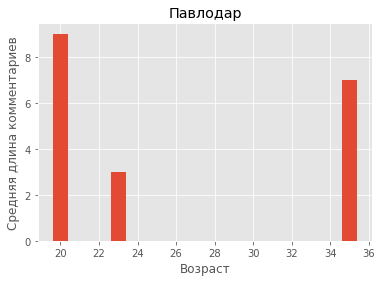

9730 [] []
10310 [20] [10]


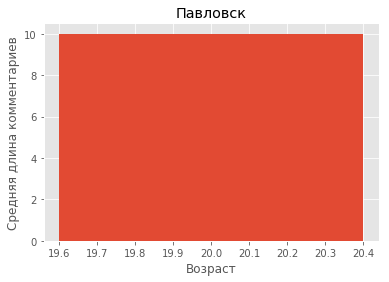

1905639 [] []
859 [15, 32] [2, 42]


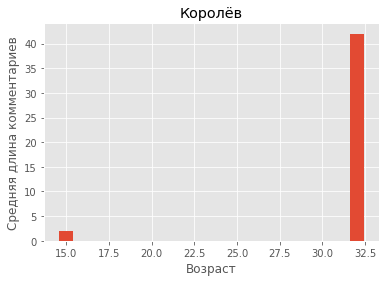

458 [18, 20] [3, 3]


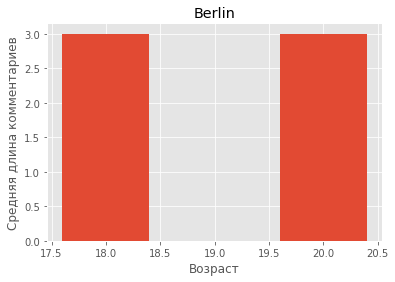

2630 [] []
20558 [] []
284 [30] [16]


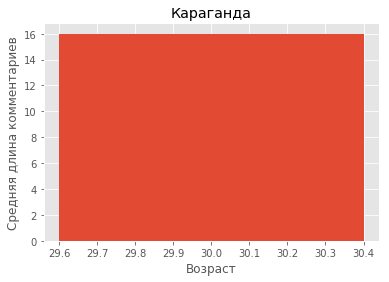

101 [13, 14, 20, 22, 27] [1, 8, 4, 7, 18]


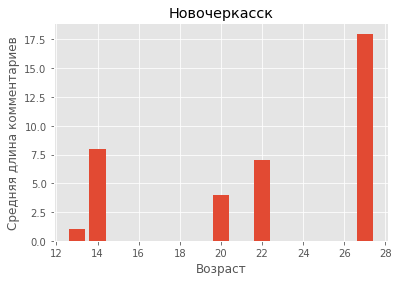

19 [33] [12]


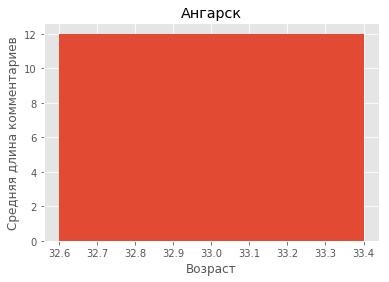

8542 [14] [0]


3700 [15, 17, 20] [4, 2, 8]


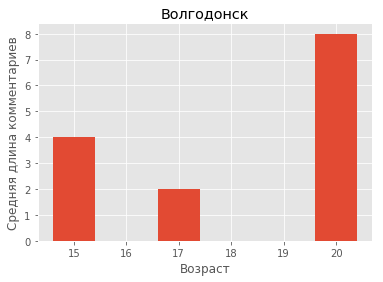

2451 [14] [7]


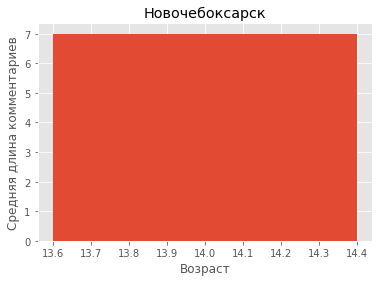

8780 [] []
105 [15, 18, 25, 27, 32] [4, 1, 8, 9, 1]


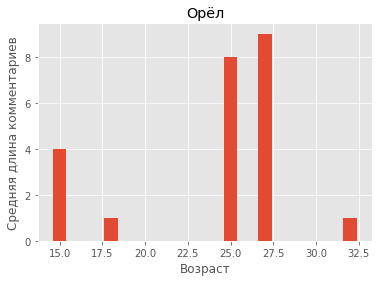

1008607 [19] [4]


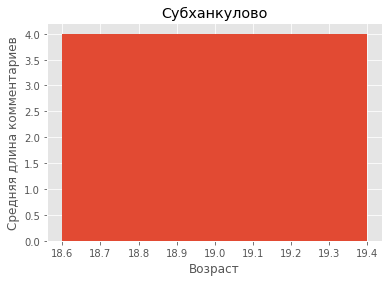

1268 [] []
2745 [] []
9 [] []
762 [] []
70 [15, 16, 25] [67, 1, 12]


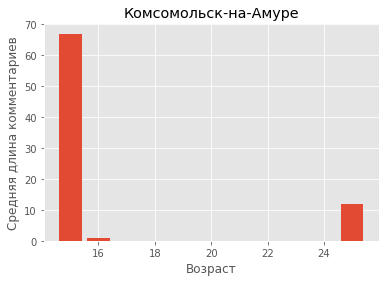

4655 [] []
172 [25] [0]


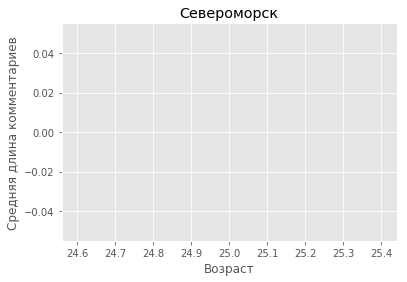

100 [32] [25]


1801744 [] []
4590 [24] [2]


354 [14, 21, 23, 27] [7, 5, 19, 4]


1035195 [15, 16] [5, 8]


1500567 [] []
353 [14] [3]


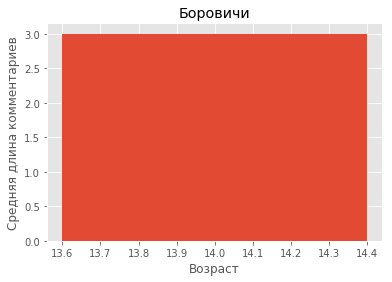

175 [27] [2]


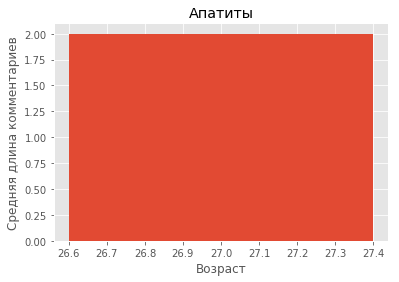

5266331 [] []
1908458 [] []
20436 [] []
1186 [14, 17, 19] [1, 0, 18]


1483 [13, 29, 31, 39] [12, 24, 7, 7]


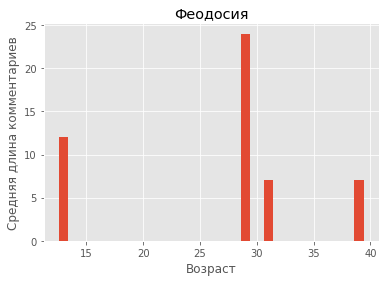

12690 [30] [4]


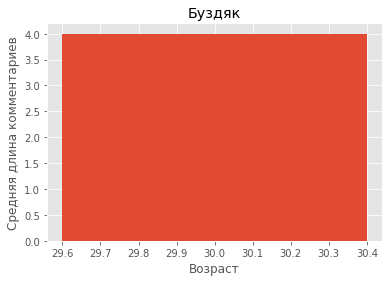

650 [] []
85 [14, 19, 22] [15, 5, 19]


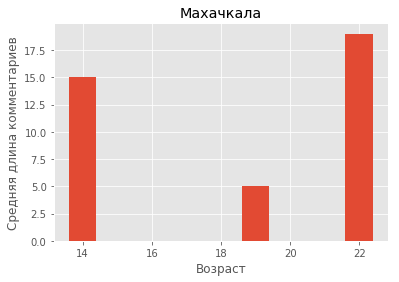

1107 [15, 26, 50] [1, 34, 3]


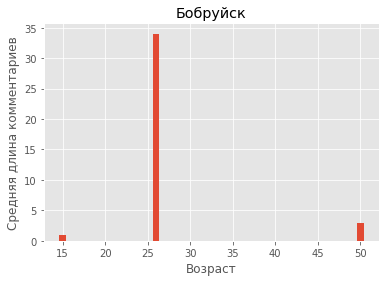

5265529 [] []
4183 [] []
9519 [14] [1]


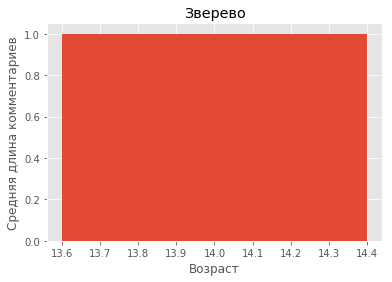

801 [23] [11]


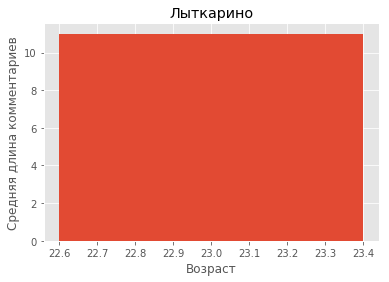

1112759 [14] [6]


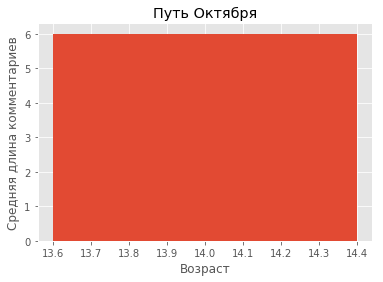

1097476 [32] [11]


11442 [] []
1114498 [] []
6890 [] []
274 [24, 25] [3, 0]


76 [27] [6]


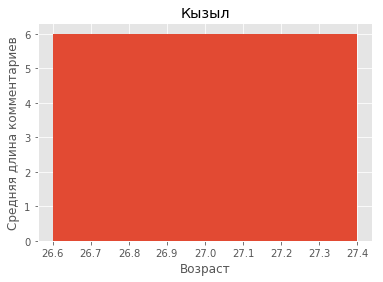

7785 [] []
7167 [25] [0]


2292 [14] [5]


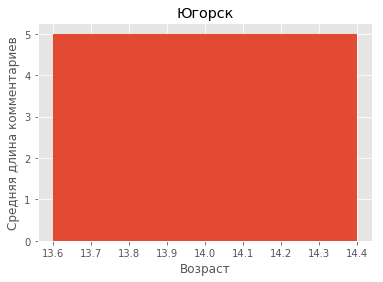

166 [14, 26, 34] [2, 5, 22]


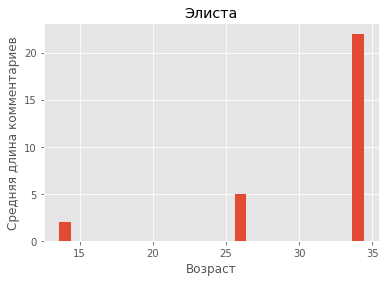

1925340 [16, 19, 23] [7, 34, 33]


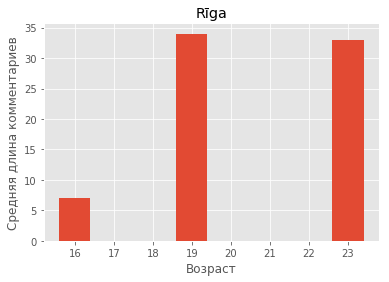

15216 [] []
1000652 [] []
1036 [] []
17583 [28] [10]


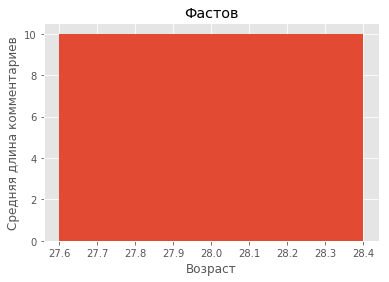

1167 [15] [4]


1300 [16] [4]


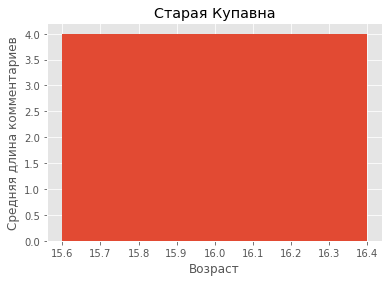

3193 [19, 25] [2, 15]


15377 [] []
1937062 [14, 20] [7, 9]


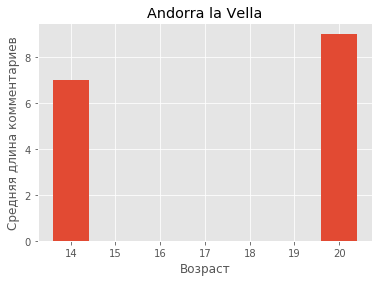

1074996 [] []
7068 [] []
1174 [30] [13]


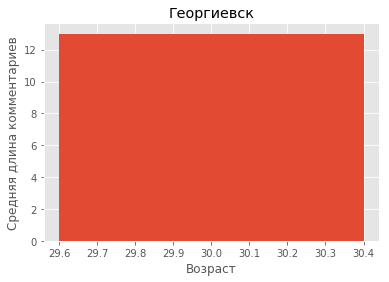

12126 [] []
11234 [] []
8139 [] []
1908479 [] []
350 [] []
420 [] []
41 [13, 14, 15, 19, 20, 21, 28] [4, 8, 3, 7, 29, 11, 27]


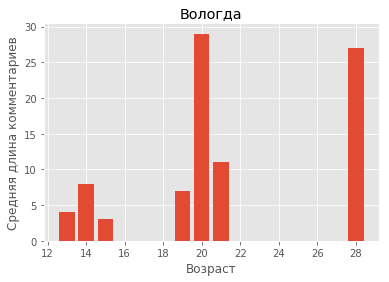

794 [15] [2]


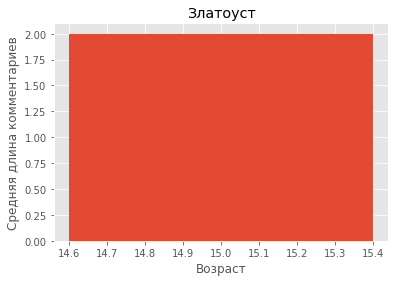

1661 [] []
1957236 [17, 32] [2, 18]


2805 [15] [10]


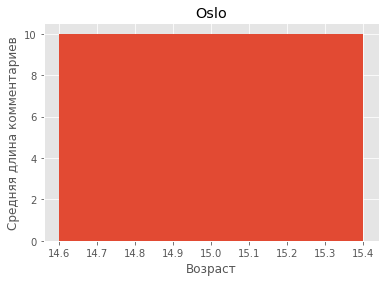

906 [] []
1140182 [] []
1036713 [] []
276 [17] [1]


2581 [] []
1907322 [19] [1]


1043097 [16] [3]


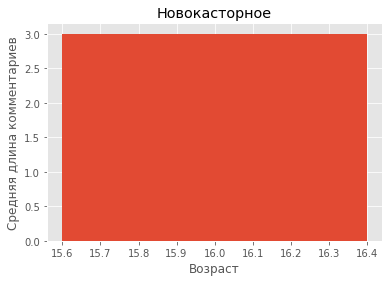

4890 [16, 21, 27] [6, 4, 53]


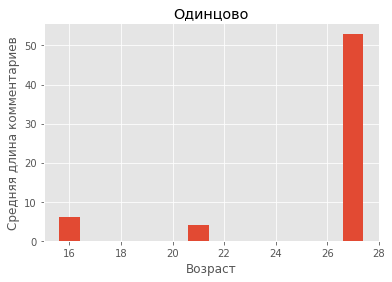

3244 [17] [10]


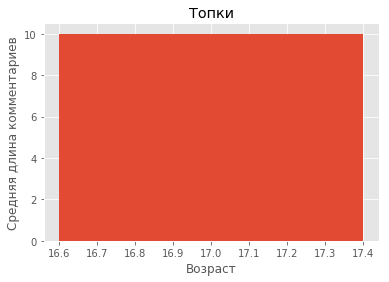

121 [21] [17]


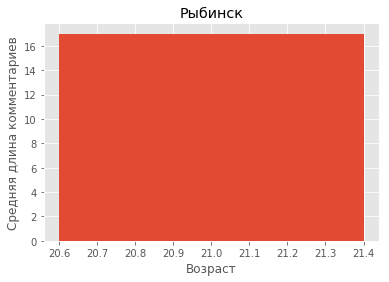

910 [20] [23]


1037 [24] [7]


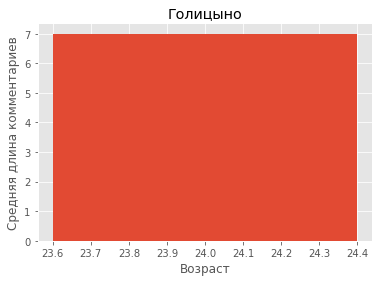

1129071 [28] [2]


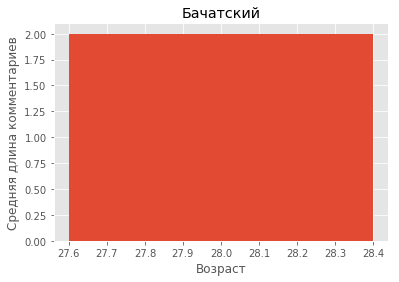

1063878 [] []
2079 [17] [1]


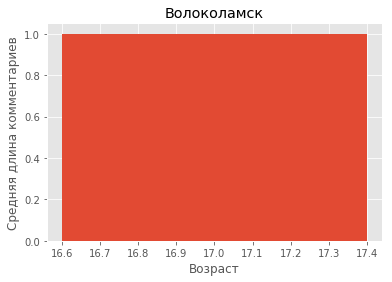

1009154 [45] [12]


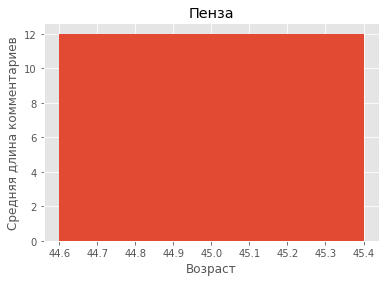

1063142 [] []
1959511 [19] [12]


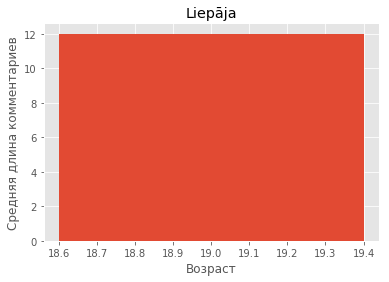

398 [14, 27] [3, 5]


39 [14, 15, 16, 26, 39] [3, 12, 5, 4, 1]


580 [27, 29] [7, 6]


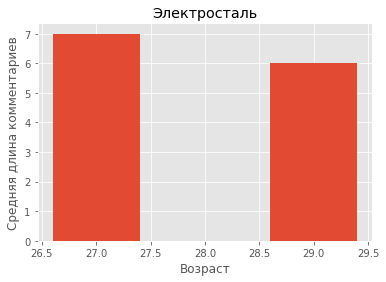

5835 [] []
317 [14] [0]


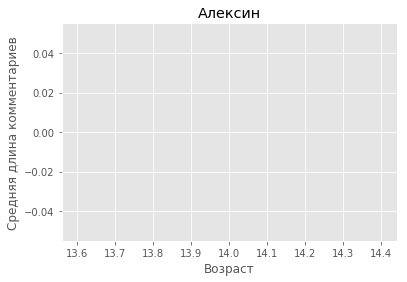

14867 [31] [0]


516 [] []
266 [34] [14]


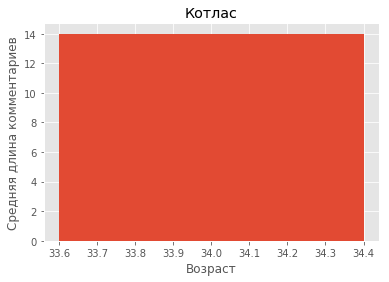

5185 [23] [3]


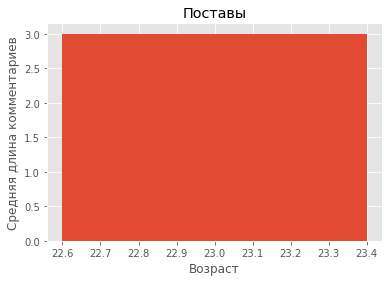

22437 [] []
374 [18] [20]


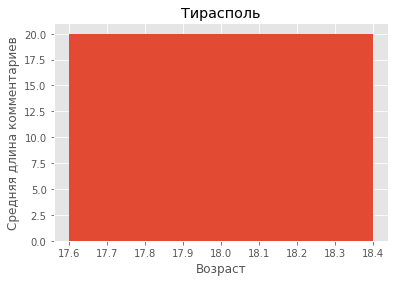

1998 [21, 26] [1, 1]


17260 [14] [1]


1910746 [24] [48]


1715378 [23] [8]


22168 [14, 16] [2, 100]


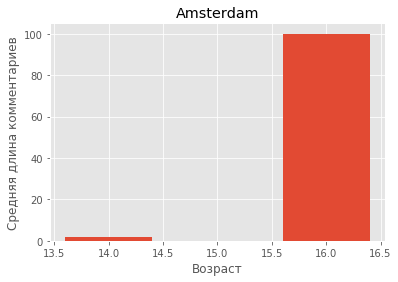

113 [27] [19]


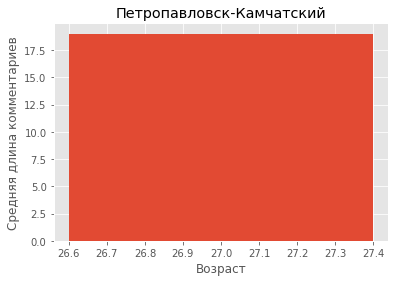

8045 [27] [13]


12148 [15] [13]


12060 [14] [2]


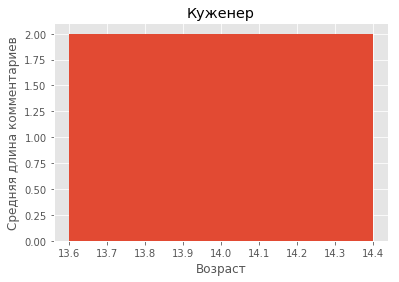

1930 [14, 23] [4, 8]


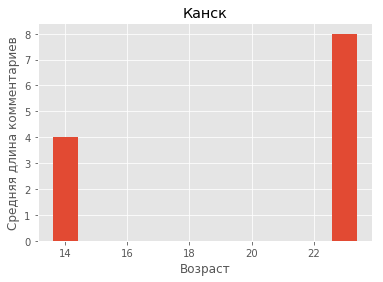

280 [18, 31] [0, 4]


4712 [14, 15, 21] [5, 3, 7]


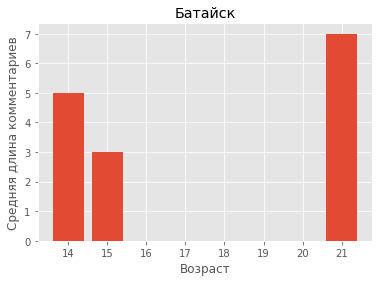

4644 [] []
1054308 [15] [2]


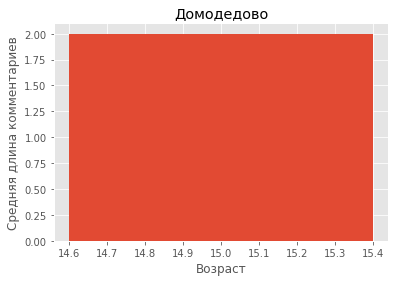

1767 [28, 33] [19, 18]


2064 [32] [3]


294 [25] [34]


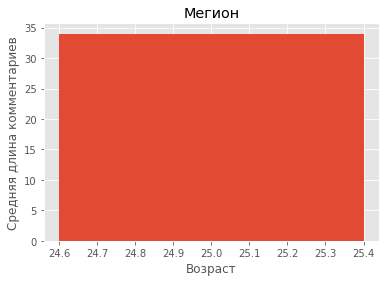

9702 [13, 29] [0, 2]


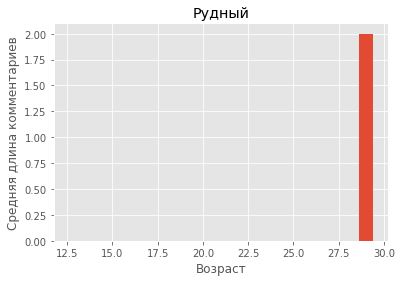

1711829 [] []
1711 [18] [1]


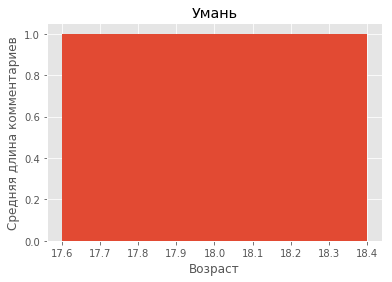

14174 [] []
882 [] []
6867 [] []
1374 [21] [14]


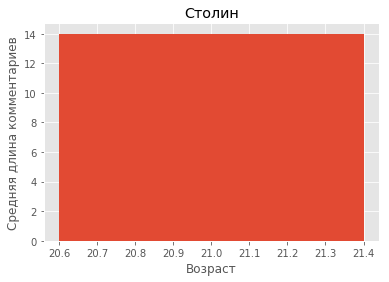

220 [15, 18, 22, 24] [8, 34, 14, 10]


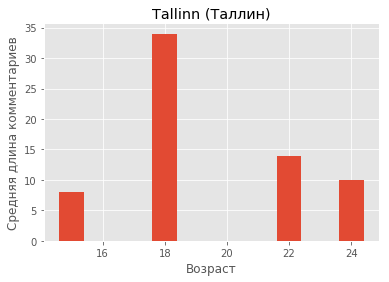

1713629 [19] [10]


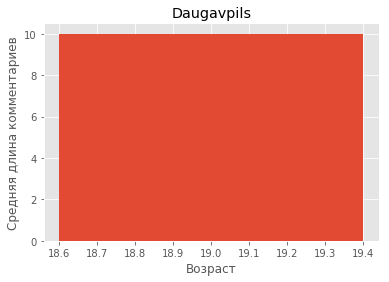

1707232 [] []
1048685 [17, 26] [58, 1]


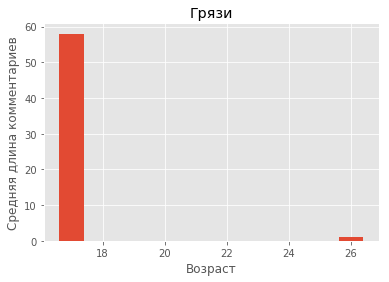

12 [24] [29]


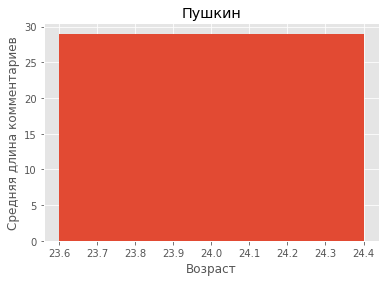

1945830 [] []
483 [14, 16, 26] [14, 1, 37]


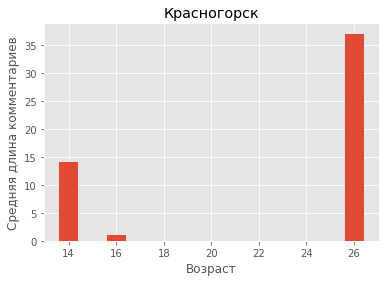

32 [20, 21, 28] [17, 8, 0]


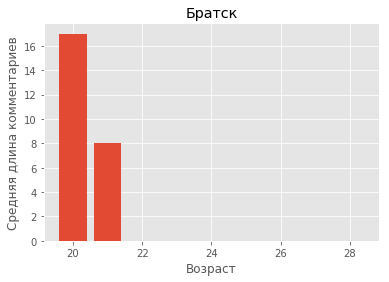

403 [] []
1245 [] []
1382 [22] [8]


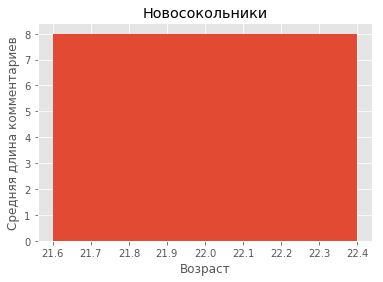

38 [17, 21] [3, 8]


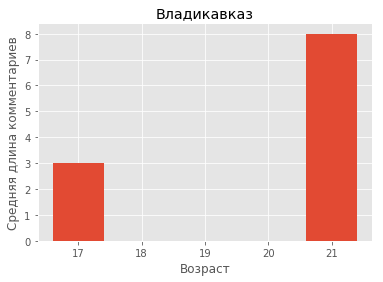

2389 [] []
1708920 [] []
5264335 [] []
46 [21, 28] [28, 8]


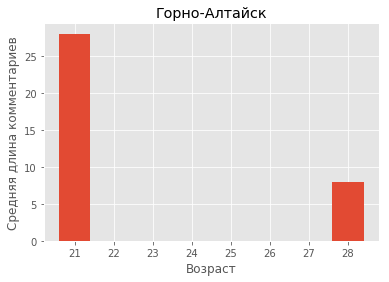

68 [15] [6]


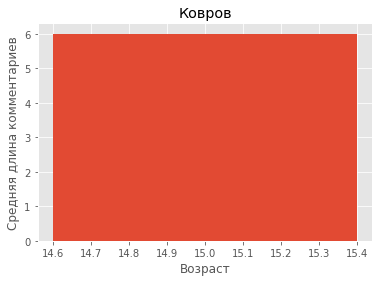

598 [] []
90 [14, 24, 25] [45, 2, 5]


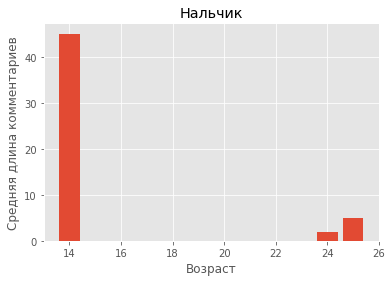

1299 [17, 21] [11, 115]


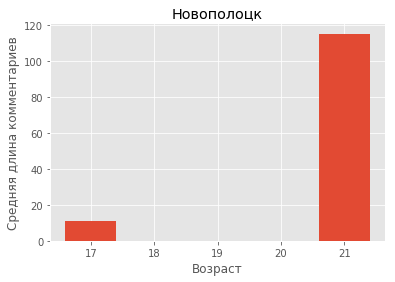

167 [29] [5]


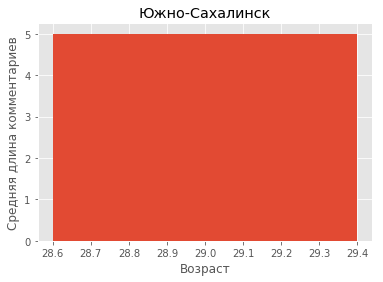

21611 [] []
1914764 [16, 20] [24, 0]


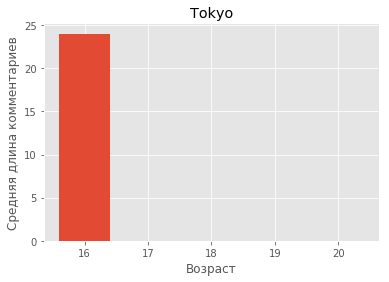

1130162 [] []
11675 [14] [2]


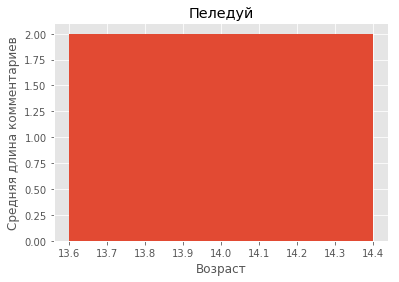

14374 [41] [5]


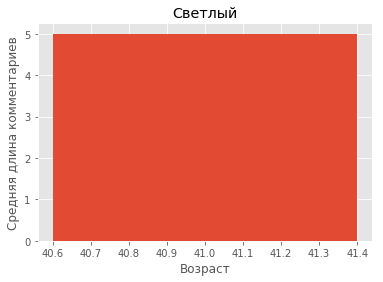

131 [] []
2448 [20] [5]


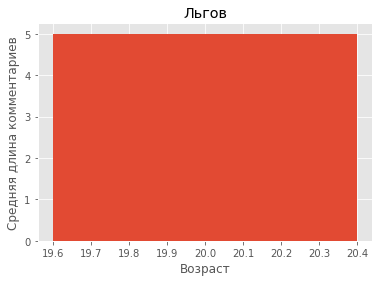

205 [17, 23, 34] [1, 2, 18]


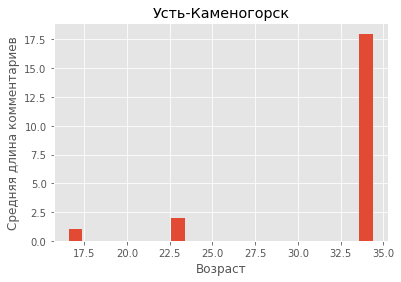

3122 [] []
725 [] []
160 [24] [3]


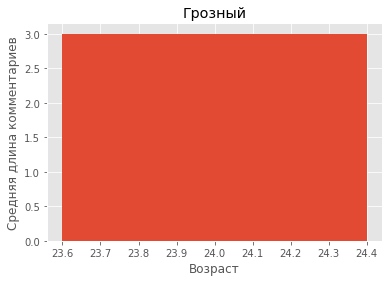

7427 [] []
635 [] []
4056006 [] []
8128 [] []
642 [] []
2319 [19] [6]


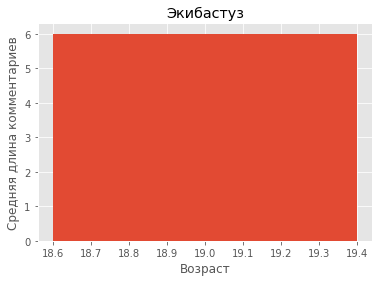

3902 [17] [6]


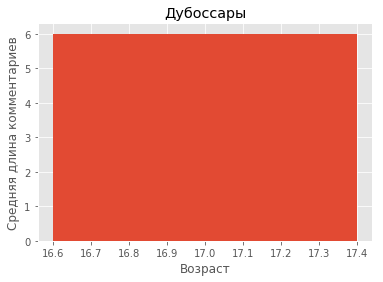

1233 [] []
5915 [20, 23] [16, 12]


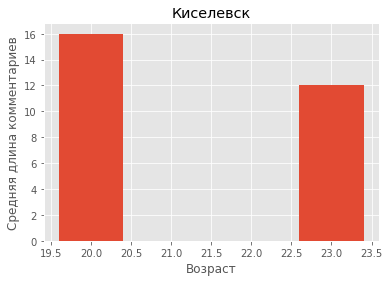

4832 [16] [5]


12050 [] []
1156182 [17] [12]


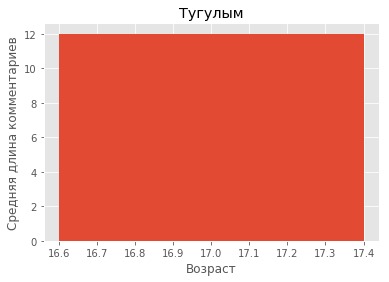

5710 [] []
4639 [19] [47]


1035626 [] []
1009407 [19, 33] [6, 24]


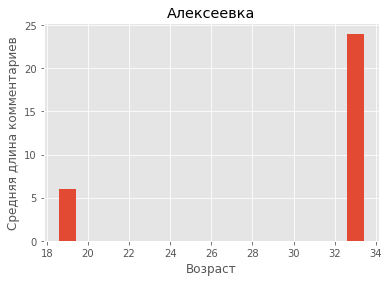

1907832 [14] [2]


5098 [15, 30] [7, 2]


1122286 [] []
1083209 [] []
58 [] []
1156164 [15] [2]


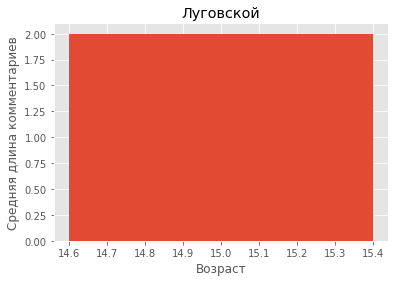

1206 [] []
6936 [] []
21855 [21, 44] [4, 8]


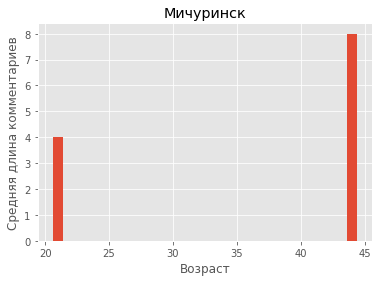

3600 [18] [6]


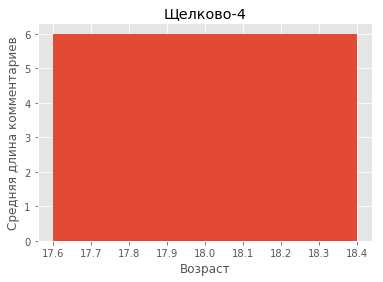

542 [21] [17]


17787 [] []
3740137 [] []
527 [15, 17] [2, 41]


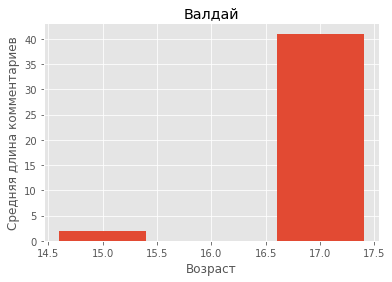

1724 [] []
1113407 [14] [4]


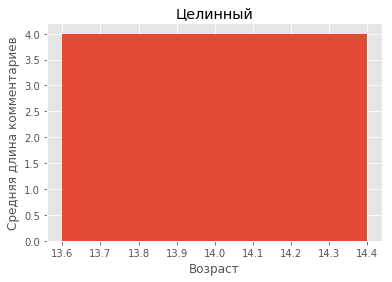

5261729 [] []
1079280 [15] [1]


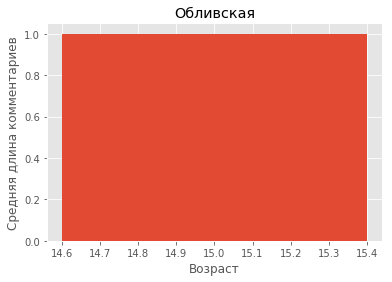

173 [] []
14071 [30] [9]


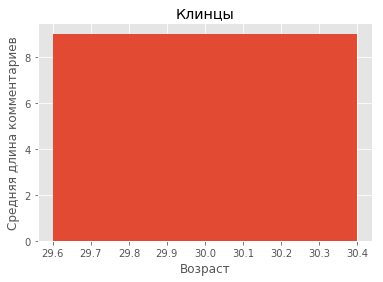

1110592 [] []
24 [26] [1]


4101 [] []
6050 [19] [8]


154 [23, 25] [11, 2]


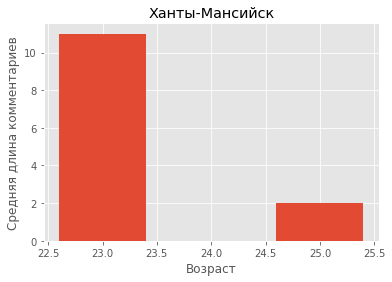

2597 [19] [35]


818 [15, 45] [7, 6]


1088110 [] []
17308 [16] [18]


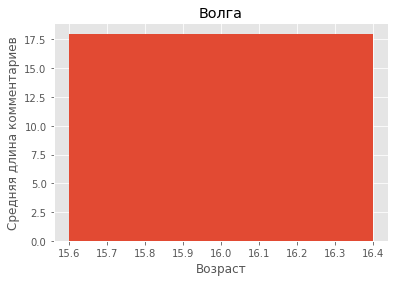

2541 [17] [29]


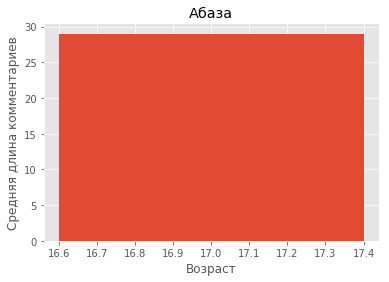

4993 [14, 24] [19, 4]


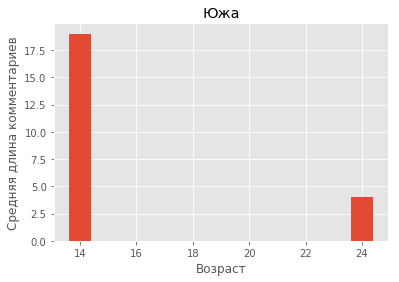

12269 [] []
11567 [14] [5]


14727 [] []
126 [15, 41] [9, 59]


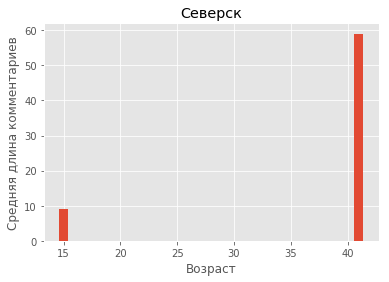

2164 [27] [16]


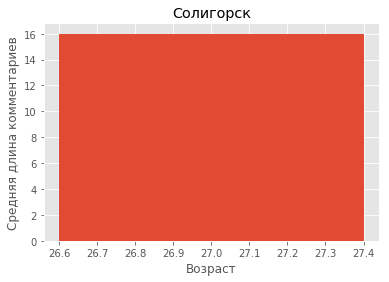

2912 [] []
161 [15, 17, 28] [88, 3, 55]


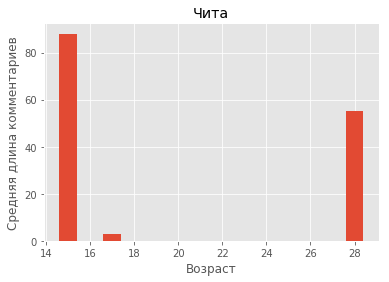

1017238 [23] [83]


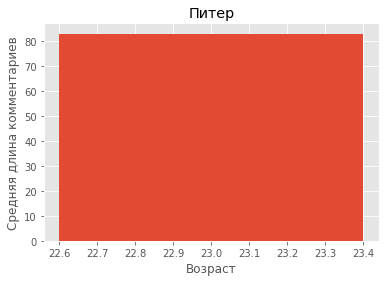

2771 [] []
881 [16] [4]


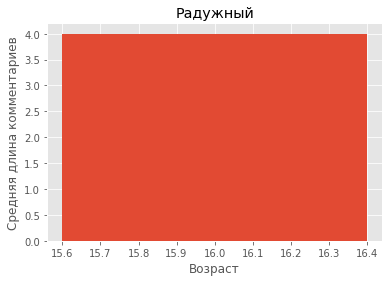

1802375 [30] [3]


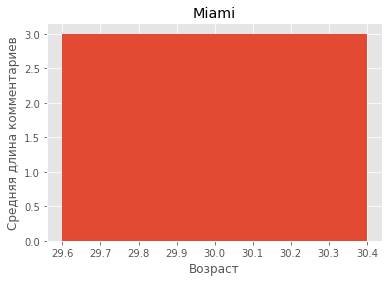

621 [16, 22, 26] [12, 5, 6]


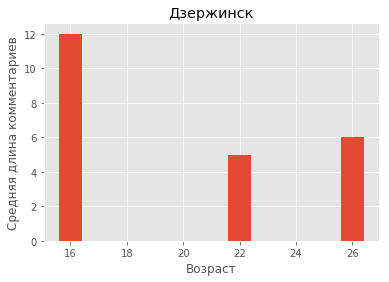

8043 [] []
2486 [] []
16659 [] []
18926 [] []
1704765 [23] [11]


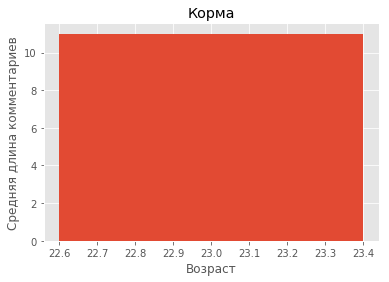

1151 [33] [15]


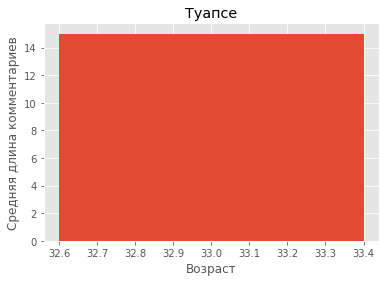

67 [] []
2211 [25] [2]


744 [22] [2]


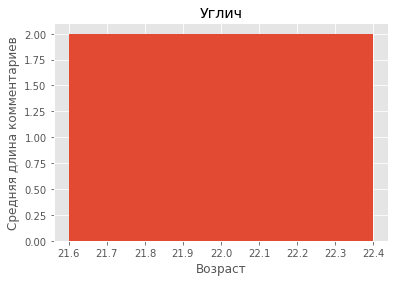

17057 [] []
5520 [20] [2]


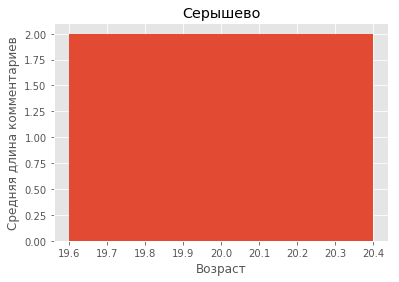

194 [26] [3]


1722 [14, 26] [10, 7]


593 [16, 17] [3, 26]


1133 [] []
9528 [33] [18]


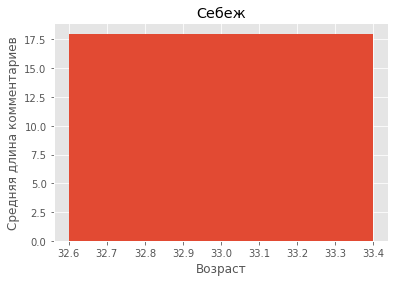

1516454 [] []
1058775 [] []
283 [24] [5]


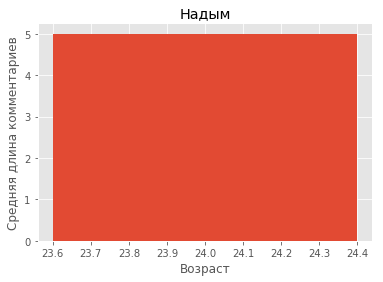

6294 [15] [1]


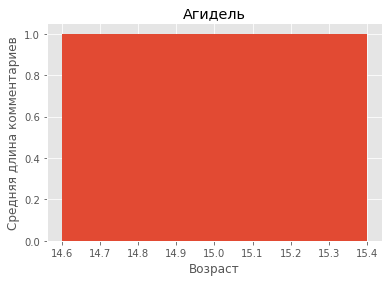

15561 [] []
9254 [] []
1031804 [31] [31]


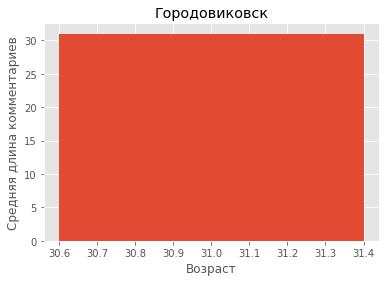

5315 [15, 19] [4, 10]


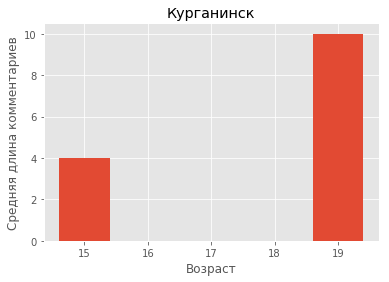

117 [16, 20, 24, 28, 29] [8, 3, 16, 19, 2]


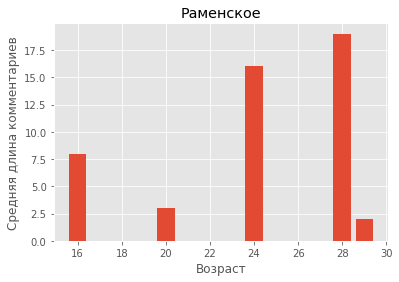

3802 [] []
501 [26] [9]


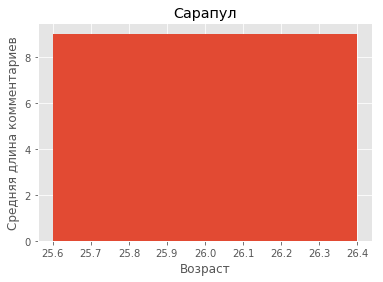

1769 [14, 15, 24] [3, 2, 8]


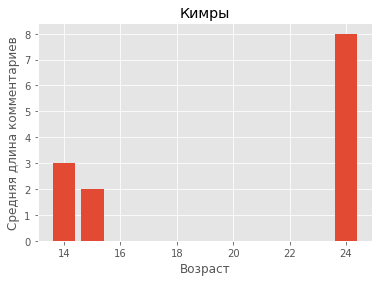

1007687 [32] [2]


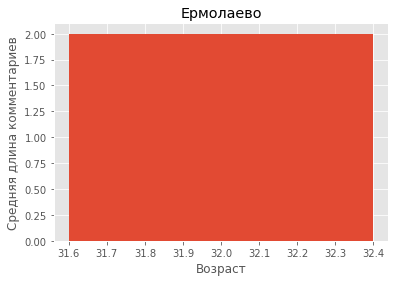

4603 [] []
1606 [18] [16]


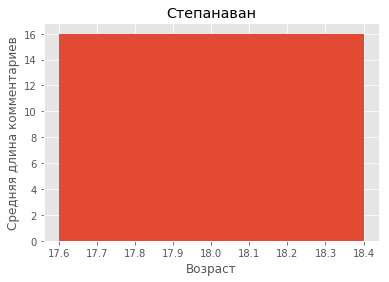

4854 [31] [13]


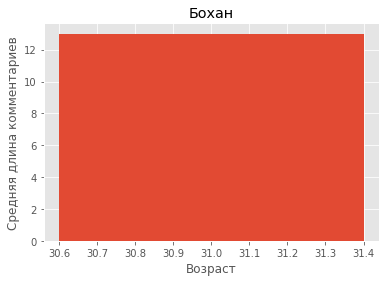

1780 [14, 25] [1, 10]


150 [] []
2152 [17] [1]


13610 [22] [4]


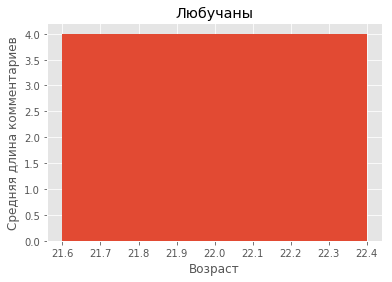

5985 [14, 16] [6, 5]


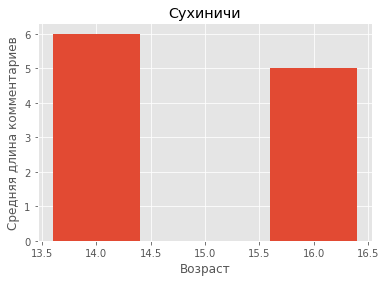

640 [] []
9035 [16] [1]


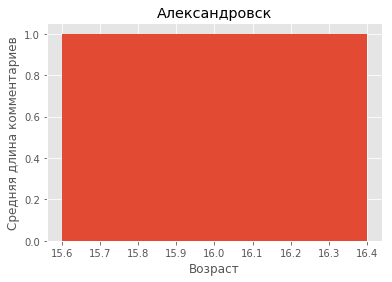

2210985 [] []
328 [22] [1]


1138054 [] []
16063 [] []
16503 [17] [14]


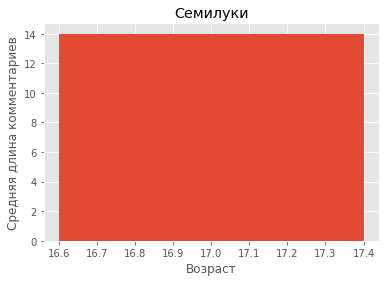

3820 [] []
1043292 [22] [24]


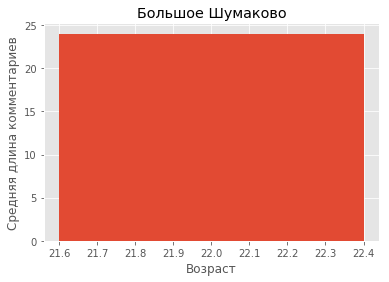

502 [17] [4]


1918 [18, 20] [3, 1]


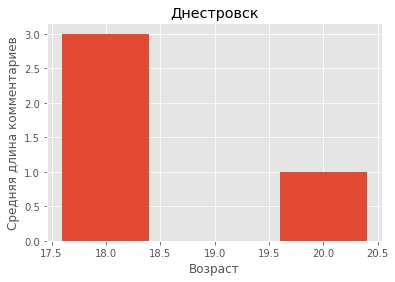

18631 [] []
4757 [17, 31] [8, 97]


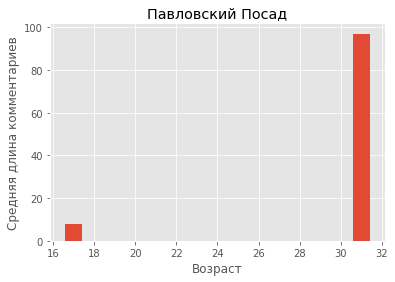

833 [] []
1702 [16] [11]


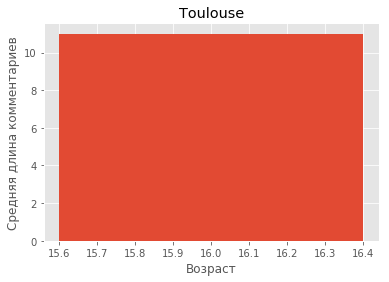

1600788 [] []
129 [14, 27] [3, 8]


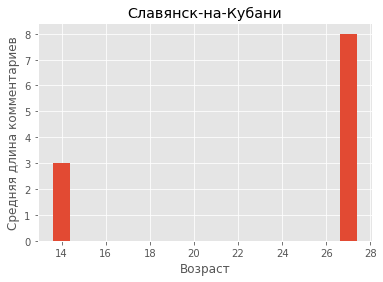

334 [19, 24] [6, 3]


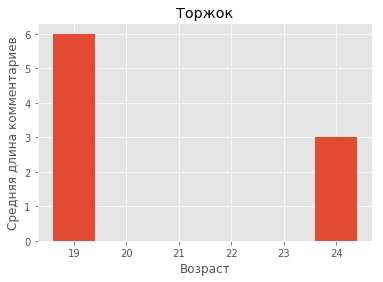

424 [] []
1519067 [13] [16]


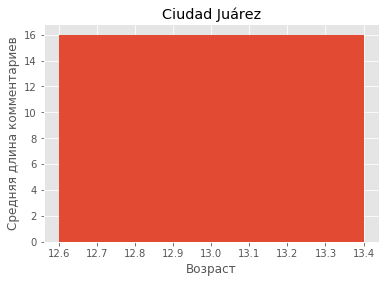

20905 [22] [9]


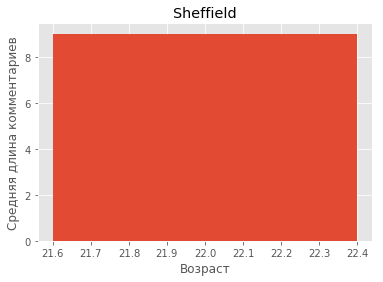

116 [19, 26, 27] [2, 6, 5]


20691 [19, 22] [1, 24]


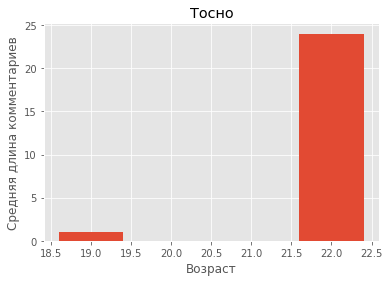

94 [27, 29] [1, 17]


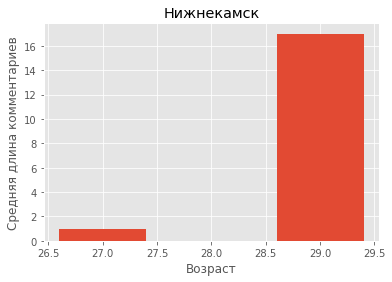

545 [15] [4]


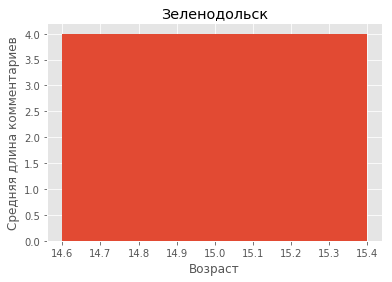

1153634 [] []
13793 [14] [2]


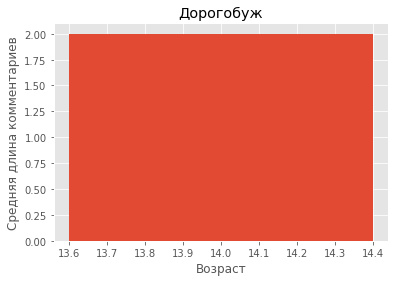

36 [18] [11]


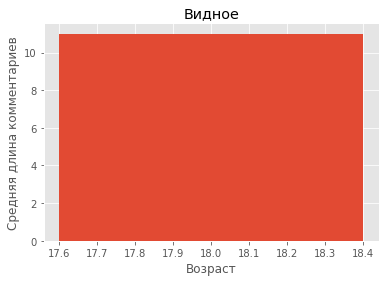

19179 [] []
10611 [] []
1005782 [] []
20950 [15, 22, 26] [4, 16, 6]


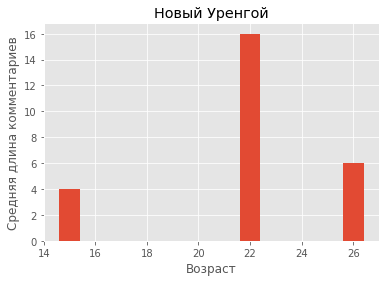

19296 [] []
21118 [] []
1028655 [] []
2217 [14] [16]


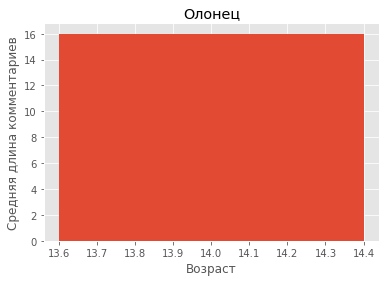

83 [18, 22] [4, 2]


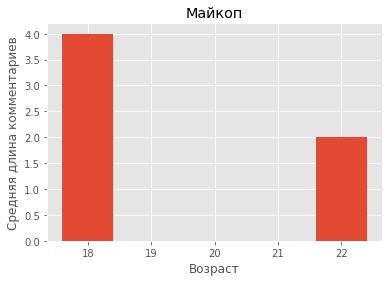

3910 [] []
16669 [14, 19] [12, 6]


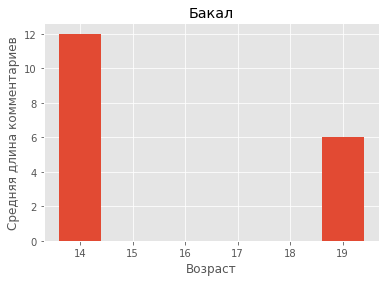

5955 [25] [2]


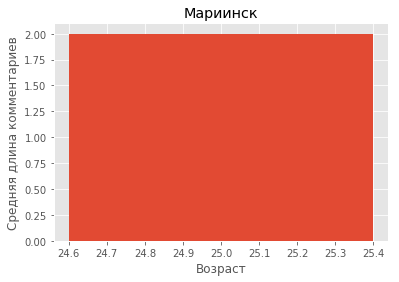

261 [] []
12945 [26] [10]


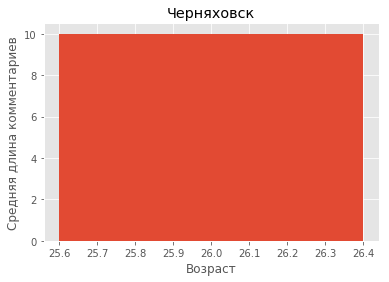

1112472 [18] [0]


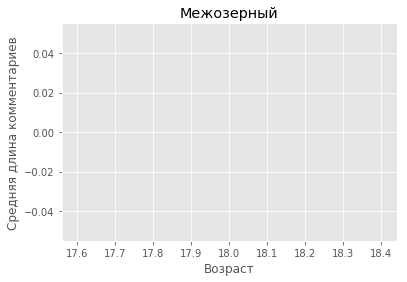

1156390 [24] [9]


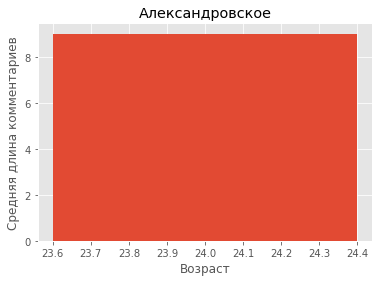

156 [] []
1077716 [] []
1057197 [] []
1130304 [] []
1005 [] []
1081872 [] []
1707 [57] [16]


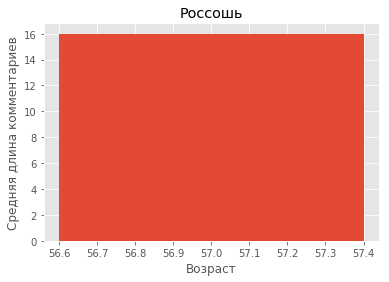

1137578 [] []
459 [] []
182 [20, 21] [4, 13]


2093 [] []
21 [21, 25, 26] [44, 3, 2]


993 [] []
1154696 [] []
1095175 [] []
1041255 [] []
2331 [28] [1]


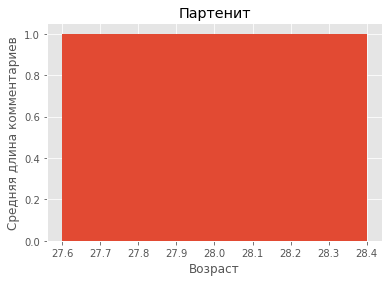

6875 [] []
8496 [] []
1035535 [] []
610 [19] [17]


609 [24] [16]


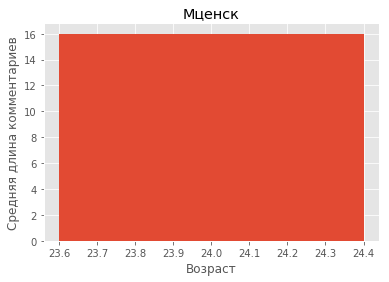

1937941 [] []
524 [] []
1531 [17, 28] [6, 14]


6111 [] []
1113989 [] []
1142 [17] [3]


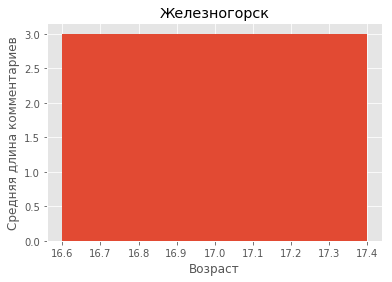

3488 [15] [6]


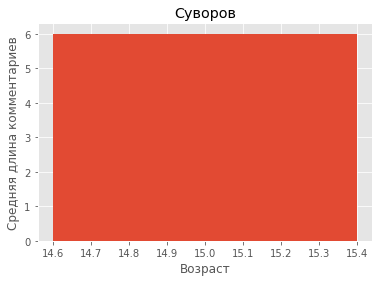

1024328 [25] [10]


799 [21] [4]


5544 [] []
1259 [] []
1710182 [] []
1253 [] []
375 [15, 17] [3, 3]


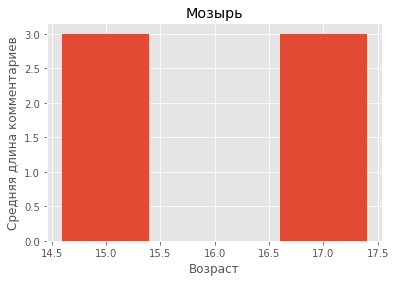

2367 [] []
210 [] []
5428815 [] []
5574 [21, 24] [8, 9]


1526 [31] [18]


2890 [] []
1933924 [33] [28]


668 [18, 20, 27] [22, 6, 30]


785 [21] [2]


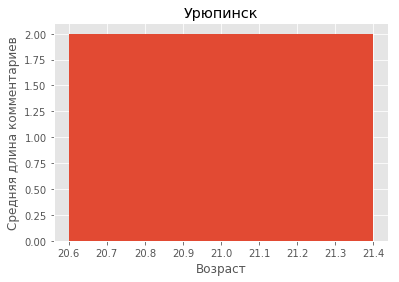

21358 [] []
352 [] []
21365 [] []
1970123 [38] [50]


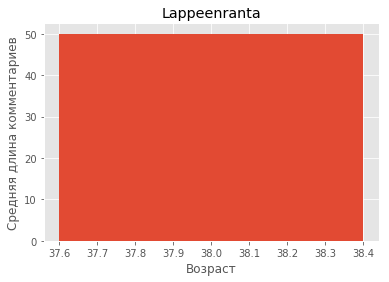

1450 [] []
2001650 [] []
6579 [] []
2179 [22] [21]


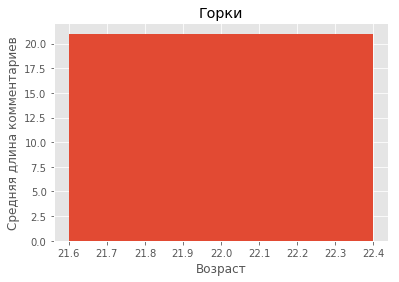

1456 [] []
1922897 [17] [4]


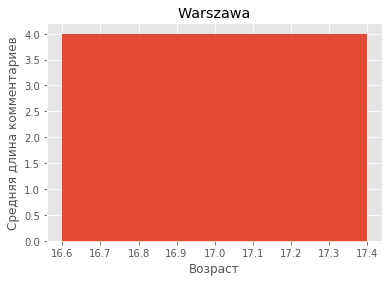

2480 [] []
1515864 [16] [4]


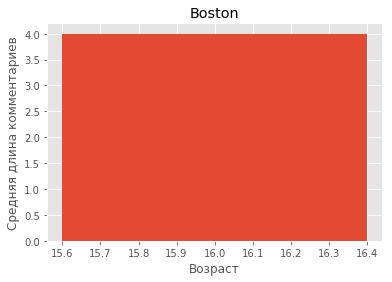

4216 [] []
1938720 [15] [1]


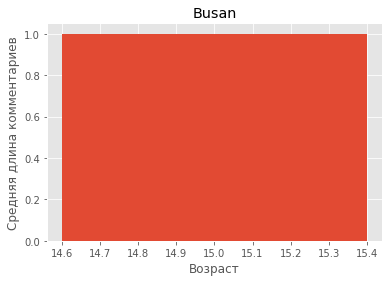

1803 [16] [8]


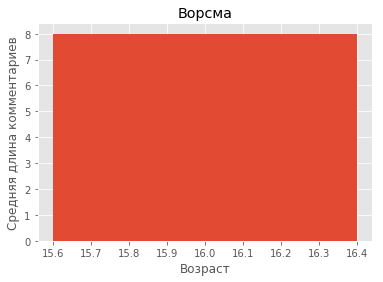

9340 [] []
600 [25] [26]


1007829 [] []
21613 [15, 24] [1, 18]


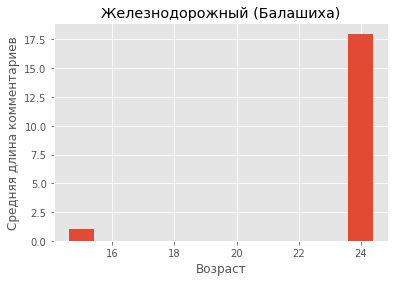

1044874 [] []
1048255 [26, 30, 46] [12, 7, 7]


18703 [45] [11]


1980 [21] [60]


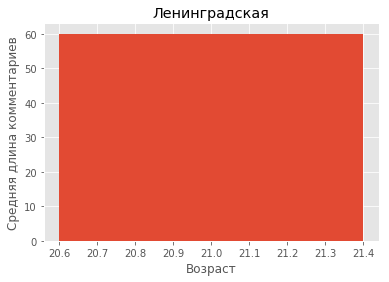

6725 [25] [3]


2110 [17, 35] [2, 2]


873 [] []
2404 [15] [2]


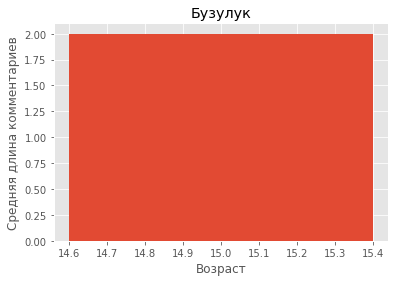

715 [] []
7458 [] []
4014 [15] [1]


1036585 [25, 28] [4, 6]


680 [] []
17886 [29] [5]


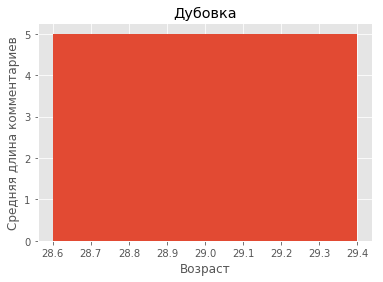

1711731 [18] [87]


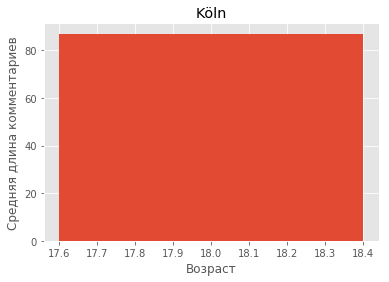

4130 [14] [4]


1723 [33] [14]


3079695 [28] [3]


365 [] []
2722584 [] []
21713 [] []
22426 [24] [9]


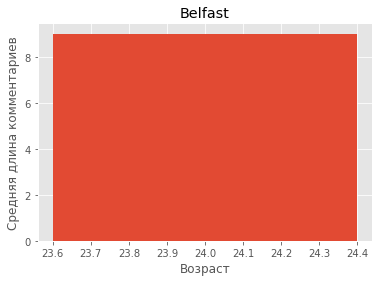

6429 [] []
4522119 [67] [1]


18 [18, 25, 33] [2, 3, 4]


320 [19] [5]


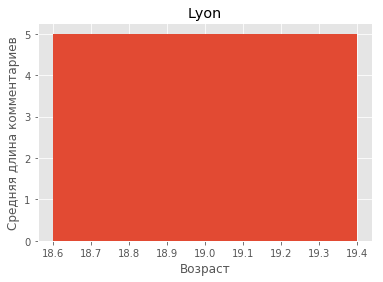

5586 [14] [5]


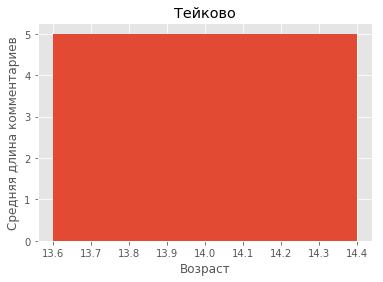

1070081 [] []
10191 [22] [18]


3637 [] []
1085688 [] []
7139 [] []
1015315 [] []
2510 [26] [6]


18076 [] []
355 [] []
15769 [23] [4]


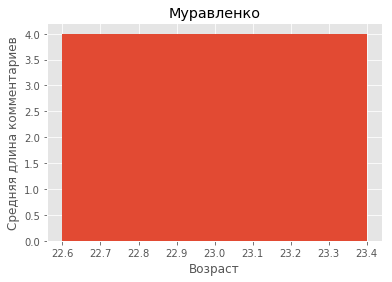

2149 [13, 16] [2, 8]


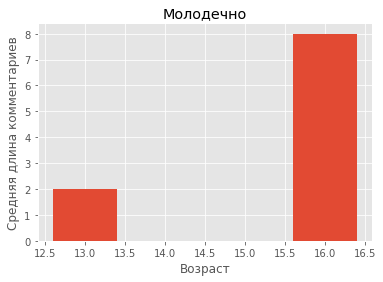

3880 [19] [6]


191 [] []
3965 [] []
1112381 [] []
5332051 [] []
18268 [] []
1005376 [] []
208 [] []
5331435 [] []
6303 [16, 29] [19, 12]


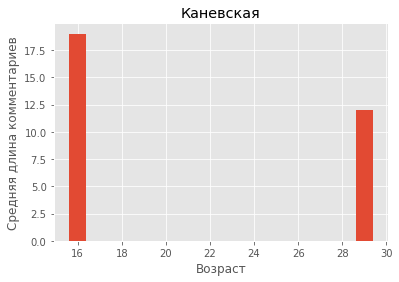

3249 [] []
1015651 [27] [10]


9869 [19] [3]


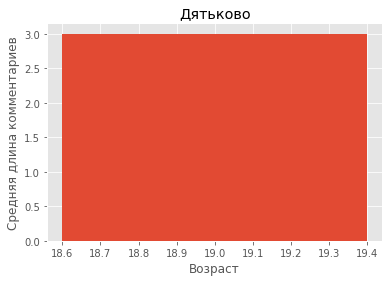

13306 [] []
4059 [] []
10971 [] []
4069782 [] []
364 [16] [4]


4044 [21] [9]


1916384 [] []
2163 [] []
11312 [] []
1502941 [] []
530 [29] [4]


1112825 [] []
3831 [] []
4576 [14] [4]


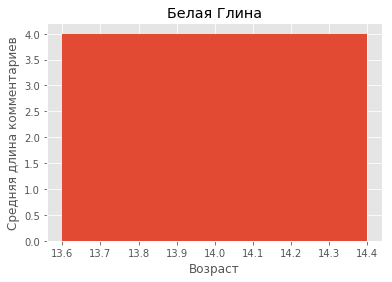

187 [] []
478 [] []
255 [15] [4]


788 [17, 18] [2, 4]


1004765 [] []
8335 [] []
1055600 [13] [1]


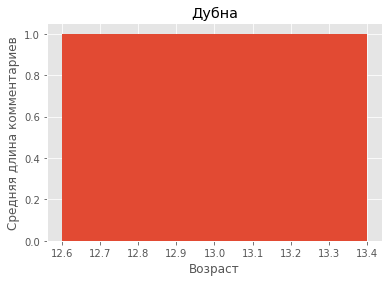

1104 [25] [3]


15000 [20] [6]


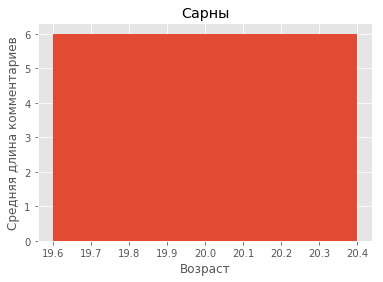

14644 [] []
3255 [16] [27]


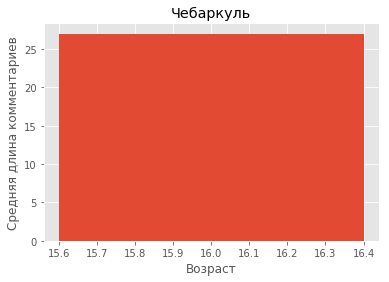

2261 [] []
548 [21, 25] [2, 2]


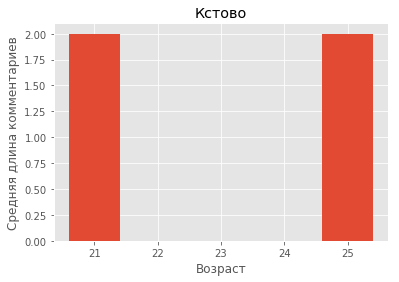

1307 [] []
165 [] []
16746 [] []
781 [] []
1084237 [] []
20404 [] []
6582 [26] [4]


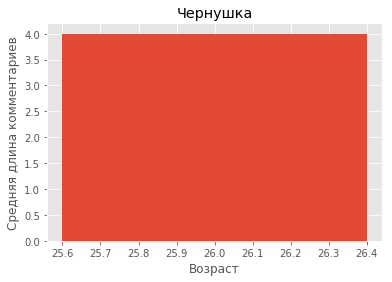

29 [17, 24] [6, 5]


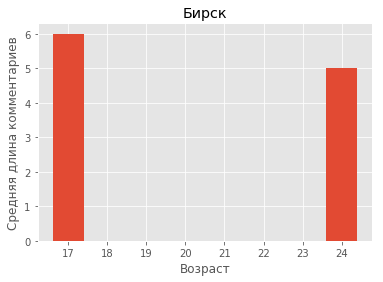

1139062 [] []
431 [16, 17] [7, 4]


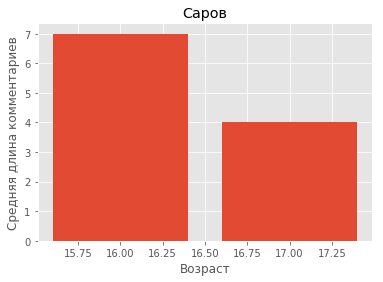

624 [19, 22] [17, 8]


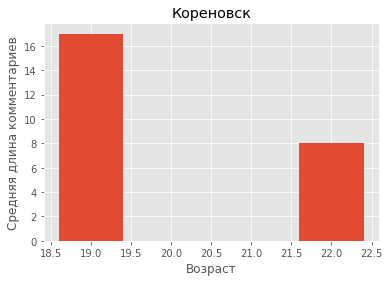

2256 [] []
8741 [] []
1315 [] []
14067 [] []
20485 [17] [4]


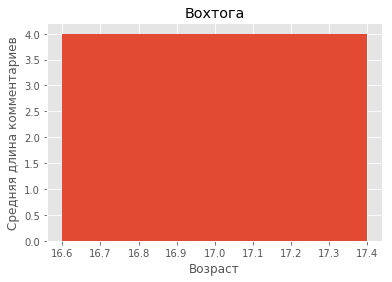

1009610 [] []
505 [29] [2]


1515634 [] []
382 [26, 30] [26, 2]


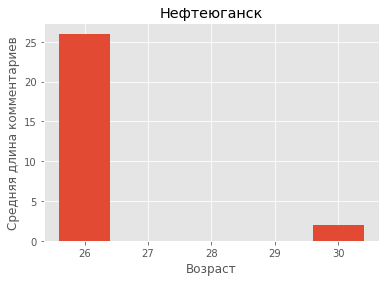

8281 [] []
9685 [26] [4]


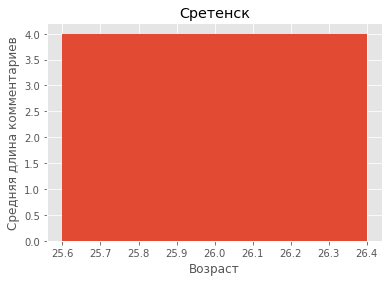

6485 [16] [14]


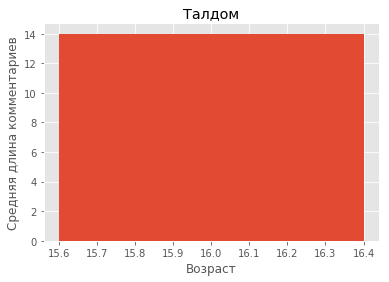

4242 [] []
1129443 [14] [5]


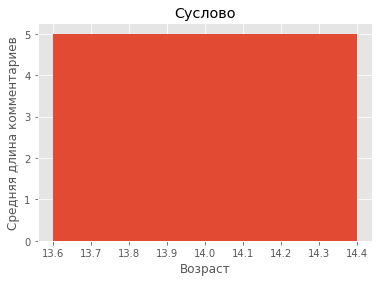

12014 [] []
1009914 [] []
1041445 [] []
1014732 [20] [2]


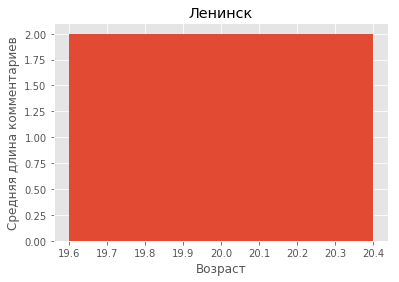

17216 [] []
293 [14] [70]


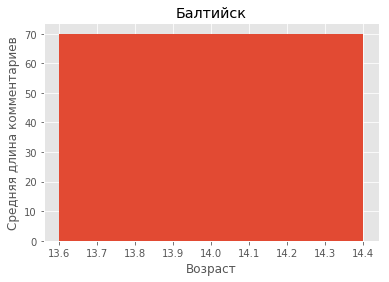

4791 [] []
1023935 [32] [7]


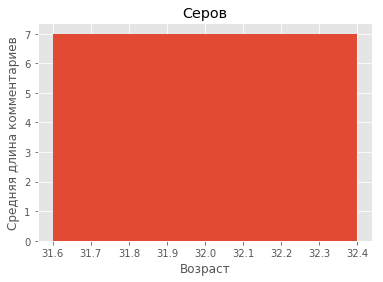

16725 [17] [7]


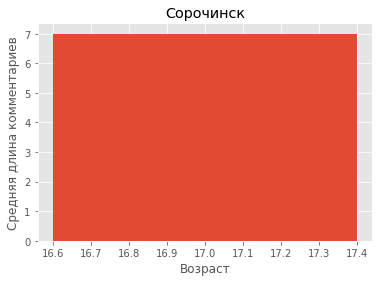

5624 [] []
889 [20] [2]


312 [23] [35]


21657 [15, 17, 28] [6, 4, 16]


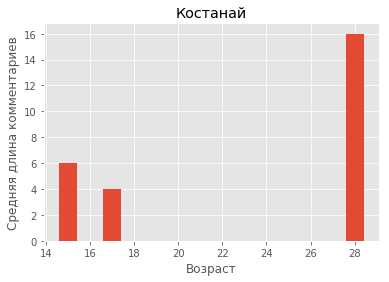

1024393 [15] [3]


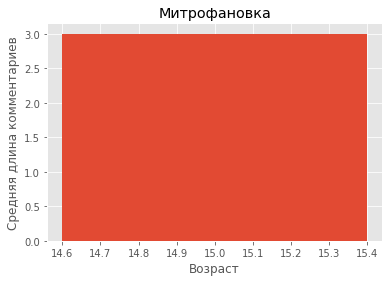

4440 [] []
17052 [] []
1148547 [] []
45 [] []
1051 [] []
950 [] []
1134891 [23] [9]


3711405 [14] [10]


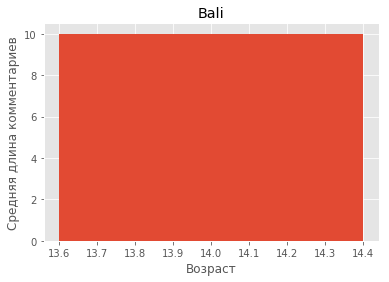

3667 [] []
718 [23] [35]


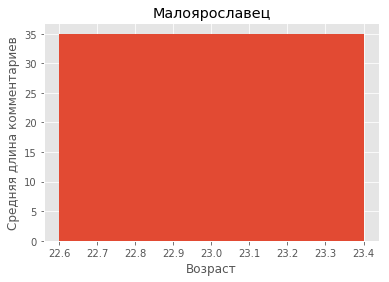

4734 [] []
512 [19] [9]


1123852 [15] [5]


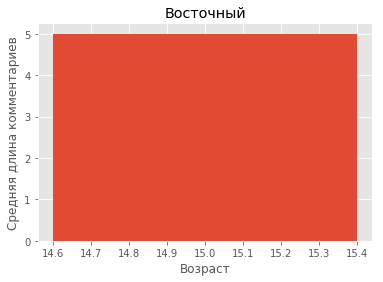

4825788 [18] [2]


1246 [49] [8]


6282 [15] [3]


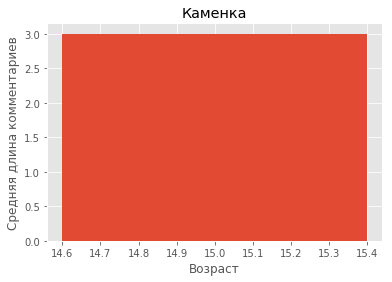

1108923 [] []
1944918 [] []
962 [] []
5267808 [] []
14801 [] []
6482 [] []
2322 [] []
5542 [19] [7]


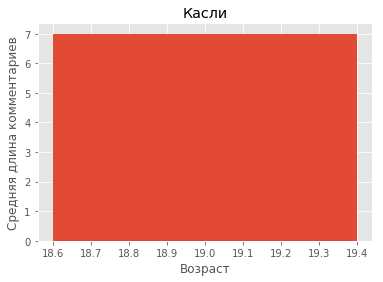

4176 [] []
2301 [] []
8590 [23] [60]


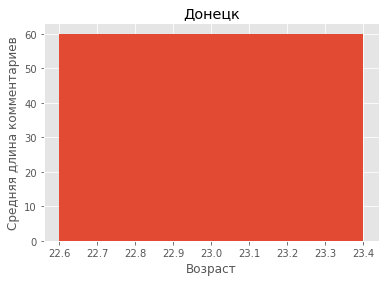

584 [] []
707 [28] [4]


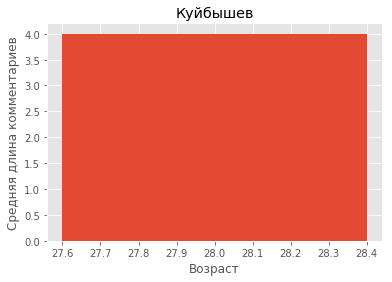

12099 [31] [5]


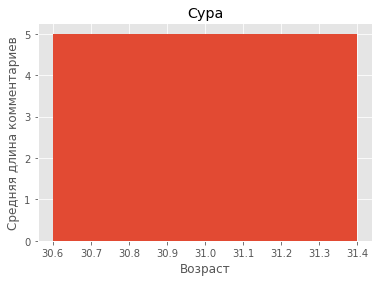

716 [] []
2722649 [31] [4]


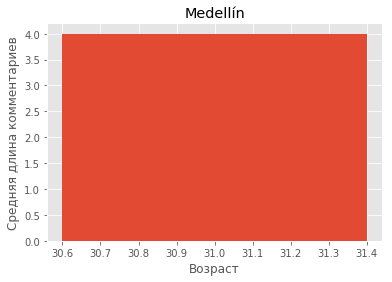

1120328 [31] [8]


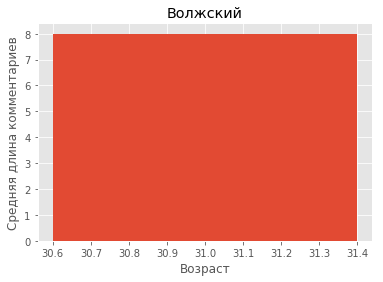

6025 [35] [8]


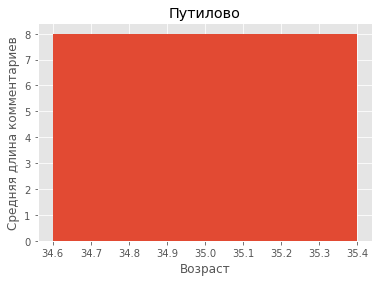

5421165 [] []
360 [37] [28]


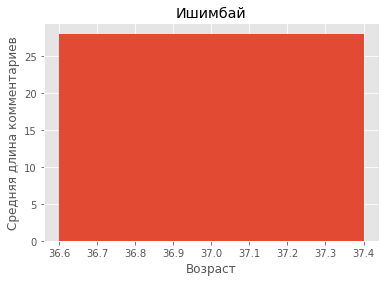

1122969 [28] [10]


4241 [29] [1]


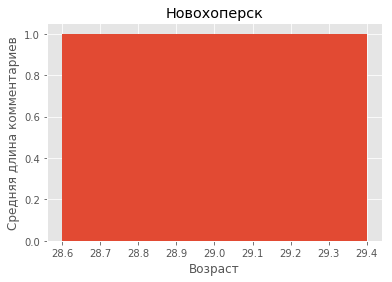

1932227 [30] [42]


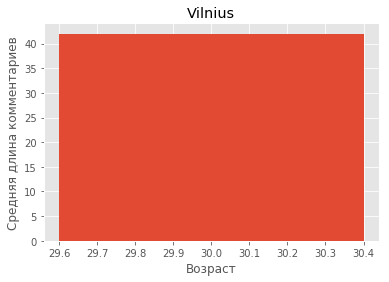

4906826 [14] [8]


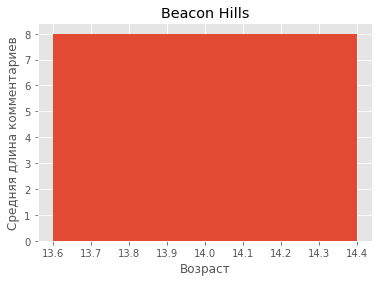

1031838 [] []
1394 [27] [11]


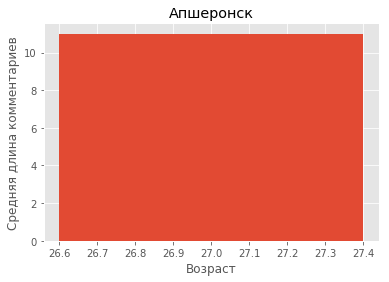

538 [26] [3]


361 [19, 20, 25] [2, 17, 7]


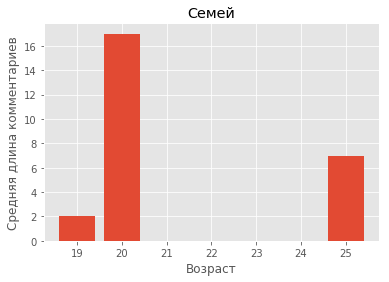

857 [14] [3]


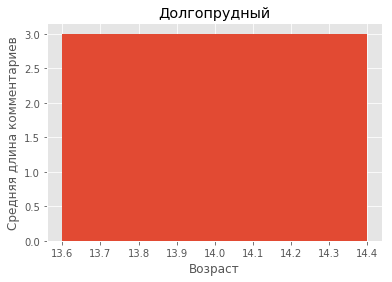

3877 [] []
9435 [] []
8436 [26] [8]


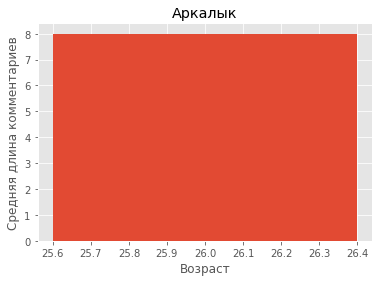

1201 [22] [35]


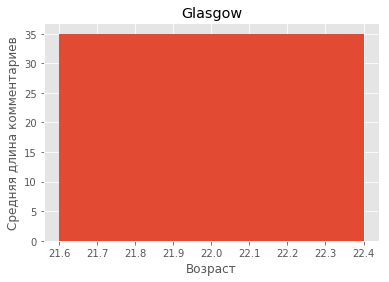

17290 [] []
54 [] []
2444 [] []
19636 [27] [6]


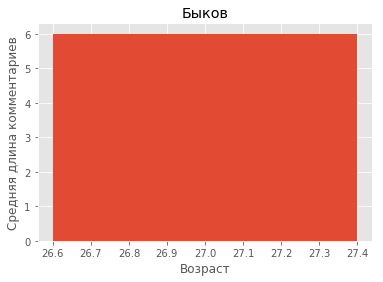

1818 [] []
15326 [25] [12]


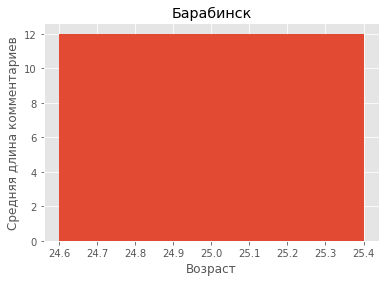

201 [] []
1812 [31] [7]


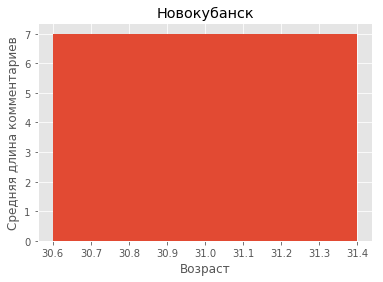

10860 [15] [6]


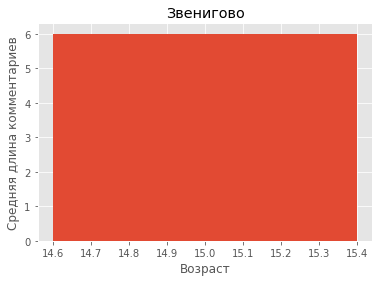

11260 [] []
1031923 [] []
1517236 [27] [5]


18375 [27] [3]


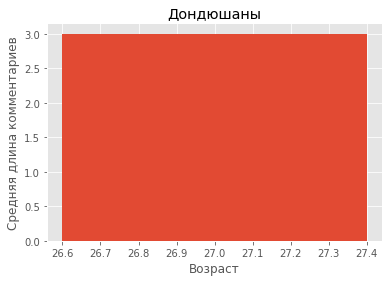

246 [33] [7]


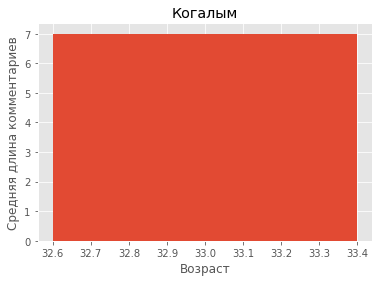

6674 [] []
1743 [24] [24]


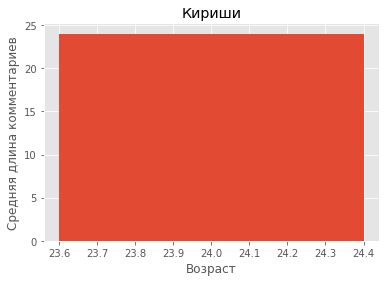

346 [15] [2]


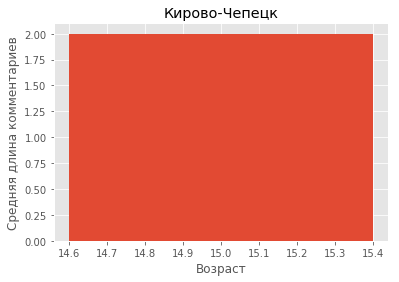

3048 [25] [3]


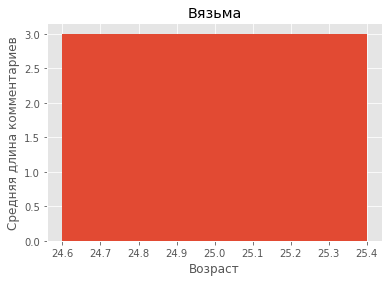

1705711 [] []
4798 [] []
1235 [] []
5023 [] []
15236 [15] [2]


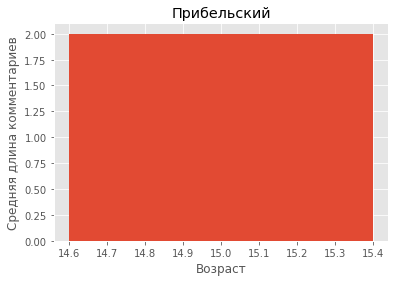

10779 [] []
15870 [46] [0]


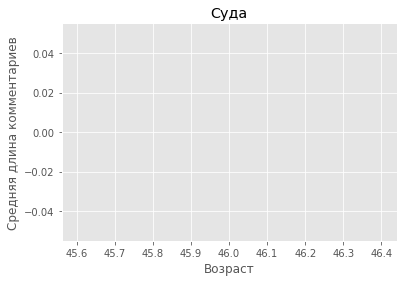

898 [21] [6]


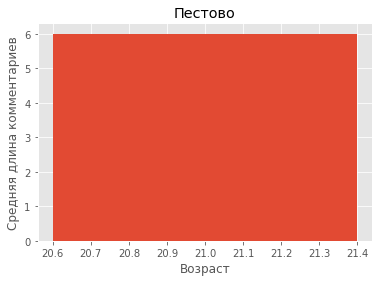

11520 [22] [11]


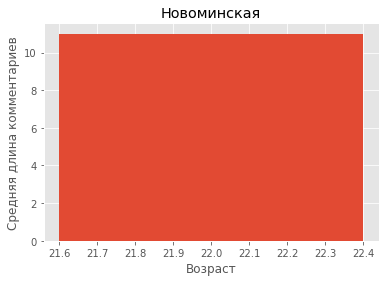

1109720 [] []
1080382 [24] [4]


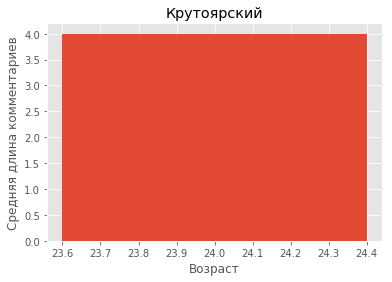

2117 [] []
1962 [] []
7949 [19] [2]


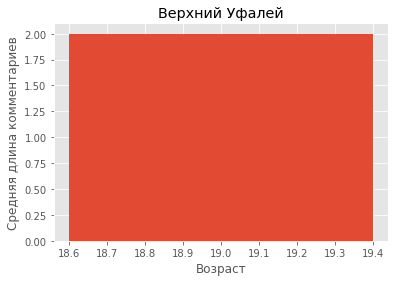

1277 [27] [3]


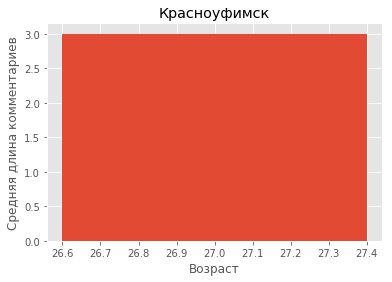

12923 [] []
8564 [] []
1711047 [14] [22]


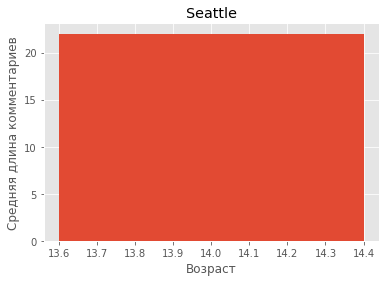

4547 [29] [5]


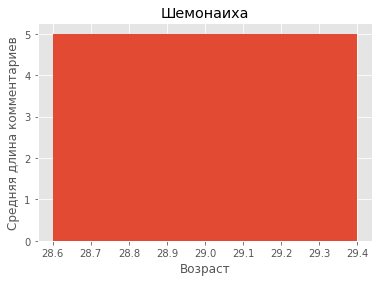

28 [17] [6]


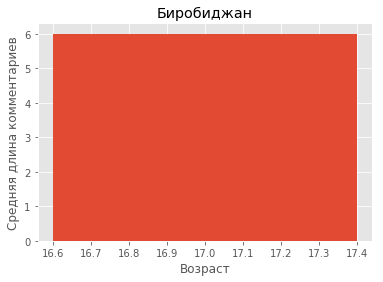

1046 [] []
18239 [14] [11]


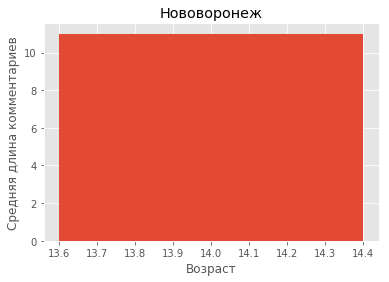

16284 [15] [3]


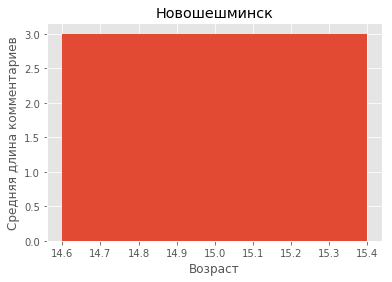

7838 [] []
4892 [] []
7101 [16] [3]


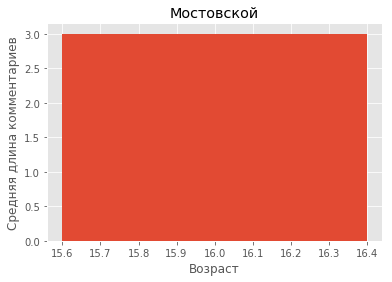

2760 [] []
15006 [] []
1009964 [] []
11733 [] []
1004863 [30] [15]


1297 [23, 37] [6, 32]


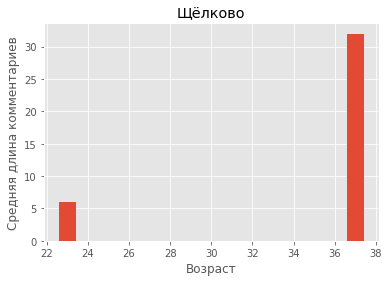

3462 [22] [36]


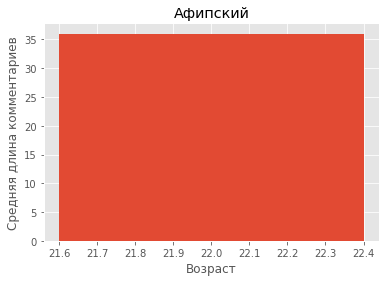

713 [] []
4991 [] []
5667 [] []
1115442 [] []
5994 [16] [2]


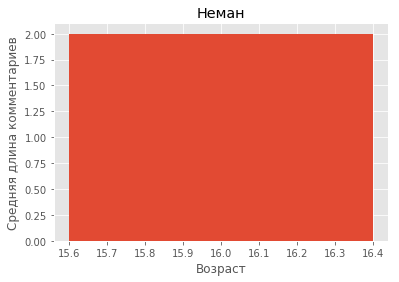

5261745 [75] [4]


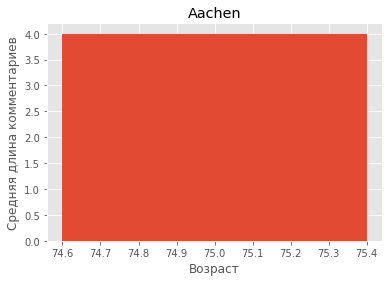

9281 [32] [11]


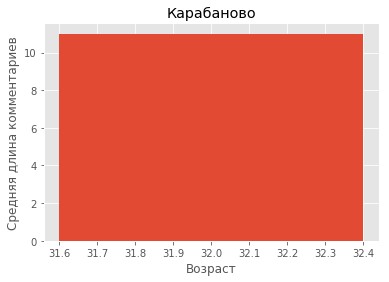

1007397 [17] [4]


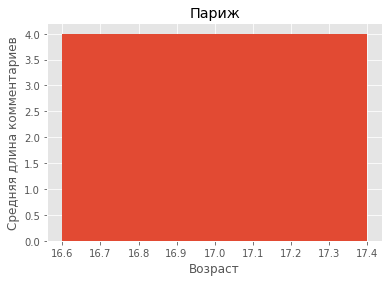

2130 [] []
397 [18, 23, 35] [2, 25, 37]


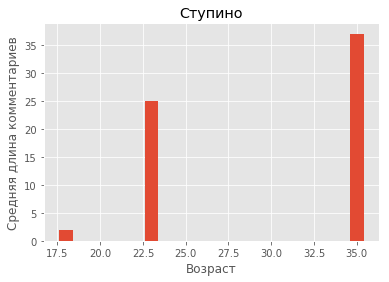

290 [] []
17557 [14] [3]


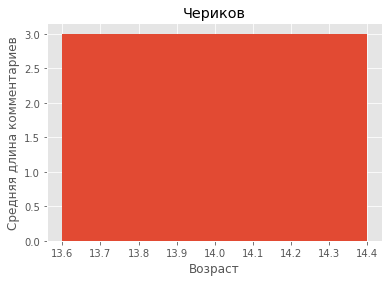

3229 [15, 23, 24] [4, 3, 23]


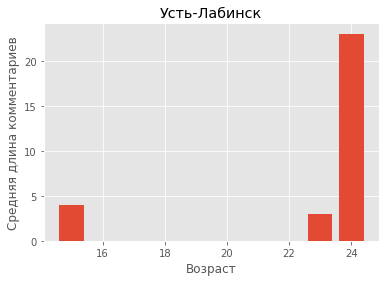

5459 [] []
1056420 [] []
292 [20, 27] [6, 0]


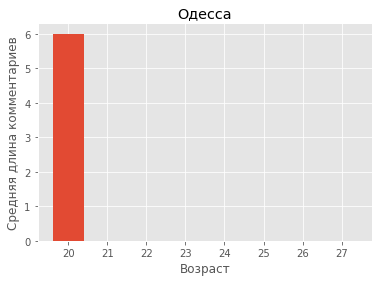

3521 [15, 25] [6, 13]


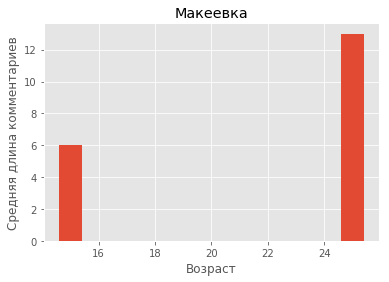

288 [20] [2]


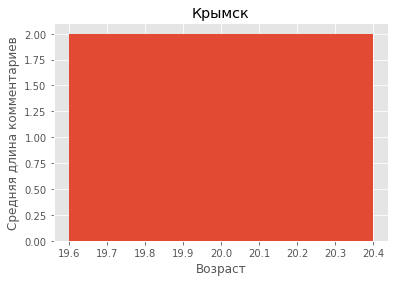

3214 [] []
449 [] []
1449 [21] [5]


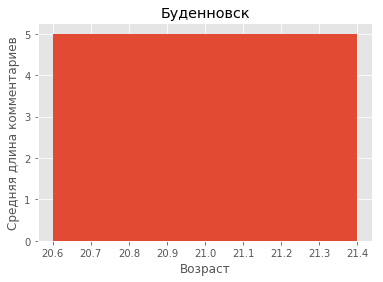

1035480 [24] [7]


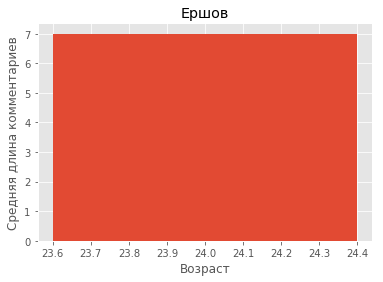

20281 [] []
20588 [] []
11522 [] []
4529699 [] []
10719 [] []
854 [] []
2023 [14] [16]


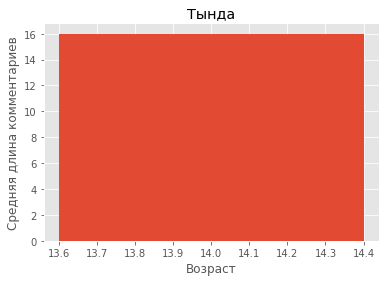

3260 [16] [4]


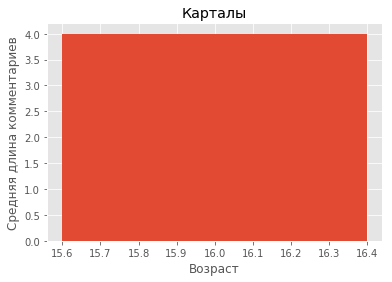

8659 [] []
4690850 [16] [2]


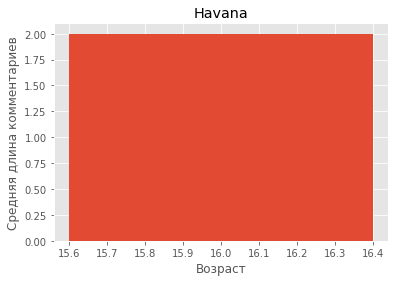

1223 [17, 19, 27] [1, 4, 3]


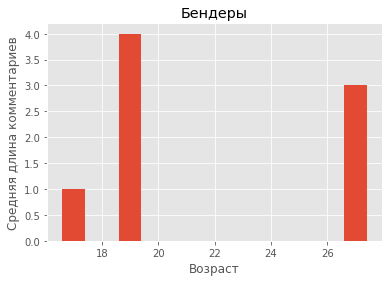

4610999 [18] [12]


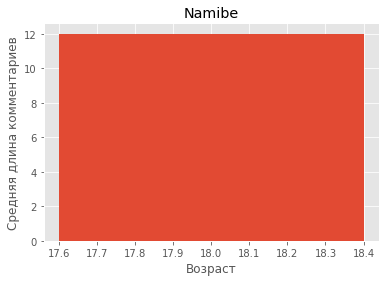

4797 [] []
5099 [] []
338 [40] [3]


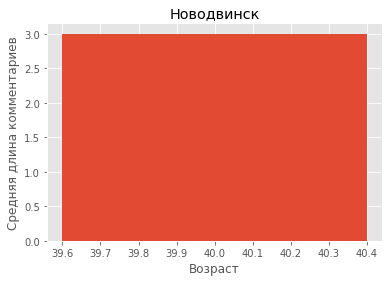

16087 [] []
1516109 [] []
21612 [] []
326 [16] [12]


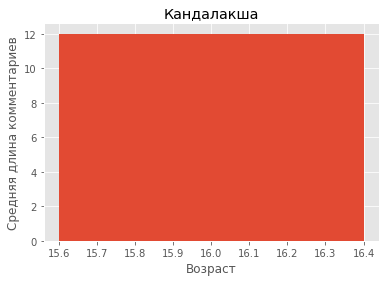

4142 [22] [5]


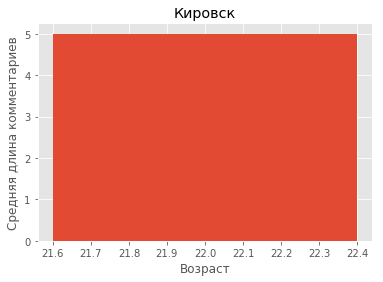

479 [] []
1730 [15] [5]


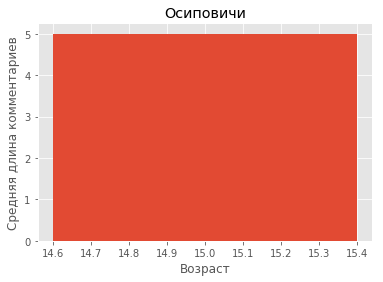

1839 [] []
268 [32] [26]


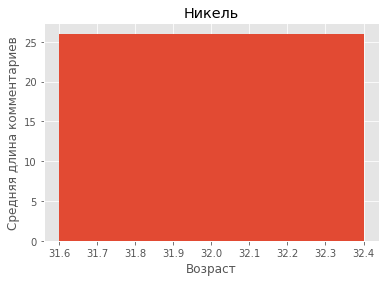

21871 [] []
8058 [15] [1]


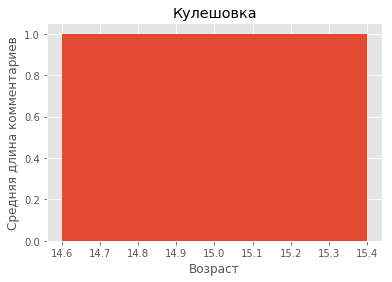

5294 [31] [7]


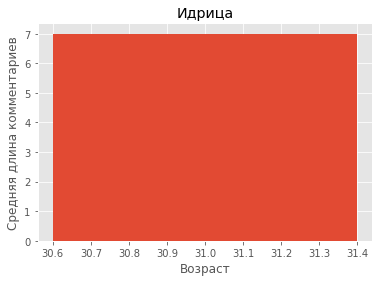

5413 [] []
2443 [15] [3]


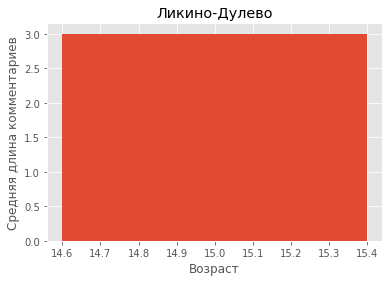

8398 [] []
1604 [] []
248 [15] [4]


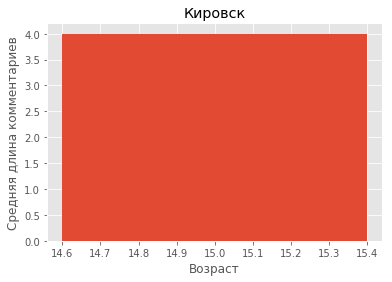

79 [56] [11]


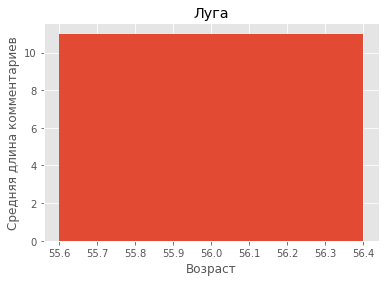

1052521 [17] [2]


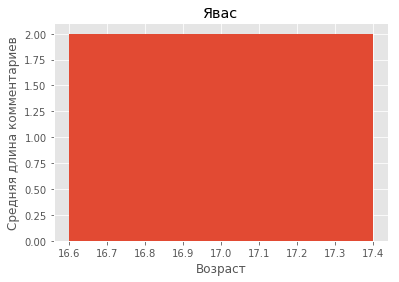

543 [23] [8]


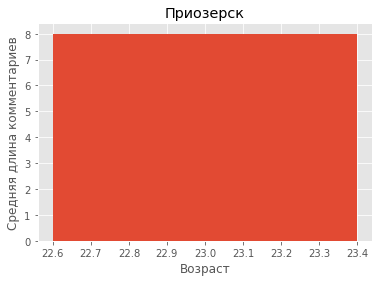

1034351 [20] [8]


1053455 [] []
377 [] []
9742 [] []
790 [] []
13004 [17] [16]


186 [21] [8]


20654 [] []
4466 [25] [6]


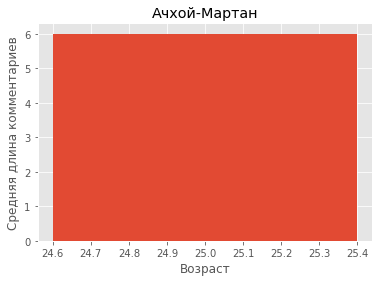

891 [] []
15247 [] []
1602498 [] []
1108126 [] []
1915914 [] []
4482 [16] [7]


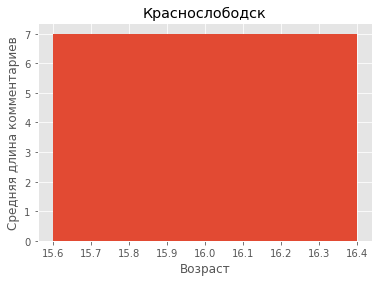

1061 [28] [1]


1033082 [] []
1496 [] []
5713 [20, 21] [5, 2]


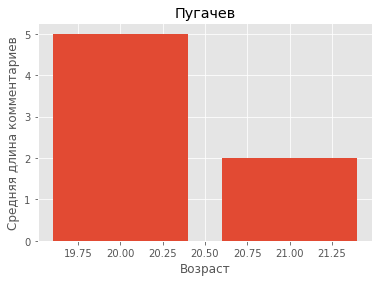

1942 [] []
15676 [44] [11]


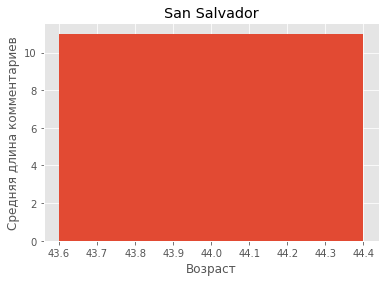

1151296 [16] [4]


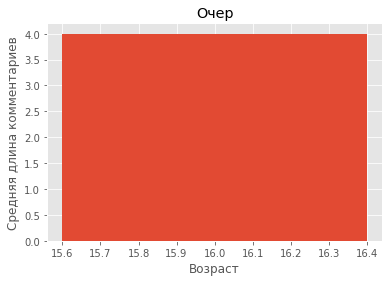

9928 [19] [3]


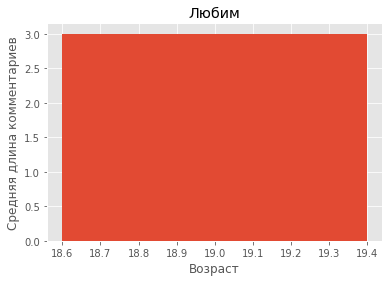

1057975 [21] [2]


1045751 [] []
586 [16, 24] [13, 2]


4148 [26] [2]


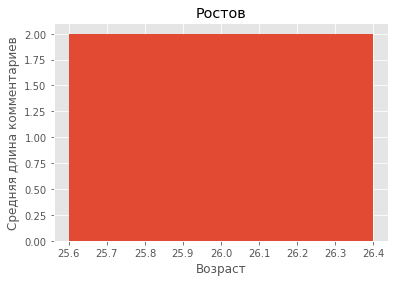

1091129 [30] [3]


1901945 [] []
1906450 [13] [3]


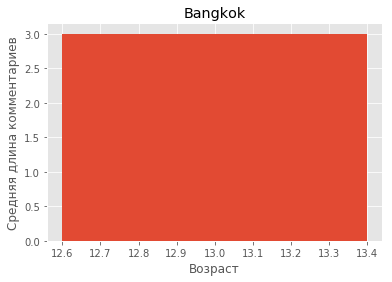

1361 [] []
18068 [] []
15043 [14] [0]


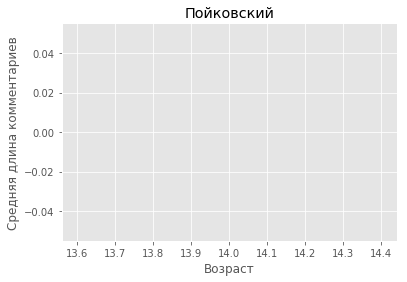

1637 [] []
20681 [] []
11512 [] []
695 [] []
86 [] []
1004426 [32] [3]


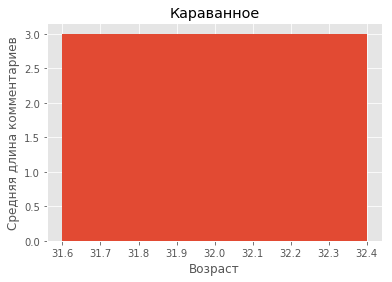

15157 [19] [13]


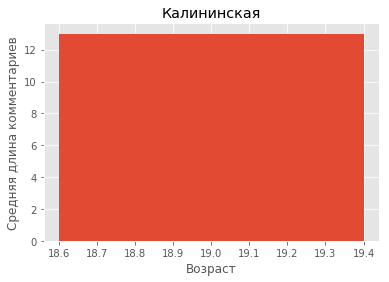

1147398 [21] [8]


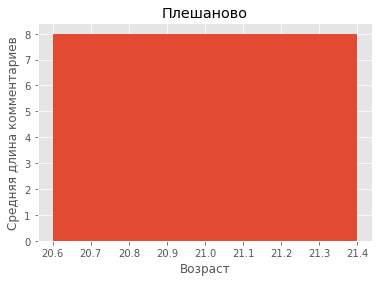

1678 [] []
1032487 [14] [1]


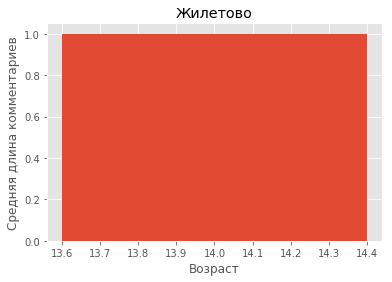

3685 [] []
3653 [31] [1]


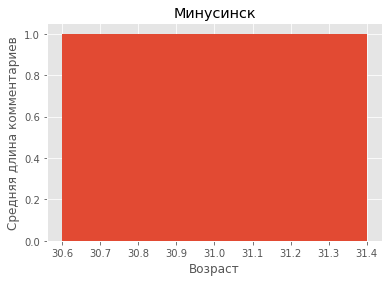

6700 [] []
4499 [] []
14954 [] []
1919452 [17] [0]


1014 [] []
2316 [26] [6]


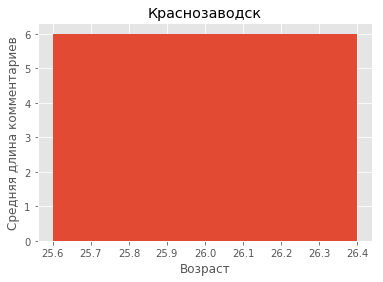

6600 [17] [5]


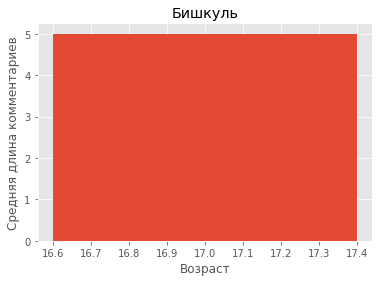

6731 [] []
1161172 [17] [0]


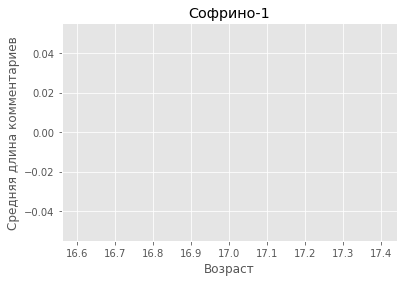

708 [] []
5468 [] []
4123 [] []
1746 [] []
5076 [] []
1127475 [14] [3]


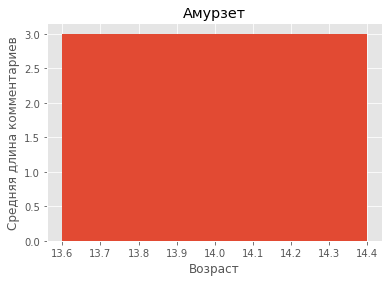

12704 [13] [2]


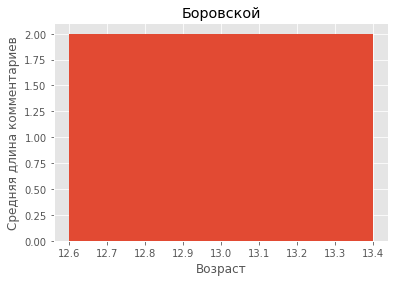

1506 [14] [7]


11120 [26] [0]


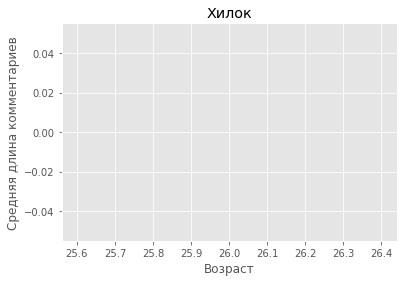

3518 [] []
1601 [33] [18]


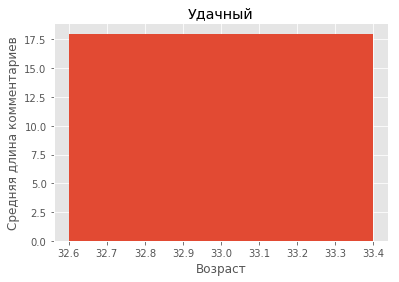

9196 [23] [2]


1863 [] []
994 [] []
5062 [] []
21032 [18] [9]


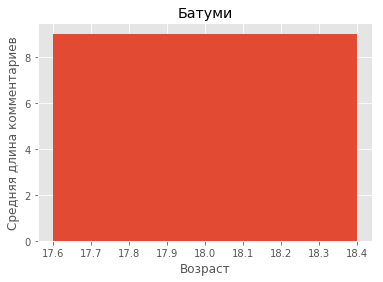

3644 [23] [6]


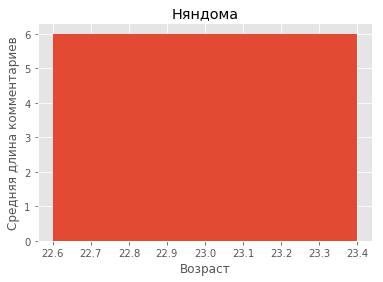

7076 [] []
3248 [] []
13318 [] []
5589 [] []
19289 [] []
3581 [] []
1155328 [] []
9328 [] []
13277 [] []
1482 [] []
19801 [25] [7]


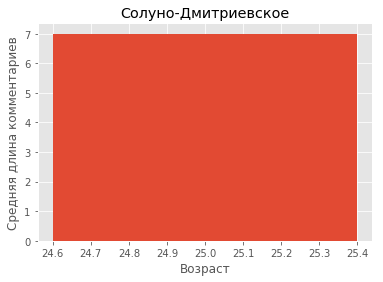

16368 [] []
11588 [] []
3038458 [31] [6]


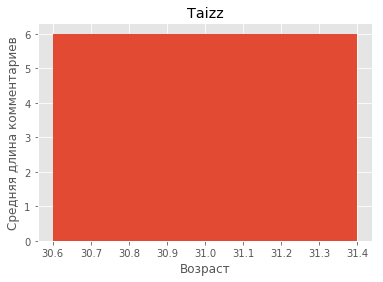

1008839 [] []
1960291 [] []
7333 [] []
9758 [] []
1124089 [33] [16]


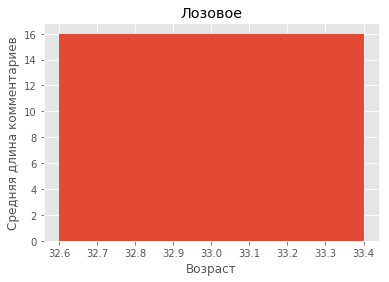

9115 [] []
1078232 [] []
1086184 [] []
16223 [] []
5422389 [] []
3621 [] []
1092065 [] []
1502742 [] []
21856 [] []
3155 [] []
1051147 [26] [2]


2412 [] []
3696 [] []
7379 [] []
1060250 [] []
4926411 [] []
2487 [30] [18]


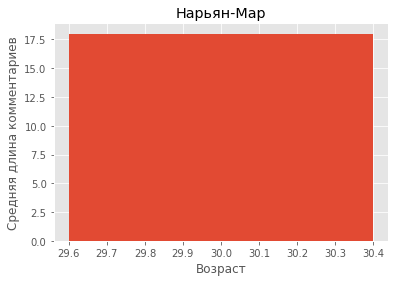

1172 [21] [1]


20550 [] []
1612 [] []
6276 [] []
18445 [19] [1]


13833 [16] [3]


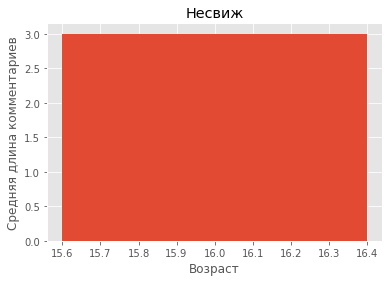

18091 [16] [2]


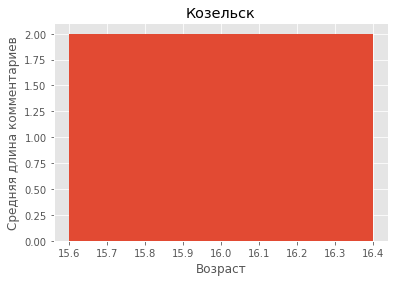

2539 [] []
521 [14, 33] [3, 23]


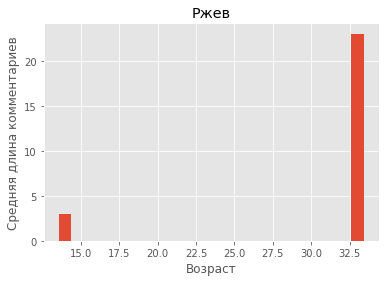

1019216 [14] [2]


1127973 [] []
6676 [] []
22147 [17] [2]


9894 [22] [2]


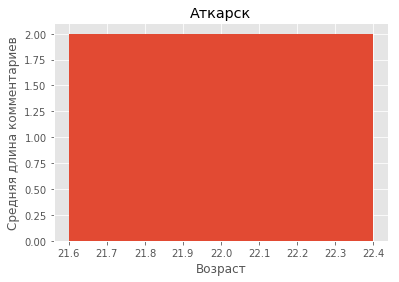

4356 [] []
1910350 [] []
14859 [37] [2]


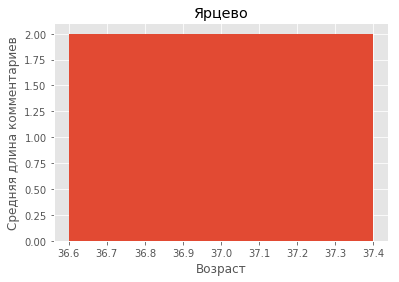

89 [22] [19]


591 [] []
6541 [] []
1080474 [17] [1]


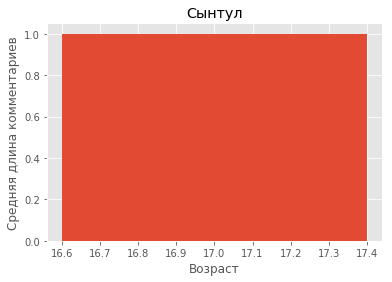

4310 [] []
5487 [] []
1161149 [] []
16729 [] []
1601032 [] []
3101 [] []
461 [19] [2]


5103 [24] [3]


4331 [] []
11654 [15] [2]


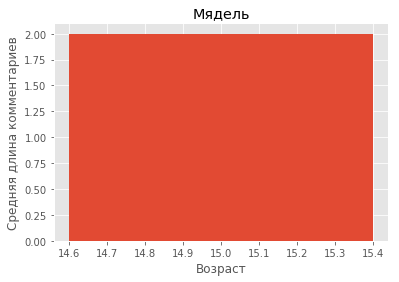

1002244 [25] [4]


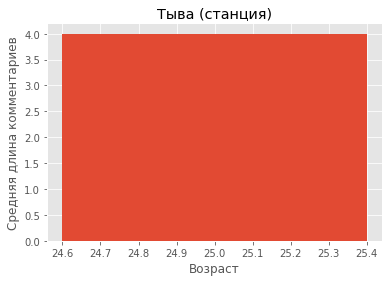

50 [] []
5489 [50] [3]


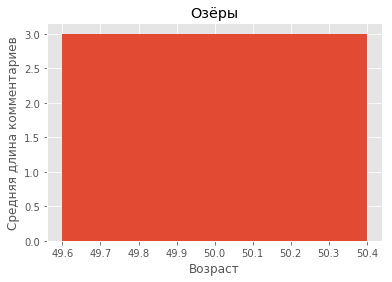

1941 [] []
1376 [16] [19]


1143859 [21] [1]


21941 [] []
1426 [39] [4]


17849 [14] [11]


10789 [] []
5328 [] []
1083572 [] []
1143892 [17] [2]


1048397 [] []
16712 [] []
1129124 [] []
1952694 [] []
102 [28] [16]


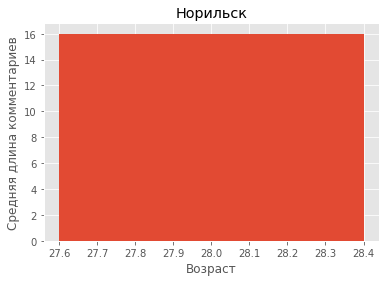

4931 [] []
5266342 [] []
15922 [] []
1101 [16] [8]


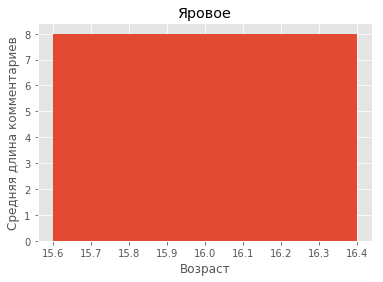

3810 [] []
11320 [25] [21]


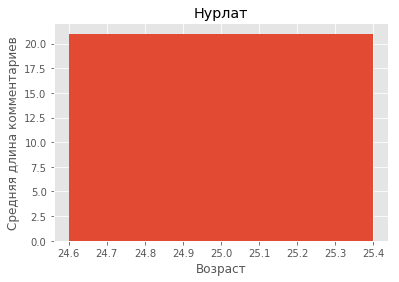

1131310 [] []
1355 [] []
3548 [] []
1536 [28] [10]


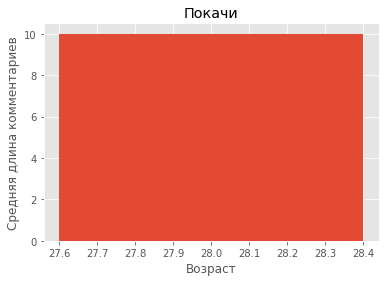

3169 [24] [60]


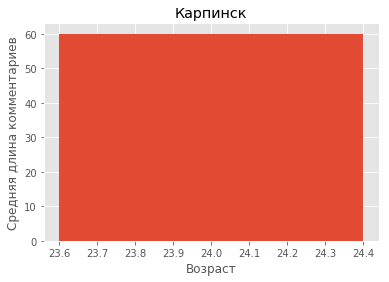

14454 [19] [16]


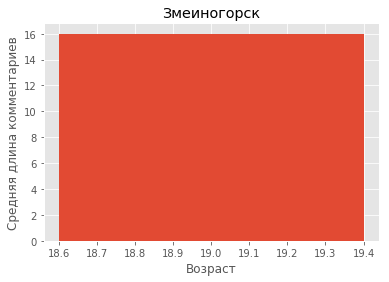

1079406 [] []
307 [] []
1601857 [13] [6]


581 [21] [3]


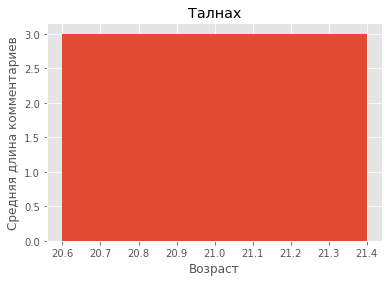

1516966 [28] [1]


1157390 [19] [9]


1968700 [] []
503 [26] [10]


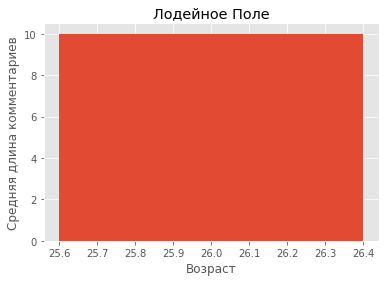

232 [] []
1501312 [] []
1009527 [] []
1025230 [] []
3489 [] []
2732 [] []
2066 [16] [22]


5297 [] []
10642 [] []
784 [] []
373 [] []
5850 [] []
273 [] []
1156 [] []
5252 [24] [1]


In [37]:
graf_city_age()

In [82]:
def all_city_len():# график 
    all_inf = file('all_inf.txt')
    all_inf = json.loads(all_inf)
    dict_city = {}# словарь: ключи - город, значения массив из длин комментариев
    for p in all_inf:
        if all_inf[p][3] not in dict_city:
            dict_city[all_inf[p][3]] = [all_inf[p][1]]
        else:
            dict_city[all_inf[p][3]].append(all_inf[p][1])
    for z in dict_city:
        dict_city[z] = aver(dict_city[z])# средняя длина комментариев
    #print(dict_city)
    cities = []
    for g in dict_city:
        if g == 0:
            cities.append('Неизвестно')
        else:
            cities.append(what_city(g))
    #print(cities)
    length = []
    for key in dict_city:
        length.append(dict_city[key])
    s = {}
    k = 0
    #print(length)
    #print(cities)
    for c in cities:
        s[cities[k]]=length[k]
        k += 1
    #print(s)
    s = json.dumps(s, ensure_ascii=False)
    writefile('city_len.txt',str(s))

In [83]:
all_city_len()

In [87]:
def grapf_cit():
    s = file('city_len.txt')
    s = json.loads(s)
    l = lambda x: x[1]
    sort_s = sorted(s.items(), key=l, reverse=True)
    sort_s = sort_s[:50:]#рисую города, у которых самые большие комментарии
    plt.bar(
        range(len(sort_s)), 
        [i[1] for i in sort_s]
            )
    plt.xticks(
        range(len(sort_s)), 
        [i[0] for i in sort_s], 
        rotation='vertical'
            )
    plt.title('Зависимость длины комментариев от города')
    plt.ylabel('Средняя длина комментариев')
    plt.xlabel('Город')
    plt.savefig('relation3.png')
    plt.show()
    plt.close()

In [88]:
grapf_cit()